# Gpu Configuration

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [ ]:
import xml.etree.ElementTree as ET
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import nltk #To clean data
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
import nlpaug.augmenter.word as naw
from tqdm import tqdm
import tensorflow as tf
#from google.colab import drive
import numpy as np
import pandas as pd #To create dataframe
import keras
from keras.utils import to_categorical #To transform the texto to OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub  #to obtain the pre-trained BERT model
import matplotlib.pyplot as plt #to Chart
from sklearn.model_selection import train_test_split #Split the train, test and val data
import math
import re #To clean text
#from bs4 import BeautifulSoup
from tensorflow.keras import layers
import bert #Import bert
from keras.preprocessing.text import Tokenizer #To create a tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences #To use padding
from keras.layers import Embedding #To create Embedding layer
import random #mezclar datos
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix #To analyze metrics
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping #to create a checkpoint and save each acc in each epocs that improves, and tensorflow and to stop when the loss does not decrease in training
from datetime import datetime #To tensorboard

# Seed definition

In [ ]:
#SET SEED

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)


# With 5 emotions

## Isear dataset

- The isear dataset is imported and data cleaning and preprocessing are applied

In [ ]:
isear = pd.read_excel('ISEAR.xlsx') #Import ISEAR dataset 


print(isear.head())

      ID  CITY  COUN  SUBJ  SEX  AGE  RELI  PRAC  FOCC  MOCC  ...  SELF  RELA  \
0  11001     1     1     1    1   33     1     2     6     1  ...     3     3   
1  11001     1     1     1    1   33     1     2     6     1  ...     2     2   
2  11001     1     1     1    1   33     1     2     6     1  ...     2     1   
3  11001     1     1     1    1   33     1     2     6     1  ...     1     1   
4  11001     1     1     1    1   33     1     2     6     1  ...     0     2   

   VERBAL  NEUTRO   Field1  Field3  Field2   MYKEY  \
0       2       0      joy       4       3  110011   
1       0       0     fear       3       2  110012   
2       0       0    anger       1       3  110013   
3       0       2  sadness       4       4  110014   
4       0       0  disgust       4       4  110015   

                                                 SIT  STATE  
0  During the period of falling in love, each tim...      1  
1         When I was involved in a traffic accident.      1  
2 

In [ ]:
isearDataset = isear.iloc[:, [40,36]] #only column 40 (text) and 36 (label) are selected.
isearDataset = isearDataset.rename(columns={'Field1': 'label', 'SIT': 'texto'}) #Rename columns from Field 1 to label and from Sit to text
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness
7663,I was at home and I heard a loud sound of spit...,disgust
7664,I did not do the homework that the teacher had...,shame


In [ ]:
def eliminarAcentos(texto):
    texto = texto.replace('á', '') #Eliminate errors in english text (á)
    texto = texto.replace('\n', '') #Remove spaces
    return texto
isearDataset['texto'] = isearDataset['texto'].apply(eliminarAcentos) #Apply function

In [ ]:
"""
Here the labels shame, guilt and guit are eliminated as they are not representative for the recognition of emotions in education.
"""


isearDataset = isearDataset.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad']) #Rename labels joy, anger and sadness to happy, angry y sad
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'shame'].index) #Eliminate labels not to be used
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guilt'].index) #Eliminate labels not to be used
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guit'].index) #Eliminate labels not to be used
isearDataset = isearDataset.reset_index(drop=True)
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
5472,I received a letter from a distant friend.,happy
5473,My parents were out and I was the eldest at ho...,fear
5474,Two years back someone invited me to be the tu...,angry
5475,I had taken the responsibility to do something...,sad


In [8]:
isearDataset.describe()

,texto,label
count,5477,5477
unique,5384,5
top,[ No response.],angry
freq,42,1096


In [64]:
isearDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477 entries, 0 to 5476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   5477 non-null   object
 1   label   5477 non-null   object
dtypes: object(2)
memory usage: 85.7+ KB


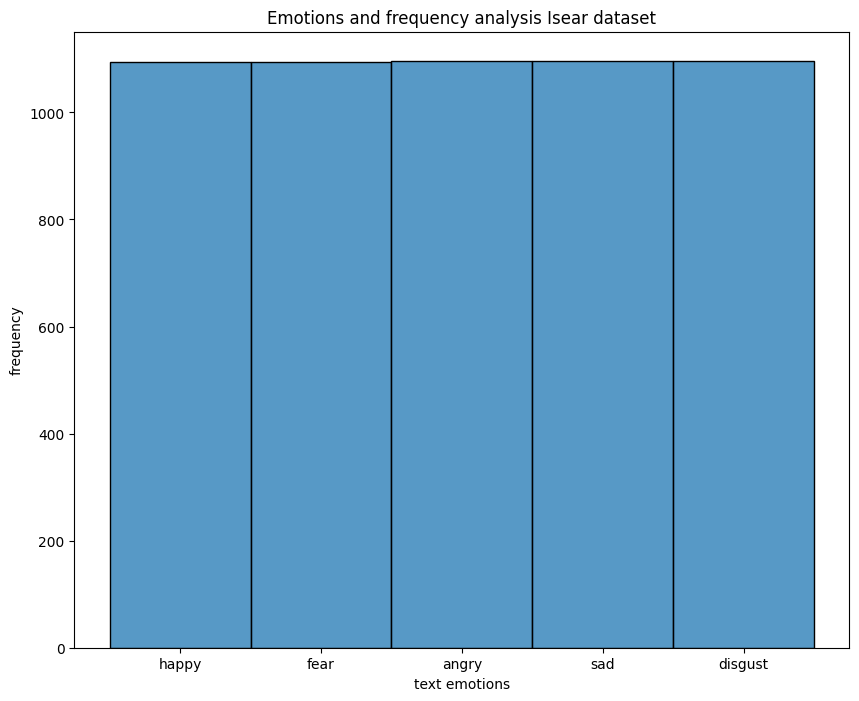

In [ ]:
plt.figure(figsize=(10,8)) #Graph to visualize th balanced data by having all the same amount of data
sns.histplot(isearDataset['label'])
plt.xlabel('text emotions')
plt.ylabel('frequency')
plt.title('Emotions and frequency analysis Isear dataset')
plt.show()

In [ ]:
isearDataset['label'].value_counts() #It can see that the data have the same amount of data in each label


label
angry      1096
sad        1096
disgust    1096
fear       1095
happy      1094
Name: count, dtype: int64

In [67]:
isearDataset['label'].unique()


array(['happy', 'fear', 'angry', 'sad', 'disgust'], dtype=object)

## Clean emotions text

In [ ]:
import re

"""
This function cleans the data by removing numbers, @, #, emoticons, extra spaces, data errors, and any other unwanted elements
"""

def clean_emotion_text(texto): #Function for data clearing
    if isinstance(texto, list): #If it is a list, it takes the first value
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #If it starts and ends with [] it eliminates them
        texto = texto[1:-1]

    texto = texto.lower() #Convert text to lowercase

    texto = texto.replace('á', '') #Eliminate errors
    texto = texto.replace('\n', '') #Eliminates erroneous spaces
    texto = texto.replace('[]', "'") #Eliminate []
    texto = texto.replace('', "'") #Eliminate more errors

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto) #Remove any text starting with @
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) #Remove Urls that with "https://
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto) #Remove any character that is not a letter
    texto = re.sub(r"#", ' ', texto) #Remove the # symbol
    texto = re.sub(r"\s(?=\')", "", texto) # Removes spaces that occur right before an apostrophe (')
    texto = texto.replace("' ", "'")  #Removes any space after an apostrophe and directly connects the next word
    texto = re.sub(r" +", ' ', texto) # Replaces multiple consecutive spaces with a single space.


    return texto

# Llamado a la función de limpieza
texto_clean = [clean_emotion_text(text) for text in tqdm(isearDataset['texto'])] #Apply the function to the text

100%|██████████| 5477/5477 [00:00<00:00, 72516.47it/s]


## Transformations from classes to numerics

In [ ]:
labels = isearDataset['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels) #Labels are transformed into One Hot Encoder

data_labels = labelEncoder

In [ ]:
# Get the class names
class_names = le.classes_

# Get the numeric values assigned to each class
class_values = le.transform(class_names)

# Print class names and their numeric values
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: sad, Valor: 4


## Division of the training set, testing and validation

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(texto_clean, data_labels, random_state=42, stratify=data_labels, test_size=0.1) #The data is divided into 10% for testing, using stratify to maintain distribution
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train, test_size=0.2222) #The data is divided into 20% of total for validation, using stratify to maintain distribution

In [ ]:
#SET SEED
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

## Data augmentation for text

In [ ]:
from textattack.augmentation import EasyDataAugmenter
from tqdm import tqdm
import random
import numpy as np

"""
A function is created that allows applying data augmentation, where synonym replacement, text generation,
random exhange of word positions and random elimination are applied.
"""


# Create augmenter
augmenter = EasyDataAugmenter()

# Function to apply the text augmentation
def augment_text(text, label):
    set_seed(42)
    augmented_texts = augmenter.augment(text)
    augmented_data = [(augmented_text, label) for augmented_text in augmented_texts]
    return augmented_data

# Convert zip result to list
data_with_labels = list(zip(x_train, y_train))

# Apply text augmentation to each text in texto_clean 
augmented_data_list = [augment_text(text, label) for text, label in tqdm(data_with_labels, total=len(data_with_labels))]

# Flatten the list of list
augmented_data_flat = [item for sublist in augmented_data_list for item in sublist]

# Extract the generated phrases and labels
x_train_augmented = [augmented_text for augmented_text, label in augmented_data_flat]
y_train_augmented = [label for augmented_text, label in augmented_data_flat]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 3833/3833 [14:13<00:00,  4.49it/s]  


In [21]:
"""#Save Augmented data

import pandas as pd

df_augmented = pd.DataFrame({'Texto': x_train_augmented, 'Label': y_train_augmented})

df_augmented.to_csv('datos_aumentados.csv', index=False)"""


In [13]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with5emotions.csv')

# Get the augmentation data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()


## Glove and Word2Vec Embeddings

In [12]:
# Defining pre-processing parameters
max_len = 300
vocab_size = 300

In [ ]:
tokenizer = Tokenizer() # The tokenizer is created
tokenizer.fit_on_texts(x_train_augmented) #The text is transformed by applyinh the tokenizer

In [14]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

9033

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(x_train_augmented) # Converts the augmented training text data (x_train_augmented) into sequences of integers 
X_val_seq = tokenizer.texts_to_sequences(x_val) # Converts the augmented validation text data (x_val) into sequences of integers 
X_test_seq = tokenizer.texts_to_sequences(x_test)# Converts the augmented testing text data (x_test) into sequences of integers 

In [ ]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post') # Pads the training sequences (X_train_seq) to ensure all sequences have the same length, defined by `max_len`.
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post') # Pads the validation sequences (X_val_seq) to ensure all sequences have the same length, defined by `max_len`.
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post') # Pads the testing sequences (X_test_seq) to ensure all sequences have the same length, defined by `max_len`.

### Glove

In [ ]:
unique, counts = np.unique(y_train_augmented, return_counts=True)
print(dict(zip(unique, counts)))


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  

# Load the Glove model file
glove_file = 'glove.6B.300d.txt'
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs #Stores the word and its embedding vector in the dictionary embedding_index

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector ## If an embedding vector exists for the word, it is assigned to the corresponding row in the embedding matrix.

{0: 3068, 1: 3068, 2: 3062, 3: 3063, 4: 3066}


In [20]:
X_train_padded

array([[   8,    6,   72, ...,    0,    0,    0],
       [   8,    6,   72, ...,    0,    0,    0],
       [   8,    6, 1102, ...,    0,    0,    0],
       ...,
       [ 183,   18,   13, ...,    0,    0,    0],
       [  18,   13,    1, ...,    0,    0,    0],
       [  18,  183,   13, ...,    0,    0,    0]])

In [19]:
y_train_augmented = np.array(y_train_augmented)


In [22]:
y_train_augmented

array([0, 0, 0, ..., 4, 4, 4])

In [23]:
y_val

array([4, 1, 3, ..., 4, 0, 1])

The first Glove model is created

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint


# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False)) #Embedding layer is created, using the pre-trained embedding model Glove
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) #Output layer

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #Compilation
 
print(model.summary())

checkpoint_path = 'model/Glove/64batch/GloVe_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpointGloVe = ModelCheckpoint( #To create a checkpoint when the model is improved 
    checkpoint_path, 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)

# Training the model
history = model.fit(X_train_padded, y_train_augmented, epochs=20, batch_size=64, validation_data=(X_val_padded, y_val), shuffle=True, callbacks=[model_checkpointGloVe])

# Evaluating the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          2710200   
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 128)         186880    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = y_test #Get all classes of y_test
y_pred = model.predict(X_test_padded).argmax(axis=1) 

report = classification_report(y_true, y_pred) #The classification report is generated with various metrics.

print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

18/18 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       110
           1       0.60      0.59      0.59       110
           2       0.79      0.76      0.78       109
           3       0.80      0.79      0.79       109
           4       0.68      0.63      0.65       110

    accuracy                           0.69       548
   macro avg       0.69      0.69      0.69       548
weighted avg       0.69      0.69      0.69       548

<function confusion_matrix at 0x0000024E0B07EDD0>


In [47]:
y_train_augmented.shape


(15327,)

In [48]:
y_val.shape

(1096,)

In [54]:
print(f'y_train_augmented shape: {y_train_augmented.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')


y_train_augmented shape: (15327,)
y_val shape: (1096,)
y_test shape: (548,)


In [ ]:
#Text is transformed to oneHotEncoder
y_train_one_hot = to_categorical(y_train_augmented, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

In [56]:
y_train_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
input_layer = tf.keras.layers.Input(shape=(max_len,))

embd = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False)(input_layer) #Embedding layer is created, using the pre-trained embedding model Glove
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(embd) #First gram
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(embd) #Second gram
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(embd) #Third gram
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout) #Output layer
modelGlove = tf.keras.models.Model(inputs=input_layer, outputs=dense_output)

modelGlove.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
modelGlove.summary()


print(modelGlove.summary())


#Training the model
history = modelGlove.fit(X_train_padded, y_train_one_hot, epochs=20, batch_size=128, validation_data=(X_val_padded,y_val_one_hot), shuffle=True)



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 300, 300)     2722500     ['input_8[0][0]']                
                                                                                                  
 conv1d_21 (Conv1D)             (None, 300, 128)     76928       ['embedding_7[0][0]']            
                                                                                                  
 conv1d_22 (Conv1D)             (None, 300, 128)     115328      ['embedding_7[0][0]']            
                                                                                            

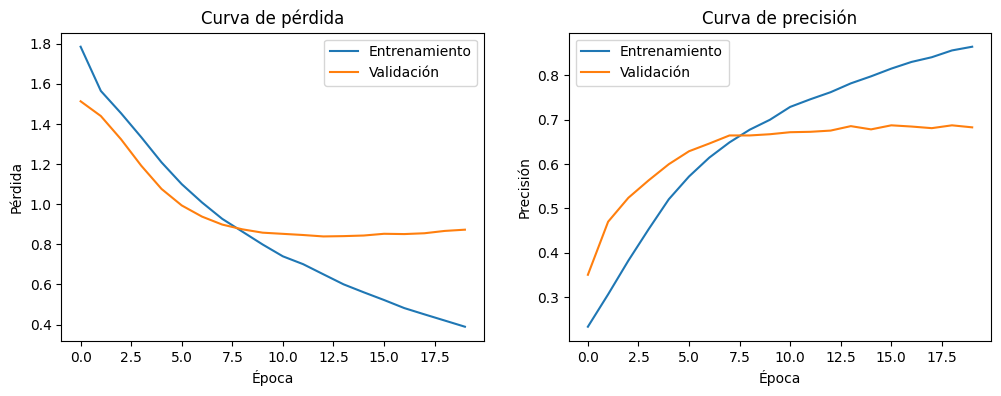

In [62]:
import matplotlib.pyplot as plt


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [ ]:
#Evaluating the model
evaluation_result = modelGlove.evaluate(X_test_padded, y_test_one_hot)
print(f'Test Loss: {evaluation_result[0]}, Test Accuracy: {evaluation_result[1]*100:.2f}%')


18/18 [==============================] - 0s 14ms/step - loss: 0.9115 - accuracy: 0.6697 - recall_7: 0.6113
Test Loss: 0.9114594459533691, Test Accuracy: 66.97%


### Word2Vec

In [ ]:
#Text is transformed to oneHotEncoder
y_train_one_hot = to_categorical(y_train_augmented, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

In [ ]:
from gensim.models import KeyedVectors

unique, counts = np.unique(y_train_augmented, return_counts=True)
print(dict(zip(unique, counts)))
# Computes and prints the distribution of classes in the training labels (y_train_augmented).

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 


# Load Word2vec model file
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Create embedding matrix
embedding_matrix_word2vec = np.zeros((vocab_size, 300)) # Initializes an embedding matrix with shape (vocab_size, 300)
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix_word2vec[i] = word2vec[word]
        # If a word in the vocabulary exists in the Word2Vec model, its vector representation is copied
        # to the corresponding row in the embedding matrix.

{0: 3068, 1: 3068, 2: 3062, 3: 3063, 4: 3066}


In [ ]:
input_layer = tf.keras.layers.Input(shape=(max_len,))

embd = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix_word2vec], trainable=False)(input_layer) #Embedding layer is created, using the pre-trained embedding model Word2Vec
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(embd) #First gram
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(embd) #Second gram
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(embd) #Third gram
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout) #Output layer
modelWord2vec1 = tf.keras.models.Model(inputs=input_layer, outputs=dense_output)

modelWord2vec1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
modelWord2vec1.summary()


print(modelWord2vec1.summary())


checkpoint_path = 'model/Word2Vec/64batch/GloVe_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpointWord2Vec = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)

#Training the model
historyWord2vec1 = modelWord2vec1.fit(X_train_padded, y_train_one_hot, epochs=20, batch_size=128, validation_data=(X_val_padded,y_val_one_hot), shuffle=True, callbacks=[model_checkpointWord2Vec])

print(modelWord2vec1.evaluate(X_test_padded,y_test_one_hot))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 300, 300)     2710200     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 300, 128)     76928       ['embedding_3[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 300, 128)     115328      ['embedding_3[0][0]']            
                                                                                              

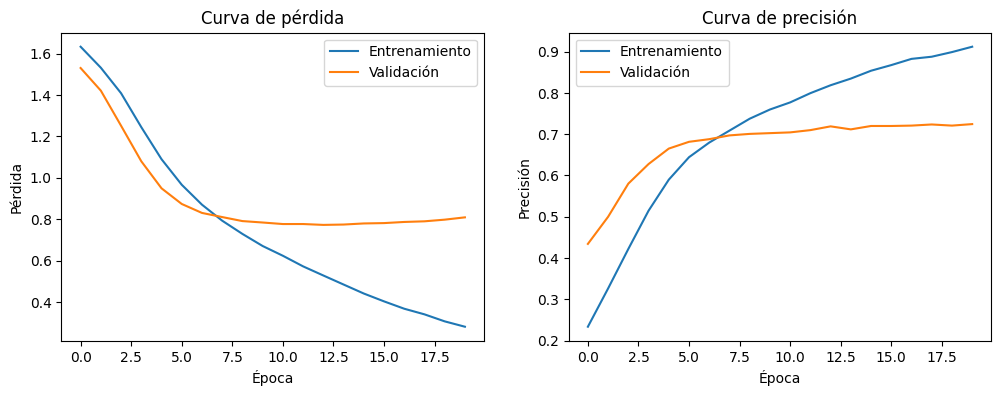

In [34]:
import matplotlib.pyplot as plt


train_loss = historyWord2vec1.history['loss']
val_loss = historyWord2vec1.history['val_loss']
train_accuracy = historyWord2vec1.history['accuracy']
val_accuracy = historyWord2vec1.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#evaluation model
y_true = y_test #Get all classes of y_test
y_pred = modelWord2vec1.predict(X_test_padded).argmax(axis=1)  #The classification report is generated with various metrics.

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

18/18 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       110
           1       0.72      0.65      0.68       110
           2       0.78      0.78      0.78       109
           3       0.72      0.86      0.79       109
           4       0.70      0.63      0.66       110

    accuracy                           0.72       548
   macro avg       0.72      0.72      0.71       548
weighted avg       0.72      0.72      0.71       548

<function confusion_matrix at 0x0000024E0B07EDD0>


## Definition Bert and Roberta

- To use the pre-trained BERT models or derivations, the model and the corresponding tokenizer must be imported.

In [ ]:
from transformers import BertTokenizer, TFBertModel,RobertaTokenizer,TFRobertaModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased') #BERT's model is imported
bert_model = TFBertModel.from_pretrained('bert-base-uncased') #Import the BERT tokenizer

tokenizer_roberta = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base") #RoBERTa's model is imported
roberta_model = TFRobertaModel.from_pretrained("FacebookAI/roberta-base") #Import the RoBERTa tokenizer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

### Embedding Bert

In [ ]:
def tokenizer_bert_fn(texts, labels): #Function for tokenization by Bert Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=5) #Transforms labels to OneHotEncoder

    for text in texts: #for each text
        inputs = tokenizer_bert(text,  #Tokenized
                                padding="max_length", #Padding is applied with a length of 300 
                                truncation=True, # Truncate sequences longer than the maximum length
                                max_length=300, #Max length
                                return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved

    return np.array(input_ids), np.array(attention_masks), label_array 

input_ids_train, attention_mask_train, labels_train = tokenizer_bert_fn(x_train_augmented, y_train_augmented)
input_ids_test, attention_mask_test, labels_test = tokenizer_bert_fn(x_test, y_test)
input_ids_val, attention_mask_val, labels_val = tokenizer_bert_fn(x_val, y_val)

input_ids_train = np.squeeze(input_ids_train, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train = np.squeeze(attention_mask_train, axis=1) # Remove the unnecessary dimension introduced

input_ids_test = np.squeeze(input_ids_test, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test = np.squeeze(attention_mask_test, axis=1) # Remove the unnecessary dimension introduced

input_ids_val = np.squeeze(input_ids_val, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val = np.squeeze(attention_mask_val, axis=1) # Remove the unnecessary dimension introduced


### Embedding Roberta

In [ ]:
def tokenizer_roberta_fn(texts, labels): #Function for tokenization by RoBERTa Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=5) #Transforms labels to OneHotEncoder

    for text in texts: #for each text
        inputs = tokenizer_roberta(text,  #Tokenized
                                padding="max_length",  #Padding is applied with a length of 300 
                                truncation=True, # Truncate sequences longer than the maximum length
                                max_length=300, #Max length
                                return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta, attention_mask_train_roberta, labels_train_roberta = tokenizer_roberta_fn(x_train_augmented, y_train_augmented)
input_ids_test_roberta, attention_mask_test_roberta, labels_test_roberta = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta, attention_mask_val_roberta, labels_val_roberta = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta = np.squeeze(input_ids_train_roberta, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train_roberta = np.squeeze(attention_mask_train_roberta, axis=1) # Remove the unnecessary dimension introduced

input_ids_test_roberta = np.squeeze(input_ids_test_roberta, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test_roberta = np.squeeze(attention_mask_test_roberta, axis=1) # Remove the unnecessary dimension introduced

input_ids_val_roberta = np.squeeze(input_ids_val_roberta, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val_roberta = np.squeeze(attention_mask_val_roberta, axis=1) # Remove the unnecessary dimension introduced

## Models Bert

### Model 1 Bert + BiLstm-CNN Duo 75.18%

In [ ]:
from transformers import TFBertModel
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

bert_model.trainable = False #Pre-trained layers set to False

#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids = tf.keras.Input(shape=(300,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(300,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model([input_ids, attention_mask])[0] #The output of the model is obtained

bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(bert_output) #Enter the output to BiLsstm
x1 = Conv1D(32, 3, activation='relu')(bilstm)
x1 = Conv1D(32, 5, activation='relu')(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(bert_output) #Enter the output to BiLsstm
x2 = Conv1D(32, 5, activation='relu')(bilstm)
x2 = Conv1D(32, 3, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)

xconcat = tf.concat([x1,x2], axis=-1) #The layers are concatenated
pooled = GlobalMaxPooling1D()(xconcat)
dropout= tf.keras.layers.Dropout(0.5)(pooled)
output_layer = Dense(256, activation='relu')(dropout)
output = Dense(5, activation='softmax')(output_layer) #output layer

model2 = Model(inputs=[input_ids, attention_mask], outputs=output)

model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']) #compilation

import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) #To create a checkpoint when the model is improved

#Training the model
history2 = model2.fit([input_ids_train, attention_mask_train], labels_train, validation_data=([input_ids_val, attention_mask_val], labels_val), epochs=15, batch_size=128, callbacks = [early_stopping], shuffle=True)

Epoch 1/15
120/120 [==============================] - 259s 2s/step - loss: 1.1145 - accuracy: 0.5462 - val_loss: 0.8709 - val_accuracy: 0.7044
Epoch 2/15
120/120 [==============================] - 239s 2s/step - loss: 0.7969 - accuracy: 0.7109 - val_loss: 0.7823 - val_accuracy: 0.7217
Epoch 3/15
120/120 [==============================] - 240s 2s/step - loss: 0.6720 - accuracy: 0.7574 - val_loss: 0.6745 - val_accuracy: 0.7710
Epoch 4/15
120/120 [==============================] - 239s 2s/step - loss: 0.5903 - accuracy: 0.7896 - val_loss: 0.6846 - val_accuracy: 0.7619
Epoch 5/15
120/120 [==============================] - 239s 2s/step - loss: 0.4879 - accuracy: 0.8250 - val_loss: 0.6380 - val_accuracy: 0.7637
Epoch 6/15
120/120 [==============================] - 239s 2s/step - loss: 0.4195 - accuracy: 0.8538 - val_loss: 0.6382 - val_accuracy: 0.7536
Epoch 7/15
120/120 [==============================] - 240s 2s/step - loss: 0.3752 - accuracy: 0.8635 - val_loss: 0.6212 - val_accuracy: 0.7719

In [60]:
model2.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 8s 423ms/step - loss: 0.7207 - accuracy: 0.7518


[0.72074294090271, 0.7518247961997986]

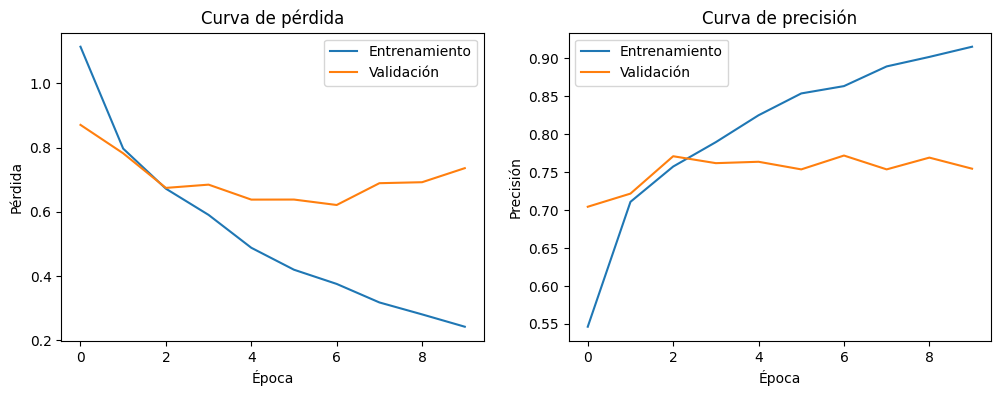

In [61]:
import matplotlib.pyplot as plt


train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 2 bert + Ngram CNN - 64 filters 75.91%

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(64,2,padding='same', activation='relu')(bert_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(bert_output) #Enter the output to Trigram - Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64,4,padding='same', activation='relu')(bert_output) #Enter the output to Fourgram - Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout) #Output layer
model = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

model.layers[2].trainable=False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [ ]:
history = model.fit( #Training the model
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=10,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

Epoch 1/10
120/120 [==============================] - 247s 2s/step - loss: 1.7963 - accuracy: 0.2612 - recall_3: 0.0758 - val_loss: 1.3614 - val_accuracy: 0.5319 - val_recall_3: 0.0018
Epoch 2/10
120/120 [==============================] - 234s 2s/step - loss: 1.4007 - accuracy: 0.4058 - recall_3: 0.1079 - val_loss: 1.1015 - val_accuracy: 0.6286 - val_recall_3: 0.1971
Epoch 3/10
120/120 [==============================] - 234s 2s/step - loss: 1.1867 - accuracy: 0.5257 - recall_3: 0.2653 - val_loss: 0.9193 - val_accuracy: 0.6734 - val_recall_3: 0.4279
Epoch 4/10
120/120 [==============================] - 235s 2s/step - loss: 1.0483 - accuracy: 0.5867 - recall_3: 0.3984 - val_loss: 0.8152 - val_accuracy: 0.7144 - val_recall_3: 0.5392
Epoch 5/10
120/120 [==============================] - 234s 2s/step - loss: 0.9527 - accuracy: 0.6315 - recall_3: 0.4703 - val_loss: 0.7450 - val_accuracy: 0.7318 - val_recall_3: 0.6068
Epoch 6/10
120/120 [==============================] - 234s 2s/step - loss: 

In [66]:
model.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 7s 397ms/step - loss: 0.6538 - accuracy: 0.7591 - recall_3: 0.6861


[0.653837263584137, 0.7591241002082825, 0.6861313581466675]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#Validation model
y_true  = np.argmax(labels_test, axis=-1)
y_pred = model.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 9s 389ms/step
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       110
           1       0.71      0.62      0.66       110
           2       0.84      0.83      0.84       109
           3       0.82      0.91      0.86       109
           4       0.73      0.75      0.74       110

    accuracy                           0.76       548
   macro avg       0.76      0.76      0.76       548
weighted avg       0.76      0.76      0.76       548

[[75 19  2  4 10]
 [23 68  6  5  8]
 [ 5  1 91  5  7]
 [ 1  1  2 99  6]
 [ 5  7  7  8 83]]


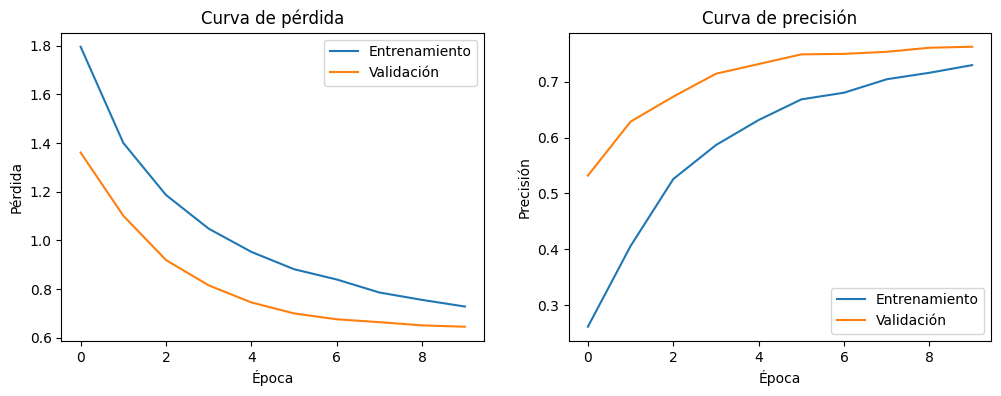

In [73]:
import matplotlib.pyplot as plt


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 3 bert + Ngram CNN - 64 filters - More kernel-size 77.18%

In [68]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(64,4,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64,5,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model3 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model3.layers[2].trainable=False

model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model3.summary()

history3 = model3.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [69]:
model3.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 7s 399ms/step - loss: 0.6520 - accuracy: 0.7719 - recall_4: 0.7099


[0.6519922614097595, 0.7718977928161621, 0.709854006767273]

In [70]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model3.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 9s 391ms/step
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       110
           1       0.69      0.71      0.70       110
           2       0.85      0.87      0.86       109
           3       0.86      0.92      0.89       109
           4       0.72      0.72      0.72       110

    accuracy                           0.77       548
   macro avg       0.77      0.77      0.77       548
weighted avg       0.77      0.77      0.77       548

[[ 71  22   3   4  10]
 [ 16  78   4   2  10]
 [  3   2  95   3   6]
 [  1   1   2 100   5]
 [  6  10   8   7  79]]


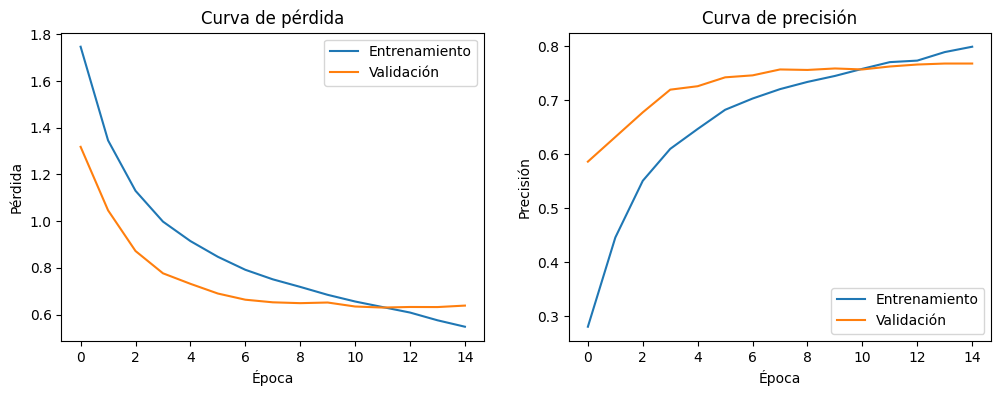

In [72]:
import matplotlib.pyplot as plt


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 4 Bert + BiLstm-CNN Duo - Different units Dense 75.18%

In [44]:
from transformers import TFBertModel
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

bert_model.trainable = False

input_ids = tf.keras.Input(shape=(300,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(300,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model([input_ids, attention_mask])[0]

bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(bert_output)
x1 = Conv1D(32, 3, activation='relu')(bilstm)
x1 = Conv1D(32, 5, activation='relu')(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(bert_output)
x2 = Conv1D(32, 5, activation='relu')(bilstm)
x2 = Conv1D(32, 3, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)

xconcat = tf.concat([x1,x2], axis=-1)
pooled = GlobalMaxPooling1D()(xconcat)
dropout= tf.keras.layers.Dropout(0.5)(pooled)
output_layer = Dense(512, activation='relu')(dropout)
dropout_end= tf.keras.layers.Dropout(0.5)(output_layer) 
output = Dense(5, activation='softmax')(dropout_end)

model4 = Model(inputs=[input_ids, attention_mask], outputs=output)

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

checkpoint_path = 'model/BERTHugginfFace/BiLSTMDUO/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpointBiLSTMDUO = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history4 = model4.fit([input_ids_train, attention_mask_train], labels_train, validation_data=([input_ids_val, attention_mask_val], labels_val), epochs=15, batch_size=128, callbacks = [early_stopping, model_checkpointBiLSTMDUO], shuffle=True)

Epoch 1/15
120/120 [==============================] - ETA: 0s - loss: 1.2043 - accuracy: 0.4927
Epoch 1: val_accuracy improved from -inf to 0.71259, saving model to model/BERTHugginfFace/BiLSTMDUO/64batch\BERT_CNN_model_best_01_val_0.7126.h5
120/120 [==============================] - 266s 2s/step - loss: 1.2043 - accuracy: 0.4927 - val_loss: 0.9201 - val_accuracy: 0.7126
Epoch 2/15
120/120 [==============================] - ETA: 0s - loss: 0.8216 - accuracy: 0.6969
Epoch 2: val_accuracy improved from 0.71259 to 0.75000, saving model to model/BERTHugginfFace/BiLSTMDUO/64batch\BERT_CNN_model_best_02_val_0.7500.h5
120/120 [==============================] - 242s 2s/step - loss: 0.8216 - accuracy: 0.6969 - val_loss: 0.7795 - val_accuracy: 0.7500
Epoch 3/15
120/120 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.7512
Epoch 3: val_accuracy improved from 0.75000 to 0.75730, saving model to model/BERTHugginfFace/BiLSTMDUO/64batch\BERT_CNN_model_best_03_val_0.7573.h5
120/

In [52]:
def custom_objects_fn_bert():
    return {'TFBertModel': TFBertModel}

model4_load = tf.keras.models.load_model('model/BERTHugginfFace/BiLSTMDUO/64batch\BERT_CNN_model_best_09_val_0.7682.h5', custom_objects=custom_objects_fn_bert())
model4_load.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 12s 417ms/step - loss: 0.7363 - accuracy: 0.7445


[0.7362977862358093, 0.7445255517959595]

In [45]:
model4.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 10s 513ms/step - loss: 0.6913 - accuracy: 0.7518


[0.6912896037101746, 0.7518247961997986]

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model4.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 12s 410ms/step
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       110
           1       0.70      0.67      0.69       110
           2       0.83      0.83      0.83       109
           3       0.78      0.89      0.83       109
           4       0.68      0.66      0.67       110

    accuracy                           0.75       548
   macro avg       0.75      0.75      0.75       548
weighted avg       0.75      0.75      0.75       548

[[78 16  3  3 10]
 [13 74  8  3 12]
 [ 4  3 90  7  5]
 [ 0  2  2 97  8]
 [ 6 11  5 15 73]]


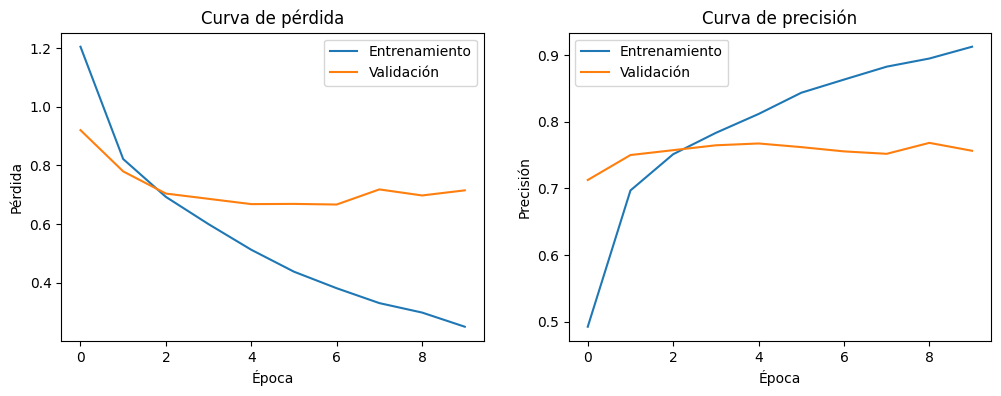

In [53]:
import matplotlib.pyplot as plt


train_loss = history4.history['loss']
val_loss = history4.history['val_loss']
train_accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 5 Bert + Ngram CNN - 32 filters - start kernel size in 200 71.89%

In [35]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(32,200,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(32,300,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(32,400,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.2)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model5 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model5.layers[2].trainable=False

model5.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model5.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_11[0][0]',               
                                thPoolingAndCrossAt               'input_12[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [36]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history5 = model5.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=64
)

Epoch 1/15
240/240 [==============================] - 682s 3s/step - loss: 1.1038 - accuracy: 0.5642 - recall_5: 0.3887 - val_loss: 0.8044 - val_accuracy: 0.7026 - val_recall_5: 0.5849
Epoch 2/15
240/240 [==============================] - 640s 3s/step - loss: 0.8495 - accuracy: 0.6801 - recall_5: 0.5604 - val_loss: 0.7846 - val_accuracy: 0.7089 - val_recall_5: 0.6095
Epoch 3/15
240/240 [==============================] - 640s 3s/step - loss: 0.7246 - accuracy: 0.7264 - recall_5: 0.6288 - val_loss: 0.8423 - val_accuracy: 0.6962 - val_recall_5: 0.6378
Epoch 4/15
240/240 [==============================] - 640s 3s/step - loss: 0.6395 - accuracy: 0.7600 - recall_5: 0.6795 - val_loss: 0.8723 - val_accuracy: 0.6980 - val_recall_5: 0.6405
Epoch 5/15
240/240 [==============================] - 649s 3s/step - loss: 0.5301 - accuracy: 0.8030 - recall_5: 0.7389 - val_loss: 0.8985 - val_accuracy: 0.7016 - val_recall_5: 0.6670


In [38]:
model5.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 18s 972ms/step - loss: 0.7630 - accuracy: 0.7190 - recall_5: 0.6113


[0.7630119323730469, 0.7189781069755554, 0.6113138794898987]

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model5.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 25s 1s/step
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       110
           1       0.70      0.66      0.68       110
           2       0.79      0.79      0.79       109
           3       0.77      0.91      0.84       109
           4       0.68      0.65      0.67       110

    accuracy                           0.72       548
   macro avg       0.72      0.72      0.72       548
weighted avg       0.72      0.72      0.72       548

[[64 21  5  8 12]
 [19 73  6  3  9]
 [ 6  4 86  6  7]
 [ 1  2  1 99  6]
 [10  5 11 12 72]]


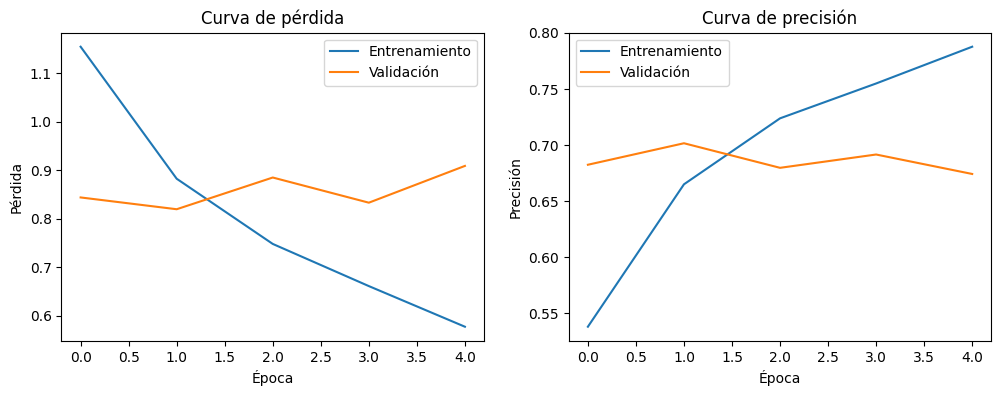

In [71]:
import matplotlib.pyplot as plt


train_loss = history5.history['loss']
val_loss = history5.history['val_loss']
train_accuracy = history5.history['accuracy']
val_accuracy = history5.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 6 Bert + Ngram CNN - 32 filters 76.82%

In [17]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(32,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(32,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(32,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model6 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model6.layers[2].trainable=False

model6.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model6.summary()

import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history6 = model6.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=64
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [18]:
model6.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 7s 391ms/step - loss: 0.6504 - accuracy: 0.7682 - recall_1: 0.7026


[0.6503681540489197, 0.7682482004165649, 0.7025547623634338]

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model6.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 9s 391ms/step
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       110
           1       0.68      0.71      0.69       110
           2       0.84      0.82      0.83       109
           3       0.84      0.92      0.88       109
           4       0.73      0.75      0.74       110

    accuracy                           0.77       548
   macro avg       0.77      0.77      0.77       548
weighted avg       0.77      0.77      0.77       548

[[ 72  22   4   4   8]
 [ 13  78   5   4  10]
 [  3   5  89   4   8]
 [  1   1   2 100   5]
 [  6   9   6   7  82]]


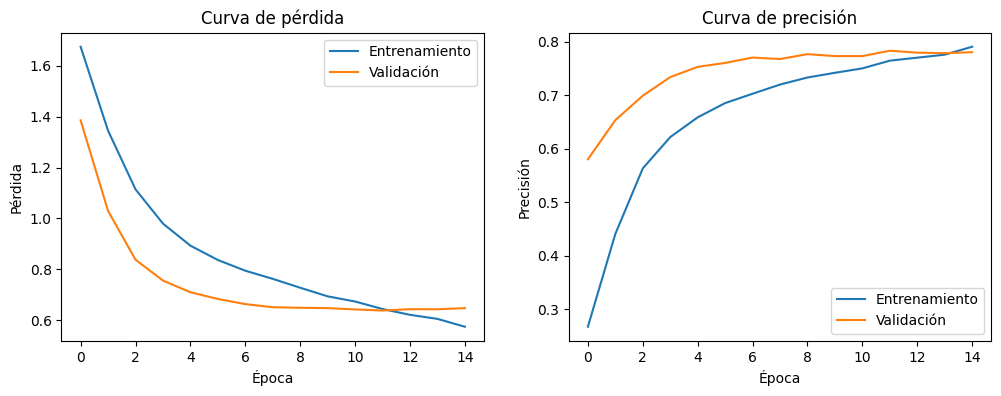

In [20]:
import matplotlib.pyplot as plt


train_loss = history6.history['loss']
val_loss = history6.history['val_loss']
train_accuracy = history6.history['accuracy']
val_accuracy = history6.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 7 Bert + Ngram CNN - 64 filters - 4 layers 78.10%

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(64,4,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64,5,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(64,6,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
merged = tf.concat([x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model7 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model7.layers[2].trainable=False

model7.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model7.summary()

history7 = model7.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [22]:
model7.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 7s 389ms/step - loss: 0.6665 - accuracy: 0.7810 - recall_2: 0.7354


[0.6665379405021667, 0.7810218930244446, 0.735401451587677]

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model7.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 10s 396ms/step
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       110
           1       0.74      0.66      0.70       110
           2       0.80      0.89      0.84       109
           3       0.85      0.91      0.88       109
           4       0.78      0.72      0.75       110

    accuracy                           0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

[[80 15  5  5  5]
 [21 73  7  2  7]
 [ 3  2 97  2  5]
 [ 0  1  4 99  5]
 [ 6  8  9  8 79]]


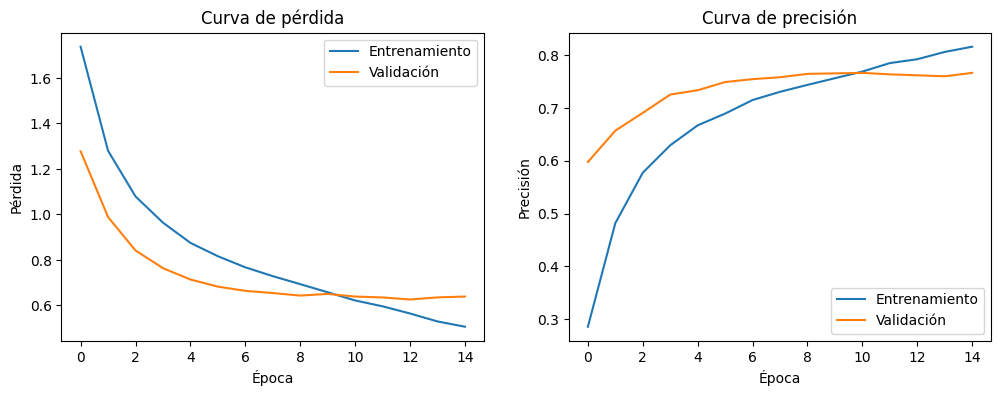

In [24]:
import matplotlib.pyplot as plt


train_loss = history7.history['loss']
val_loss = history7.history['val_loss']
train_accuracy = history7.history['accuracy']
val_accuracy = history7.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 8 Bert + Ngram CNN - 128 filters - 4 layers 77.73%

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(128,5,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model10 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model10.layers[2].trainable=False

model10.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model10.summary()

history10 = model10.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model10.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model10.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 10s 393ms/step
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       110
           1       0.71      0.65      0.68       110
           2       0.80      0.86      0.83       109
           3       0.84      0.92      0.88       109
           4       0.77      0.75      0.76       110

    accuracy                           0.78       548
   macro avg       0.77      0.78      0.78       548
weighted avg       0.77      0.78      0.78       548

[[ 78  17   4   5   6]
 [ 17  72   8   5   8]
 [  3   3  94   2   7]
 [  1   2   3 100   3]
 [  5   8   8   7  82]]


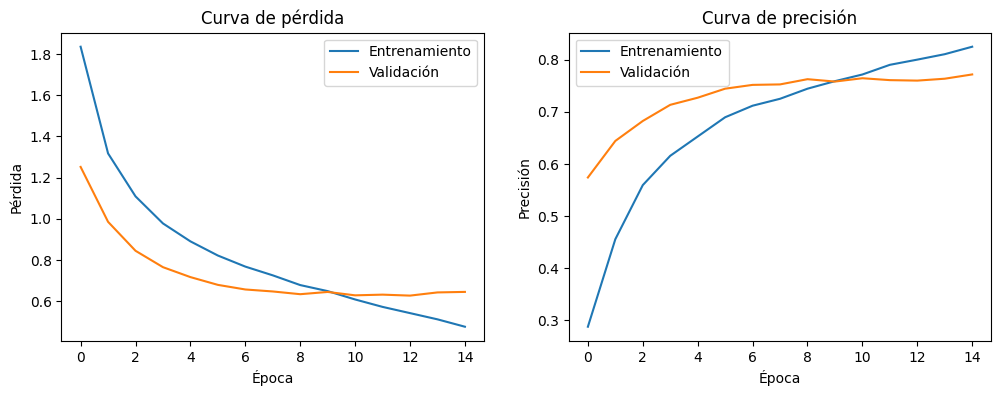

In [26]:
import matplotlib.pyplot as plt


train_loss = history10.history['loss']
val_loss = history10.history['val_loss']
train_accuracy = history10.history['accuracy']
val_accuracy = history10.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 9 Bert + Ngram CNN - 64 filters + Dropout each layer 77.55%

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [28]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(64,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_2 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_3 = tf.keras.layers.Conv1D(64,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_4 = tf.keras.layers.Conv1D(64,5,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
x_4 = tf.keras.layers.Dropout(0.2)(x_4)
merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model11 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model11.layers[2].trainable=False

model11.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model11.summary()

history11 = model11.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model11.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_9[0][0]',                
                                thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model11.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 11s 398ms/step
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       110
           1       0.74      0.69      0.71       110
           2       0.83      0.88      0.86       109
           3       0.86      0.90      0.88       109
           4       0.76      0.71      0.73       110

    accuracy                           0.78       548
   macro avg       0.77      0.78      0.77       548
weighted avg       0.77      0.78      0.77       548

[[77 16  3  5  9]
 [21 76  4  2  7]
 [ 3  2 96  2  6]
 [ 2  1  5 98  3]
 [10  8  7  7 78]]


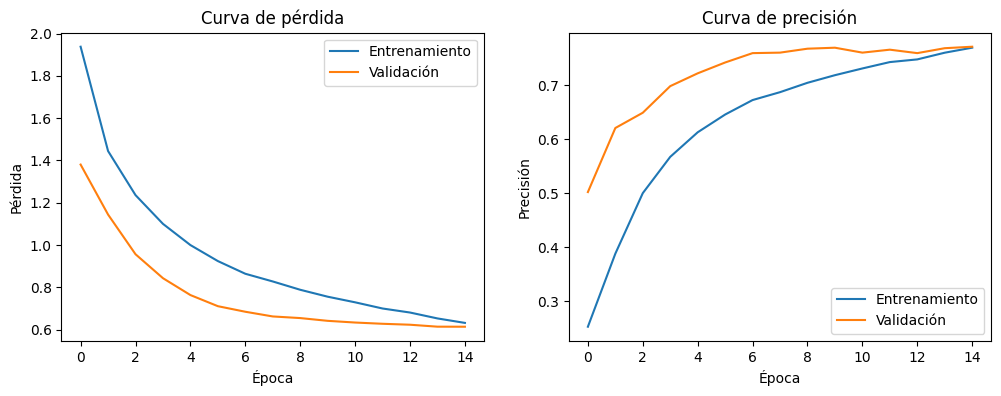

In [30]:
import matplotlib.pyplot as plt


train_loss = history11.history['loss']
val_loss = history11.history['val_loss']
train_accuracy = history11.history['accuracy']
val_accuracy = history11.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 10 Bert + Ngram CNN - 128 filters + Dropout each layer 78.10%

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [32]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_4 = tf.keras.layers.Conv1D(128,5,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
x_4 = tf.keras.layers.Dropout(0.2)(x_4)
merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.4)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model12 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model12.layers[2].trainable=False

model12.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model12.summary()

history12 = model12.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model12.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_11[0][0]',               
                                thPoolingAndCrossAt               'input_12[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model12.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 9s 392ms/step
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       110
           1       0.72      0.69      0.71       110
           2       0.80      0.84      0.82       109
           3       0.86      0.91      0.88       109
           4       0.78      0.74      0.76       110

    accuracy                           0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

[[80 18  4  3  5]
 [16 76  7  2  9]
 [ 6  1 92  5  5]
 [ 2  2  2 99  4]
 [ 5  8 10  6 81]]


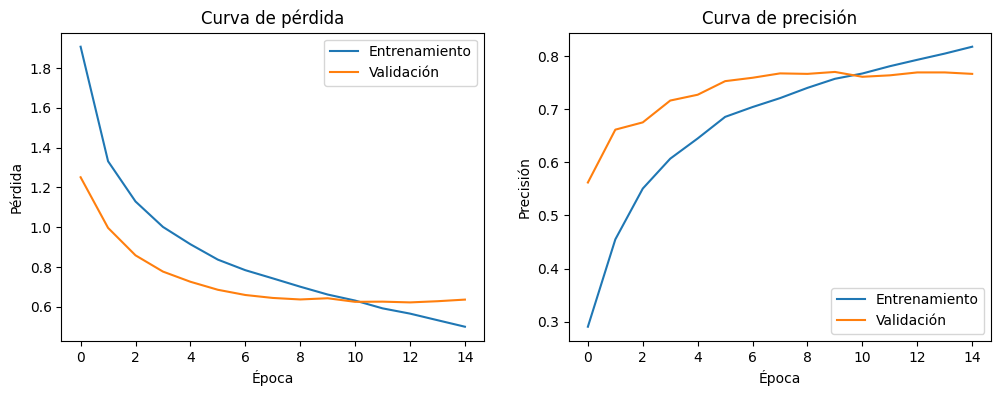

In [33]:
import matplotlib.pyplot as plt


train_loss = history12.history['loss']
val_loss = history12.history['val_loss']
train_accuracy = history12.history['accuracy']
val_accuracy = history12.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 11 Bert + Ngram CNN - 32 filters + Dropout each layer - 4 layers 78.10%

In [19]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [20]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(32,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_2 = tf.keras.layers.Conv1D(32,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_3 = tf.keras.layers.Conv1D(32,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_4 = tf.keras.layers.Conv1D(32,5,padding='same', activation='relu')(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)
x_4 = tf.keras.layers.Dropout(0.2)(x_4)
merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model13 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model13.layers[2].trainable=False

model13.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model13.summary()

history13 = model13.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=20,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model13.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model13.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 10s 396ms/step
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       110
           1       0.70      0.67      0.69       110
           2       0.88      0.86      0.87       109
           3       0.81      0.92      0.86       109
           4       0.76      0.74      0.75       110

    accuracy                           0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

[[ 79  16   2   6   7]
 [ 19  74   5   4   8]
 [  4   3  94   3   5]
 [  0   3   0 100   6]
 [  3  10   6  10  81]]


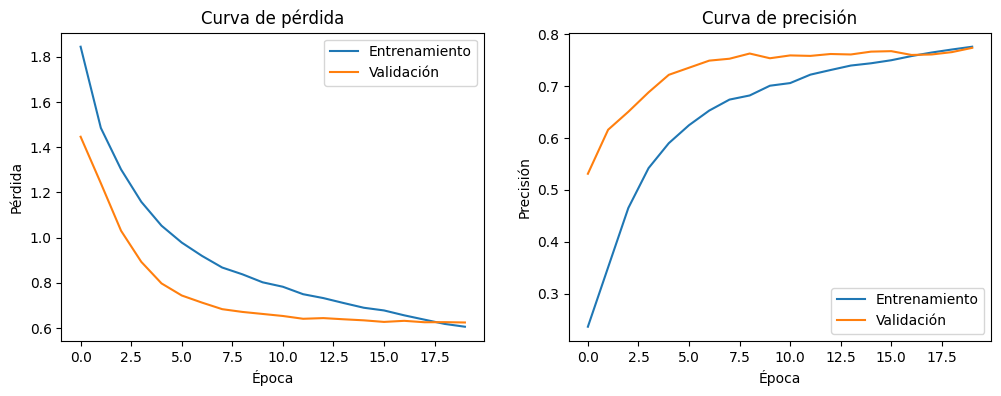

In [22]:
import matplotlib.pyplot as plt


train_loss = history13.history['loss']
val_loss = history13.history['val_loss']
train_accuracy = history13.history['accuracy']
val_accuracy = history13.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 12 Bert + Ngram CNN - 128 filters - 128 batch_size - Other learning rate (1e-5) 60.58%

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [24]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model18 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model18.layers[2].trainable=False

model18.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model18.summary()

history18 = model18.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=20,
    callbacks = [early_stopping], batch_size=128, shuffle=True
)

print(model18.evaluate([input_ids_test, attention_mask_test], labels_test))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model18.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 10s 400ms/step
              precision    recall  f1-score   support

           0       0.56      0.37      0.45       110
           1       0.49      0.70      0.58       110
           2       0.74      0.61      0.67       109
           3       0.66      0.79      0.72       109
           4       0.62      0.55      0.58       110

    accuracy                           0.61       548
   macro avg       0.62      0.61      0.60       548
weighted avg       0.62      0.61      0.60       548

[[41 51  4  5  9]
 [17 77  4  5  7]
 [ 6 14 67 14  8]
 [ 1  3  5 86 14]
 [ 8 11 10 20 61]]


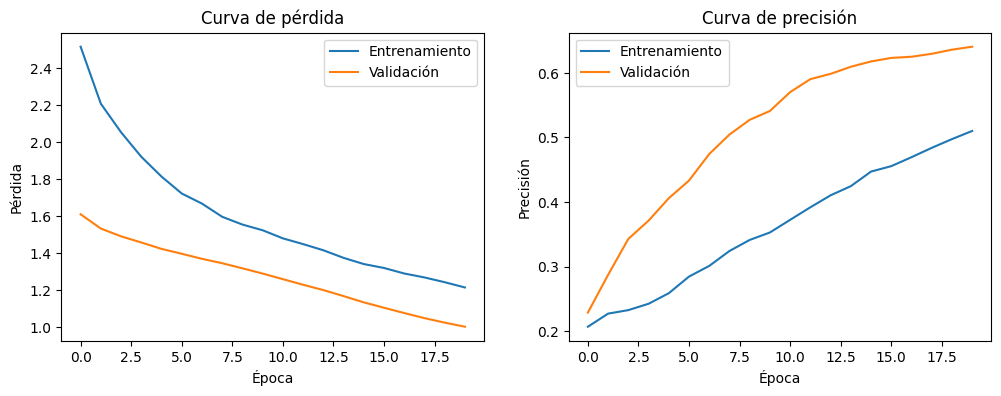

In [26]:
import matplotlib.pyplot as plt


train_loss = history18.history['loss']
val_loss = history18.history['val_loss']
train_accuracy = history18.history['accuracy']
val_accuracy = history18.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 13 Bert + Ngram CNN - 32 filters - Other learning rate (1e-5) 64.05%

In [30]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(32,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(32,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(32,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model19 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model19.layers[2].trainable=False

model19.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model19.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_9[0][0]',                
                                thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [31]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/CNN/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/CNN/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/CNN/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/CNN/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
history19 = model19.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64
)

print(model19.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
240/240 [==============================] - ETA: 0s - loss: 1.9381 - accuracy: 0.2014 - recall_4: 0.0570
Epoch 1: val_accuracy improved from -inf to 0.22810, saving model to model/BERTHugginfFace/CNN/64batch\BERT_CNN_model_best_01_val_0.2281.h5
240/240 [==============================] - 257s 1s/step - loss: 1.9381 - accuracy: 0.2014 - recall_4: 0.0570 - val_loss: 1.5963 - val_accuracy: 0.2281 - val_recall_4: 0.0000e+00
Epoch 2/20
240/240 [==============================] - ETA: 0s - loss: 1.8008 - accuracy: 0.2131 - recall_4: 0.0421
Epoch 2: val_accuracy improved from 0.22810 to 0.27828, saving model to model/BERTHugginfFace/CNN/64batch\BERT_CNN_model_best_02_val_0.2783.h5
240/240 [==============================] - 244s 1s/step - loss: 1.8008 - accuracy: 0.2131 - recall_4: 0.0421 - val_loss: 1.5632 - val_accuracy: 0.2783 - val_recall_4: 0.0000e+00
Epoch 3/20
240/240 [==============================] - ETA: 0s - loss: 1.7218 - accuracy: 0.2280 - recall_4: 0.0303
Epoch 3: val_acc

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

y_true  = np.argmax(labels_test, axis=-1)
y_pred = model19.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 10s 390ms/step
              precision    recall  f1-score   support

           0       0.57      0.60      0.58       110
           1       0.59      0.52      0.55       110
           2       0.71      0.66      0.68       109
           3       0.72      0.81      0.76       109
           4       0.62      0.62      0.62       110

    accuracy                           0.64       548
   macro avg       0.64      0.64      0.64       548
weighted avg       0.64      0.64      0.64       548

[[66 25  4  5 10]
 [31 57 10  4  8]
 [ 6  8 72 12 11]
 [ 2  0  6 88 13]
 [11  7 10 14 68]]


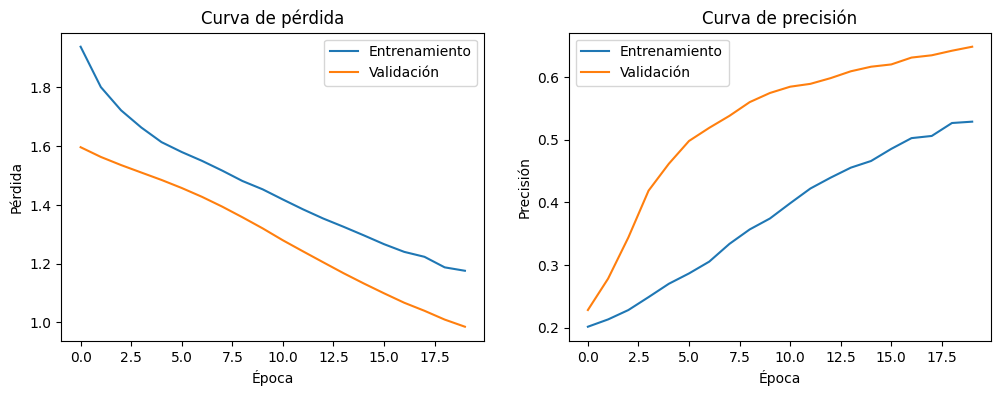

In [34]:
import matplotlib.pyplot as plt


train_loss = history19.history['loss']
val_loss = history19.history['val_loss']
train_accuracy = history19.history['accuracy']
val_accuracy = history19.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 14 Bert + Ngram CNN - 100 filters

In [112]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(100,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(100,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(100,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model21 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model21.layers[2].trainable=False

model21.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model21.summary()


Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_51 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_50[0][0]',               
                                thPoolingAndCrossAt               'input_51[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [113]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/CNN3/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/CNN3/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/CNN3/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/CNN3/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [114]:
history21 = model21.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=32, shuffle=True
)


Epoch 1/15
479/479 [==============================] - ETA: 0s - loss: 1.6183 - accuracy: 0.3454 - recall_24: 0.1333
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to model/BERTHugginfFace/CNN3/64batch\BERT_CNN_model_best_01_val_0.6250.h5
479/479 [==============================] - 252s 507ms/step - loss: 1.6183 - accuracy: 0.3454 - recall_24: 0.1333 - val_loss: 1.0514 - val_accuracy: 0.6250 - val_recall_24: 0.2746
Epoch 2/15
479/479 [==============================] - ETA: 0s - loss: 1.1150 - accuracy: 0.5541 - recall_24: 0.3598
Epoch 2: val_accuracy improved from 0.62500 to 0.70438, saving model to model/BERTHugginfFace/CNN3/64batch\BERT_CNN_model_best_02_val_0.7044.h5
479/479 [==============================] - 239s 499ms/step - loss: 1.1150 - accuracy: 0.5541 - recall_24: 0.3598 - val_loss: 0.8046 - val_accuracy: 0.7044 - val_recall_24: 0.5547
Epoch 3/15
479/479 [==============================] - ETA: 0s - loss: 0.9176 - accuracy: 0.6456 - recall_24: 0.5137
Epoch 3: 

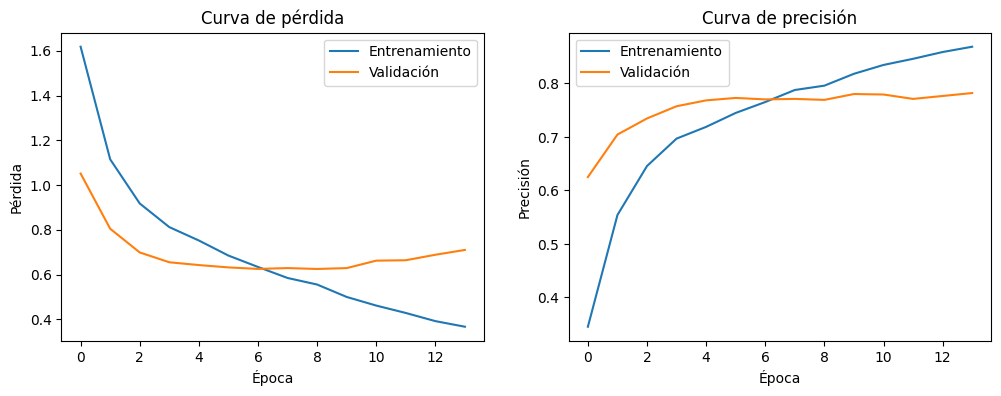

In [121]:
import matplotlib.pyplot as plt


train_loss = history21.history['loss']
val_loss = history21.history['val_loss']
train_accuracy = history21.history['accuracy']
val_accuracy = history21.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 15 Bert + CNN + N Gram (128 filters) - 128 batch_size (mejor encontrado bert 78% testeo) 78.10%

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output) #Enter the output to Trigram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output) #Enter the output to FourGram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout) #Output layer
model24 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

model24.layers[2].trainable=False #Pre-trained layers set to False

model24.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
model24.summary()



Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_58[0][0]',               
                                thPoolingAndCrossAt               'input_59[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test2/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test2/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test2/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

#--------------------------------------------------------------------------------
history24 = model24.fit( #Training the model
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
120/120 [==============================] - ETA: 0s - loss: 1.9517 - accuracy: 0.2659 - recall_28: 0.1161
Epoch 1: val_accuracy improved from -inf to 0.57573, saving model to model/BERTHugginfFace/Test2/64batch\BERT_CNN_model_best_01_val_0.5757.h5
120/120 [==============================] - 337s 3s/step - loss: 1.9517 - accuracy: 0.2659 - recall_28: 0.1161 - val_loss: 1.2966 - val_accuracy: 0.5757 - val_recall_28: 0.0374
Epoch 2/15
120/120 [==============================] - ETA: 0s - loss: 1.3871 - accuracy: 0.4180 - recall_28: 0.1688
Epoch 2: val_accuracy improved from 0.57573 to 0.64325, saving model to model/BERTHugginfFace/Test2/64batch\BERT_CNN_model_best_02_val_0.6432.h5
120/120 [==============================] - 318s 3s/step - loss: 1.3871 - accuracy: 0.4180 - recall_28: 0.1688 - val_loss: 1.0463 - val_accuracy: 0.6432 - val_recall_28: 0.2746
Epoch 3/15
120/120 [===================

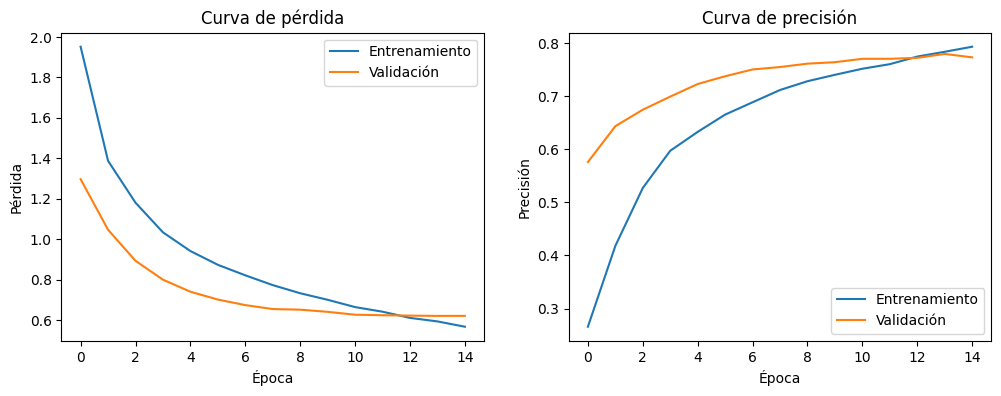

In [127]:
import matplotlib.pyplot as plt


train_loss = history24.history['loss']
val_loss = history24.history['val_loss']
train_accuracy = history24.history['accuracy']
val_accuracy = history24.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [ ]:
def custom_objects_fn():
    return {'TFBertModel':TFBertModel}

#Validation model
model_load = load_model(r'model\BERTHugginfFace\Test2\64batch\BERT_CNN_model_best_14_val_0.7792.h5', custom_objects=custom_objects_fn())
model_load.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_59 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_58[0][0]',               
                                thPoolingAndCrossAt               'input_59[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [151]:
model_load.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 11s 399ms/step - loss: 0.6314 - accuracy: 0.7810 - recall_28: 0.7135


[0.6314436793327332, 0.7810218930244446, 0.7135036587715149]

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test, axis=-1)
y_pred = model_load.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)





18/18 [==============================] - 7s 388ms/step
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       110
           1       0.70      0.66      0.68       110
           2       0.86      0.88      0.87       109
           3       0.88      0.91      0.90       109
           4       0.74      0.76      0.75       110

    accuracy                           0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

[[76 20  2  4  8]
 [19 73  6  3  9]
 [ 4  1 96  2  6]
 [ 0  2  2 99  6]
 [ 7  9  6  4 84]]


In [22]:
np.unique(y_true)

array([0, 1, 2, 3, 4], dtype=int64)

Text(95.72222222222221, 0.5, 'True')

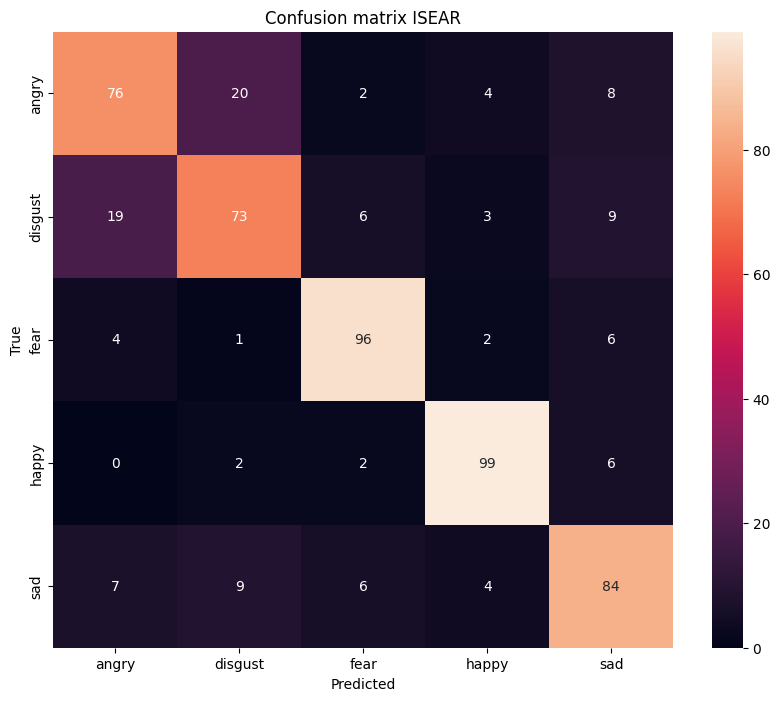

In [24]:
plt.figure(figsize=(10,8))

class_names = ['angry','disgust','fear','happy','sad']

sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix ISEAR')
plt.xlabel('Predicted')
plt.ylabel('True')

### Model 16 Bert + CNN + N Gram (128 filters) - 64 batch_size 78.28%

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output) #Enter the output to Trigram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output) #Enter the output to FourGram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout) #Output layer
model25 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model
 
model25.layers[2].trainable=False #Pre-trained layers set to False

model25.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
model25.summary()



Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_61 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_60[0][0]',               
                                thPoolingAndCrossAt               'input_61[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test3/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test3/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test3/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test3/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

#--------------------------------------------------------------------------------
history25 = model25.fit( #Training the model
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)

#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
240/240 [==============================] - ETA: 0s - loss: 1.7041 - accuracy: 0.3096 - recall_29: 0.1169
Epoch 1: val_accuracy improved from -inf to 0.59763, saving model to model/BERTHugginfFace/Test3/64batch\BERT_CNN_model_best_01_val_0.5976.h5
240/240 [==============================] - 343s 1s/step - loss: 1.7041 - accuracy: 0.3096 - recall_29: 0.1169 - val_loss: 1.1839 - val_accuracy: 0.5976 - val_recall_29: 0.1387
Epoch 2/15
240/240 [==============================] - ETA: 0s - loss: 1.2290 - accuracy: 0.5034 - recall_29: 0.2716
Epoch 2: val_accuracy improved from 0.59763 to 0.67427, saving model to model/BERTHugginfFace/Test3/64batch\BERT_CNN_model_best_02_val_0.6743.h5
240/240 [==============================] - 324s 1s/step - loss: 1.2290 - accuracy: 0.5034 - recall_29: 0.2716 - val_loss: 0.8950 - val_accuracy: 0.6743 - val_recall_29: 0.4535
Epoch 3/15
240/240 [===================

In [ ]:
def custom_objects_fn():
    return {'TFBertModel':TFBertModel}

#validation model
model_load = load_model(r'model\BERTHugginfFace\Test3\BERT_CNN_model_best_09_val_0.7710.h5', custom_objects=custom_objects_fn())
model_load.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 11s 403ms/step - loss: 0.6349 - accuracy: 0.7828 - recall_29: 0.7080


[0.6348779797554016, 0.7828466892242432, 0.7080292105674744]

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test, axis=-1)
y_pred = model_load.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 17s 401ms/step
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       110
           1       0.71      0.68      0.70       110
           2       0.87      0.83      0.85       109
           3       0.86      0.94      0.89       109
           4       0.73      0.75      0.74       110

    accuracy                           0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

[[ 78  17   2   4   9]
 [ 18  75   5   3   9]
 [  4   3  91   3   8]
 [  0   1   2 102   4]
 [  6   9   5   7  83]]


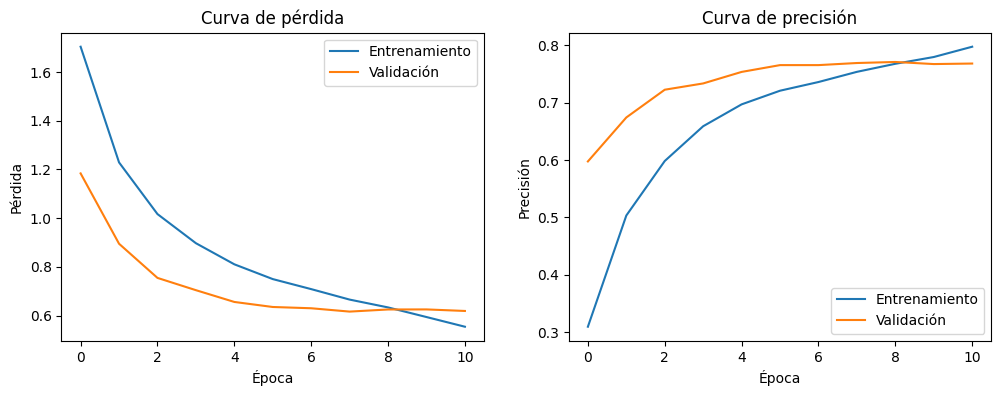

In [130]:
import matplotlib.pyplot as plt


train_loss = history25.history['loss']
val_loss = history25.history['val_loss']
train_accuracy = history25.history['accuracy']
val_accuracy = history25.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 17 Bert + CNN + N Gram (128 filters) - 32 batch_size 77.18%

In [131]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model26 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model26.layers[2].trainable=False

model26.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model26.summary()


Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_63 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_62[0][0]',               
                                thPoolingAndCrossAt               'input_63[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [132]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test4/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test4/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test4/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test4/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
history26 = model26.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=32, shuffle=True
)

#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
479/479 [==============================] - ETA: 0s - loss: 1.6063 - accuracy: 0.3481 - recall_30: 0.1517
Epoch 1: val_accuracy improved from -inf to 0.61405, saving model to model/BERTHugginfFace/Test4/64batch\BERT_CNN_model_best_01_val_0.6141.h5
479/479 [==============================] - 324s 662ms/step - loss: 1.6063 - accuracy: 0.3481 - recall_30: 0.1517 - val_loss: 1.0418 - val_accuracy: 0.6141 - val_recall_30: 0.3148
Epoch 2/15
479/479 [==============================] - ETA: 0s - loss: 1.0980 - accuracy: 0.5647 - recall_30: 0.3808
Epoch 2: val_accuracy improved from 0.61405 to 0.70255, saving model to model/BERTHugginfFace/Test4/64batch\BERT_CNN_model_best_02_val_0.7026.h5
479/479 [==============================] - 314s 654ms/step - loss: 1.0980 - accuracy: 0.5647 - recall_30: 0.3808 - val_loss: 0.7871 - val_accuracy: 0.7026 - val_recall_30: 0.5794
Epoch 3/15
479/479 [=============

In [21]:
def custom_objects_fn():
    return {'TFBertModel':TFBertModel}

model_load2 = load_model(r'model\BERTHugginfFace\Test4\BERT_CNN_model_best_10_val_0.7755.h5', custom_objects=custom_objects_fn())
model_load2.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 11s 404ms/step - loss: 0.6630 - accuracy: 0.7719 - recall_30: 0.7226


[0.663031280040741, 0.7718977928161621, 0.7226277589797974]

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test, axis=-1)
y_pred = model_load2.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 11s 402ms/step
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       110
           1       0.69      0.72      0.71       110
           2       0.84      0.86      0.85       109
           3       0.84      0.90      0.87       109
           4       0.74      0.71      0.72       110

    accuracy                           0.77       548
   macro avg       0.77      0.77      0.77       548
weighted avg       0.77      0.77      0.77       548

[[74 20  3  4  9]
 [17 79  4  2  8]
 [ 3  2 94  3  7]
 [ 0  3  4 98  4]
 [ 6 10  7  9 78]]


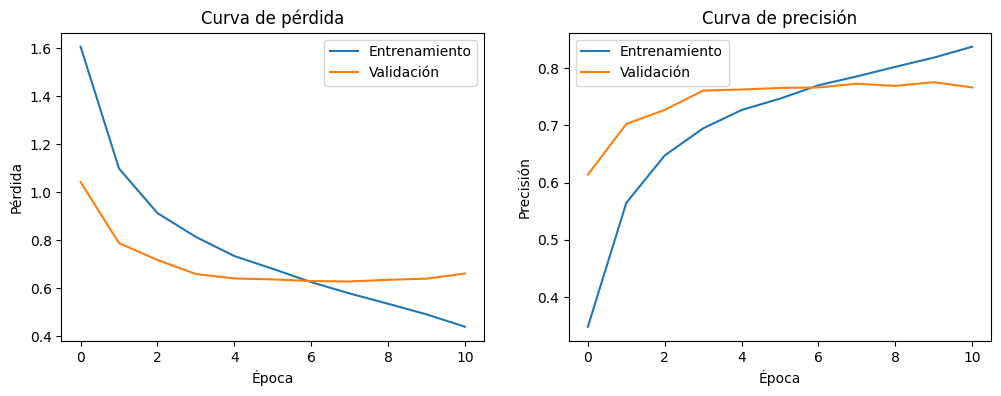

In [133]:
import matplotlib.pyplot as plt


train_loss = history26.history['loss']
val_loss = history26.history['val_loss']
train_accuracy = history26.history['accuracy']
val_accuracy = history26.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Model 18 Bert + CNN + N Gram (256 filters) - 64 batch_size - Repeat 1 layer 77.73%

In [143]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(256,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(256,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(256,3,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model28 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model28.layers[2].trainable=False

model28.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model28.summary()


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_71 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_70[0][0]',               
                                thPoolingAndCrossAt               'input_71[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [144]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test6/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test6/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test6/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test6/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
history28 = model28.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
240/240 [==============================] - ETA: 0s - loss: 1.7580 - accuracy: 0.3096 - recall_34: 0.1249
Epoch 1: val_accuracy improved from -inf to 0.59307, saving model to model/BERTHugginfFace/Test6/64batch\BERT_CNN_model_best_01_val_0.5931.h5
240/240 [==============================] - 347s 1s/step - loss: 1.7580 - accuracy: 0.3096 - recall_34: 0.1249 - val_loss: 1.2419 - val_accuracy: 0.5931 - val_recall_34: 0.0912
Epoch 2/15
240/240 [==============================] - ETA: 0s - loss: 1.2497 - accuracy: 0.4894 - recall_34: 0.2764
Epoch 2: val_accuracy improved from 0.59307 to 0.65785, saving model to model/BERTHugginfFace/Test6/64batch\BERT_CNN_model_best_02_val_0.6578.h5
240/240 [==============================] - 330s 1s/step - loss: 1.2497 - accuracy: 0.4894 - recall_34: 0.2764 - val_loss: 0.9104 - val_accuracy: 0.6578 - val_recall_34: 0.4279
Epoch 3/15
240/240 [===================

In [23]:
def custom_objects_fn():
    return {'TFBertModel':TFBertModel}

model_load3 = load_model(r'model\BERTHugginfFace\Test6\BERT_CNN_model_best_11_val_0.7783.h5', custom_objects=custom_objects_fn())
model_load3.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 11s 406ms/step - loss: 0.6580 - accuracy: 0.7774 - recall_34: 0.7263


[0.6580228209495544, 0.7773722410202026, 0.7262773513793945]

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test, axis=-1)
y_pred = model_load3.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 10s 406ms/step
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       110
           1       0.74      0.69      0.71       110
           2       0.88      0.83      0.86       109
           3       0.83      0.93      0.88       109
           4       0.70      0.75      0.72       110

    accuracy                           0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

[[ 76  17   2   5  10]
 [ 16  76   5   3  10]
 [  4   2  91   3   9]
 [  0   1   1 101   6]
 [  8   7   4   9  82]]


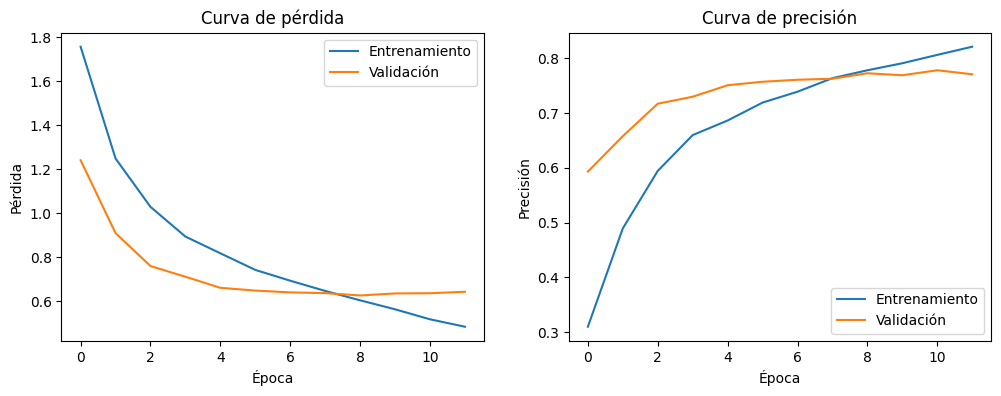

In [145]:
import matplotlib.pyplot as plt


train_loss = history28.history['loss']
val_loss = history28.history['val_loss']
train_accuracy = history28.history['accuracy']
val_accuracy = history28.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [152]:
def custom_objects_fn():
    return {'TFBertModel':TFBertModel}

model_load2 = load_model(r'model\BERTHugginfFace\Test6\64batch\BERT_CNN_model_best_11_val_0.7783.h5', custom_objects=custom_objects_fn())
model_load2.summary()

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_71 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_70[0][0]',               
                                thPoolingAndCrossAt               'input_71[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [153]:
model_load2.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 11s 402ms/step - loss: 0.6580 - accuracy: 0.7774 - recall_34: 0.7263


[0.6580227017402649, 0.7773722410202026, 0.7262773513793945]

### Model 19 Bert + CNN + N Gram (256 filters) - 64 batch_size 76.45%

In [146]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(256,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(256,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(256,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(256, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
model29 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model29.layers[2].trainable=False

model29.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
model29.summary()

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_72 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_73 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_72[0][0]',               
                                thPoolingAndCrossAt               'input_73[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [147]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/Test7/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/Test7/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/Test7/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/Test7/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
history29 = model29.fit(
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
240/240 [==============================] - ETA: 0s - loss: 1.7304 - accuracy: 0.3025 - recall_35: 0.1010
Epoch 1: val_accuracy improved from -inf to 0.58303, saving model to model/BERTHugginfFace/Test7/64batch\BERT_CNN_model_best_01_val_0.5830.h5
240/240 [==============================] - 347s 1s/step - loss: 1.7304 - accuracy: 0.3025 - recall_35: 0.1010 - val_loss: 1.3501 - val_accuracy: 0.5830 - val_recall_35: 0.0155
Epoch 2/15
240/240 [==============================] - ETA: 0s - loss: 1.2782 - accuracy: 0.4720 - recall_35: 0.2457
Epoch 2: val_accuracy improved from 0.58303 to 0.64872, saving model to model/BERTHugginfFace/Test7/64batch\BERT_CNN_model_best_02_val_0.6487.h5
240/240 [==============================] - 330s 1s/step - loss: 1.2782 - accuracy: 0.4720 - recall_35: 0.2457 - val_loss: 0.9615 - val_accuracy: 0.6487 - val_recall_35: 0.3850
Epoch 3/15
240/240 [===================

In [17]:
def custom_objects_fn():
    return {'TFBertModel':TFBertModel}

model_load4 = load_model(r'model/BERTHugginfFace/Test7\BERT_CNN_model_best_10_val_0.7728.h5', custom_objects=custom_objects_fn())
model_load4.evaluate([input_ids_test, attention_mask_test], labels_test)

18/18 [==============================] - 14s 412ms/step - loss: 0.6590 - accuracy: 0.7646 - recall_35: 0.7135


[0.6590156555175781, 0.764598548412323, 0.7135036587715149]

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test, axis=-1)
y_pred = model_load4.predict([input_ids_test, attention_mask_test])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 11s 408ms/step
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       110
           1       0.69      0.68      0.69       110
           2       0.80      0.83      0.82       109
           3       0.87      0.89      0.88       109
           4       0.74      0.72      0.73       110

    accuracy                           0.76       548
   macro avg       0.76      0.76      0.76       548
weighted avg       0.76      0.76      0.76       548

[[77 19  3  4  7]
 [18 75  6  2  9]
 [ 4  4 91  2  8]
 [ 1  1  6 97  4]
 [ 8  9  8  6 79]]


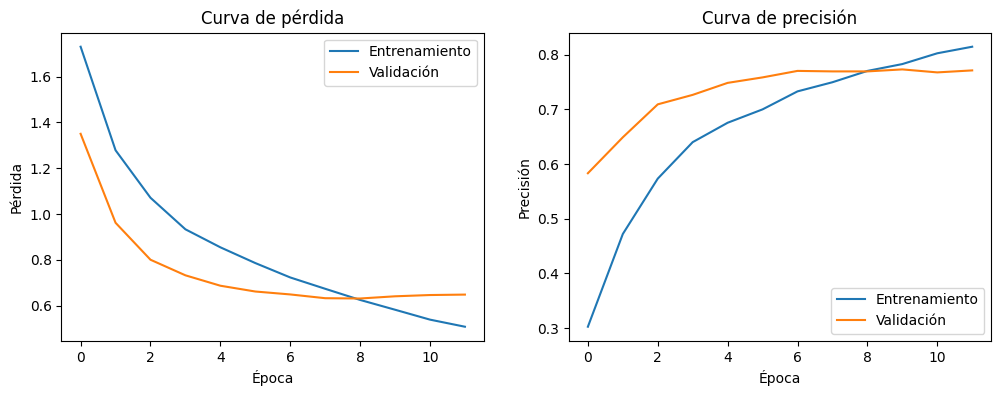

In [148]:
import matplotlib.pyplot as plt


train_loss = history29.history['loss']
val_loss = history29.history['val_loss']
train_accuracy = history29.history['accuracy']
val_accuracy = history29.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Models test with Roberta - best model 78.64%

### 128 batch (mejor encontrado 78.64% testeo)

- The best model is obtained with 78.64% using RoBERTa and 128 batch. In addition, the N-Gram

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output) #Enter the output to Trigram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output) #Enter the output to Fourgram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout) #Output layer
modelTestRoberta = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

modelTestRoberta.layers[2].trainable=False #Pre-trained layers set to False

modelTestRoberta.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
modelTestRoberta.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_5[0][0]',                
 el)                            thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

#--------------------------------------------------------------------------------
historyRoberta = modelTestRoberta.fit( #Training the model
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 2.0542 - accuracy: 0.2339 - recall_2: 0.0989
Epoch 1: val_accuracy improved from -inf to 0.46350, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch\BERT_CNN_model_best_01_val_0.4635.h5
120/120 [==============================] - 287s 2s/step - loss: 2.0542 - accuracy: 0.2339 - recall_2: 0.0989 - val_loss: 1.5088 - val_accuracy: 0.4635 - val_recall_2: 0.0000e+00
Epoch 2/20
120/120 [==============================] - ETA: 0s - loss: 1.6049 - accuracy: 0.2943 - recall_2: 0.0463
Epoch 2: val_accuracy improved from 0.46350 to 0.53011, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch\BERT_CNN_model_best_02_val_0.5301.h5
120/120 [==============================] - 257s 2s/step - loss: 1.6049 - accuracy: 0.2943 - recall_2: 0.0463 - val_loss

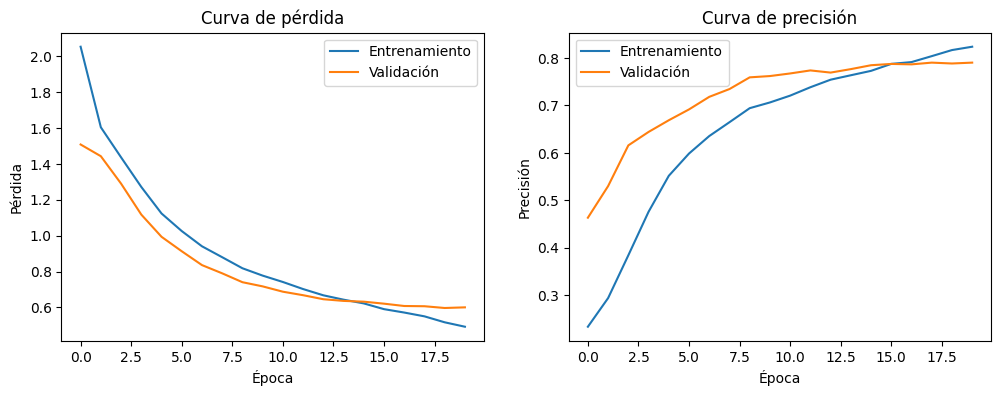

In [39]:
import matplotlib.pyplot as plt


train_loss = historyRoberta.history['loss']
val_loss = historyRoberta.history['val_loss']
train_accuracy = historyRoberta.history['accuracy']
val_accuracy = historyRoberta.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [ ]:
modelTestRoberta.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta) #Validation model

18/18 [==============================] - 11s 573ms/step - loss: 0.6120 - accuracy: 0.7865 - recall_2: 0.6989


[0.6119632124900818, 0.7864963412284851, 0.6989051103591919]

In [ ]:
modelTestRoberta.save('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batch/BERT_CNN_model_best_20_val_0.7901_best.h5') #save model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test, axis=-1)
y_pred = modelTestRoberta.predict([input_ids_test_roberta, attention_mask_test_roberta])
y_pred = np.argmax(y_pred, axis=-1)

#validation model
report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)


18/18 [==============================] - 11s 568ms/step
              precision    recall  f1-score   support

           0       0.72      0.77      0.75       110
           1       0.78      0.67      0.72       110
           2       0.84      0.82      0.83       109
           3       0.87      0.93      0.90       109
           4       0.73      0.75      0.74       110

    accuracy                           0.79       548
   macro avg       0.79      0.79      0.79       548
weighted avg       0.79      0.79      0.79       548

[[ 85  15   2   0   8]
 [ 20  74   6   3   7]
 [  3   1  89   6  10]
 [  1   0   1 101   6]
 [  9   5   8   6  82]]


Text(95.72222222222221, 0.5, 'True')

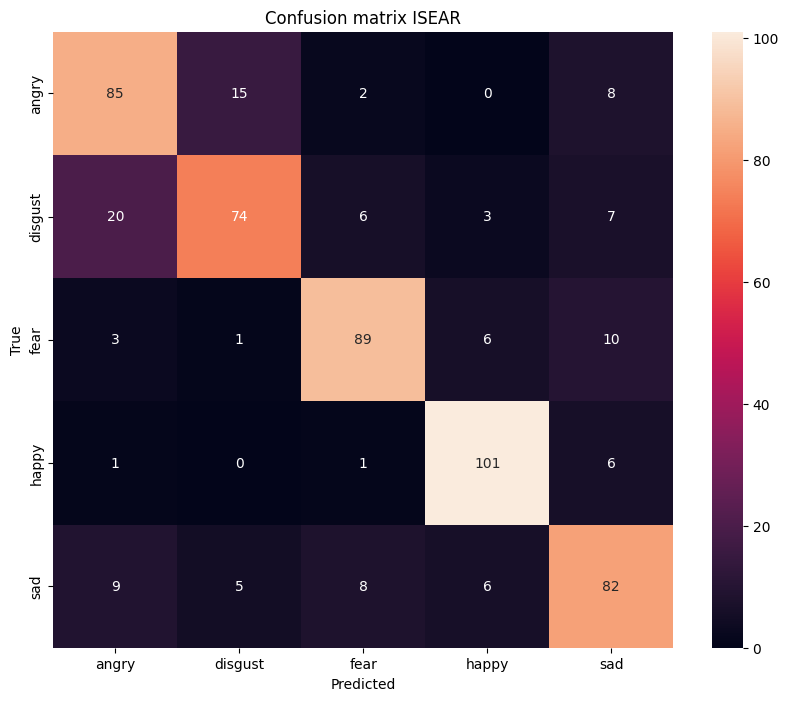

In [47]:
plt.figure(figsize=(10,8))

class_names = ['angry','disgust','fear','happy','sad']

sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix ISEAR')
plt.xlabel('Predicted')
plt.ylabel('True')

### 64 batch 77.73%

In [48]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
modelTestRoberta2 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta2.layers[2].trainable=False

modelTestRoberta2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta2.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_7[0][0]',                
 el)                            thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [50]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRoberta2 = modelTestRoberta2.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
240/240 [==============================] - ETA: 0s - loss: 1.9441 - accuracy: 0.2342 - recall_3: 0.0741
Epoch 1: val_accuracy improved from -inf to 0.45985, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch\BERT_CNN_model_best_01_val_0.4599.h5
240/240 [==============================] - 298s 1s/step - loss: 1.9441 - accuracy: 0.2342 - recall_3: 0.0741 - val_loss: 1.5233 - val_accuracy: 0.4599 - val_recall_3: 0.0000e+00
Epoch 2/20
240/240 [==============================] - ETA: 0s - loss: 1.5147 - accuracy: 0.3395 - recall_3: 0.0457
Epoch 2: val_accuracy improved from 0.45985 to 0.58212, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch\BERT_CNN_model_best_02_val_0.5821.h5
240/240 [==============================] - 325s 1s/step - loss: 1.5147 - accuracy: 0.3395 - recall_3: 0.0457 - val_loss: 

In [16]:
def custom_objects_fn():
    return {'TFRobertaModel':TFRobertaModel}

model_load5 = load_model(r'model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3\BERT_CNN_model_best_15_val_0.7938.h5', custom_objects=custom_objects_fn())
model_load5.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)

18/18 [==============================] - 13s 402ms/step - loss: 0.6108 - accuracy: 0.7774 - recall_3: 0.7080


[0.6108262538909912, 0.7773722410202026, 0.7080292105674744]

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test_roberta, axis=-1)
y_pred = model_load5.predict([input_ids_test_roberta, attention_mask_test_roberta])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 10s 393ms/step
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       110
           1       0.75      0.67      0.71       110
           2       0.81      0.83      0.82       109
           3       0.85      0.92      0.88       109
           4       0.75      0.72      0.73       110

    accuracy                           0.78       548
   macro avg       0.78      0.78      0.78       548
weighted avg       0.78      0.78      0.78       548

[[ 82  16   3   1   8]
 [ 17  74   8   3   8]
 [  4   3  91   5   6]
 [  1   1   2 100   5]
 [  9   5   9   8  79]]


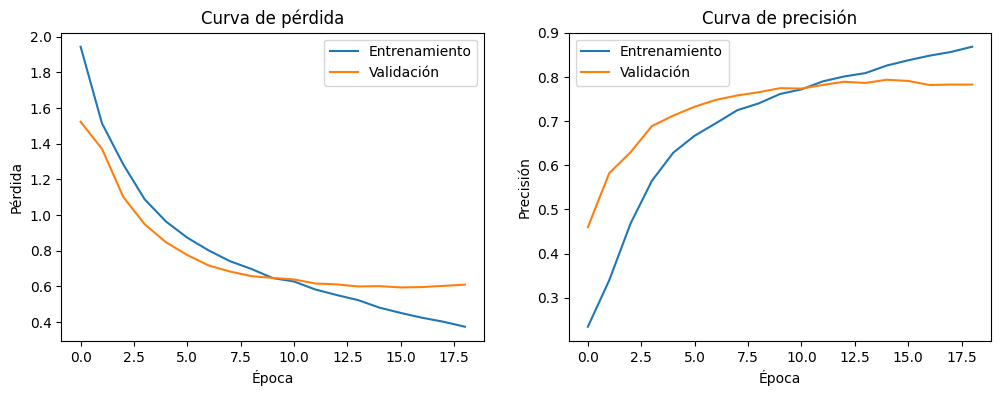

In [51]:
import matplotlib.pyplot as plt


train_loss = historyRoberta2.history['loss']
val_loss = historyRoberta2.history['val_loss']
train_accuracy = historyRoberta2.history['accuracy']
val_accuracy = historyRoberta2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [43]:
def custom_objects_fn_roberta():
    return {'TFRobertaModel': TFRobertaModel}

model_Roberta564_load = tf.keras.models.load_model('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/64batch\BERT_CNN_model_best_15_val_0.7938.h5', custom_objects= custom_objects_fn_roberta())
model_Roberta564_load.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)

18/18 [==============================] - 11s 393ms/step - loss: 0.6108 - accuracy: 0.7774 - recall_3: 0.7080


[0.6108262538909912, 0.7773722410202026, 0.7080292105674744]

### 32 batch 77%

In [52]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
modelTestRoberta3 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta3.layers[2].trainable=False

modelTestRoberta3.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_9[0][0]',                
 el)                            thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [53]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRoberta3 = modelTestRoberta3.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=32, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
479/479 [==============================] - ETA: 0s - loss: 1.7879 - accuracy: 0.2623 - recall_4: 0.0652
Epoch 1: val_accuracy improved from -inf to 0.54471, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch\BERT_CNN_model_best_01_val_0.5447.h5
479/479 [==============================] - 349s 701ms/step - loss: 1.7879 - accuracy: 0.2623 - recall_4: 0.0652 - val_loss: 1.4194 - val_accuracy: 0.5447 - val_recall_4: 0.0000e+00
Epoch 2/20
479/479 [==============================] - ETA: 0s - loss: 1.3153 - accuracy: 0.4514 - recall_4: 0.1637
Epoch 2: val_accuracy improved from 0.54471 to 0.64872, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/32batch\BERT_CNN_model_best_02_val_0.6487.h5
479/479 [==============================] - 331s 691ms/step - loss: 1.3153 - accuracy: 0.4514 - recall_4: 0.1637 - val_

In [55]:
load_model3 = load_model(r'model\BERTHugginfFace\OptimizationBestModel\OptimizationBestModel_roberta3\32batch\BERT_CNN_model_best_11_val_0.7965.h5', custom_objects=custom_objects_fn_roberta())
load_model3.summary()

load_model3.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model_3 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_9[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

[0.6084970235824585, 0.7700729966163635, 0.709854006767273]

In [21]:
load_model3 = load_model(r'model\BERTHugginfFace\OptimizationBestModel\OptimizationBestModel_roberta3\32batch\BERT_CNN_model_best_11_val_0.7965.h5', custom_objects=custom_objects_fn())
load_model3.summary()

load_model3.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_9[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

[0.608497142791748, 0.7700729966163635, 0.709854006767273]

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
y_true  = np.argmax(labels_test_roberta, axis=-1)
y_pred = load_model3.predict([input_ids_test_roberta, attention_mask_test_roberta])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true,y_pred)
print(report)

matrix = confusion_matrix(y_true,y_pred)
print(matrix)

18/18 [==============================] - 11s 395ms/step
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       110
           1       0.73      0.68      0.70       110
           2       0.85      0.80      0.82       109
           3       0.85      0.93      0.89       109
           4       0.69      0.76      0.73       110

    accuracy                           0.77       548
   macro avg       0.77      0.77      0.77       548
weighted avg       0.77      0.77      0.77       548

[[ 75  19   1   2  13]
 [ 15  75   7   4   9]
 [  5   4  87   4   9]
 [  1   0   1 101   6]
 [  7   5   6   8  84]]


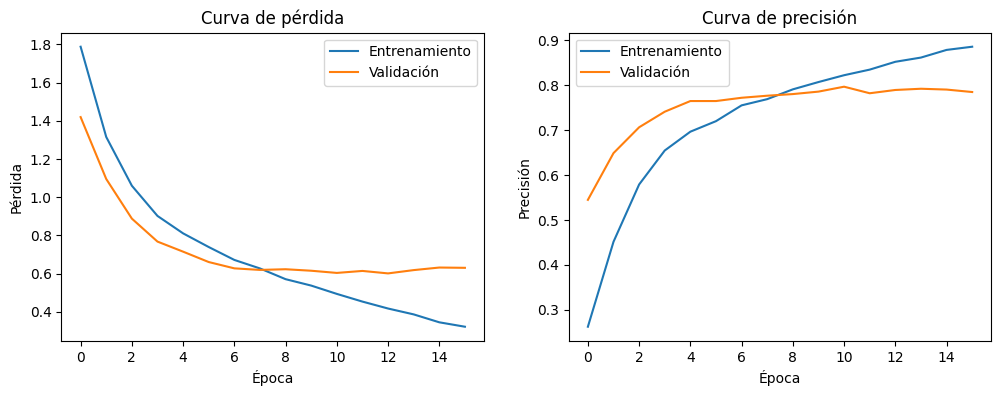

In [54]:
import matplotlib.pyplot as plt


train_loss = historyRoberta3.history['loss']
val_loss = historyRoberta3.history['val_loss']
train_accuracy = historyRoberta3.history['accuracy']
val_accuracy = historyRoberta3.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### 128 batch with more dropout 76.64%

In [16]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(5, activation='softmax')(dropout)
modelTestRobertaDropout_5emotions = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRobertaDropout_5emotions.layers[2].trainable=False

modelTestRobertaDropout_5emotions.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRobertaDropout_5emotions.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [17]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRobertaDropout_5emotions = modelTestRobertaDropout_5emotions.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 2.2777 - accuracy: 0.2224 - recall: 0.1186
Epoch 1: val_accuracy improved from -inf to 0.42153, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout\BERT_CNN_model_best_01_val_0.4215.h5
120/120 [==============================] - 290s 2s/step - loss: 2.2777 - accuracy: 0.2224 - recall: 0.1186 - val_loss: 1.5319 - val_accuracy: 0.4215 - val_recall: 0.0000e+00
Epoch 2/20
120/120 [==============================] - ETA: 0s - loss: 1.6426 - accuracy: 0.2780 - recall: 0.0557
Epoch 2: val_accuracy improved from 0.42153 to 0.52372, saving model to model/BERTHugginfFace/OptimizationBestModel/OptimizationBestModel_roberta3/128batchWithDropout\BERT_CNN_model_best_02_val_0.5237.h5
120/120 [==============================] - 258s 2s/step - loss: 1.6426 - accuracy: 0.2780 - recall: 0.0557 - val_loss: 1.5010 - val_accuracy: 0.5237 - val_recall: 0.0000e+00
Epoch 3/20
120/120 [=

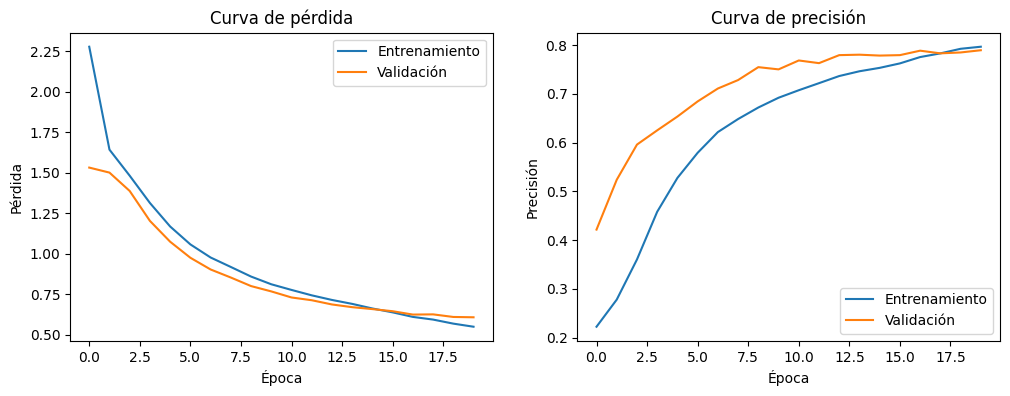

In [18]:
import matplotlib.pyplot as plt


train_loss = historyRobertaDropout_5emotions.history['loss']
val_loss = historyRobertaDropout_5emotions.history['val_loss']
train_accuracy = historyRobertaDropout_5emotions.history['accuracy']
val_accuracy = historyRobertaDropout_5emotions.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [24]:
modelTestRobertaDropout_5emotions.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)

18/18 [==============================] - 7s 397ms/step - loss: 0.6233 - accuracy: 0.7664 - recall: 0.6642


[0.6233377456665039, 0.7664233446121216, 0.6642335653305054]

# With 7 Emotions - 80.70%

## Seed definition

In [ ]:
#SET SEED

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## Isear dataset

In [ ]:
isear = pd.read_excel('ISEAR.xlsx') #Import ISEAR dataset 


print(isear.head())

      ID  CITY  COUN  SUBJ  SEX  AGE  RELI  PRAC  FOCC  MOCC  ...  SELF  RELA  \
0  11001     1     1     1    1   33     1     2     6     1  ...     3     3   
1  11001     1     1     1    1   33     1     2     6     1  ...     2     2   
2  11001     1     1     1    1   33     1     2     6     1  ...     2     1   
3  11001     1     1     1    1   33     1     2     6     1  ...     1     1   
4  11001     1     1     1    1   33     1     2     6     1  ...     0     2   

   VERBAL  NEUTRO   Field1  Field3  Field2   MYKEY  \
0       2       0      joy       4       3  110011   
1       0       0     fear       3       2  110012   
2       0       0    anger       1       3  110013   
3       0       2  sadness       4       4  110014   
4       0       0  disgust       4       4  110015   

                                                 SIT  STATE  
0  During the period of falling in love, each tim...      1  
1         When I was involved in a traffic accident.      1  
2 

In [ ]:
isearDataset = isear.iloc[:, [40,36]] #only column 40 (text) and 36 (label) are selected.
isearDataset = isearDataset.rename(columns={'Field1': 'label', 'SIT': 'texto'}) #Rename columns from Field 1 to label and from Sit to text
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness
7663,I was at home and I heard a loud sound of spit...,disgust
7664,I did not do the homework that the teacher had...,shame


In [ ]:
def eliminarAcentos(texto):
    texto = texto.replace('á', '') #Eliminate errors in english text (á)
    texto = texto.replace('\n', '') #Remove spaces
    return texto
isearDataset['texto'] = isearDataset['texto'].apply(eliminarAcentos) #Apply function

In [ ]:
"""
Here the labels shame, guilt and guit are eliminated as they are not representative for the recognition of emotions in education.
"""


isearDataset = isearDataset.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad']) #Rename labels joy, anger and sadness to happy, angry y sad
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'shame'].index) #Eliminate labels not to be used
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guilt'].index) #Eliminate labels not to be used
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guit'].index) #Eliminate labels not to be used
isearDataset = isearDataset.reset_index(drop=True)
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
5472,I received a letter from a distant friend.,happy
5473,My parents were out and I was the eldest at ho...,fear
5474,Two years back someone invited me to be the tu...,angry
5475,I had taken the responsibility to do something...,sad


In [9]:
isearDataset.describe()

,texto,label
count,5477,5477
unique,5384,5
top,[ No response.],angry
freq,42,1096


In [69]:
isearDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477 entries, 0 to 5476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   5477 non-null   object
 1   label   5477 non-null   object
dtypes: object(2)
memory usage: 85.7+ KB


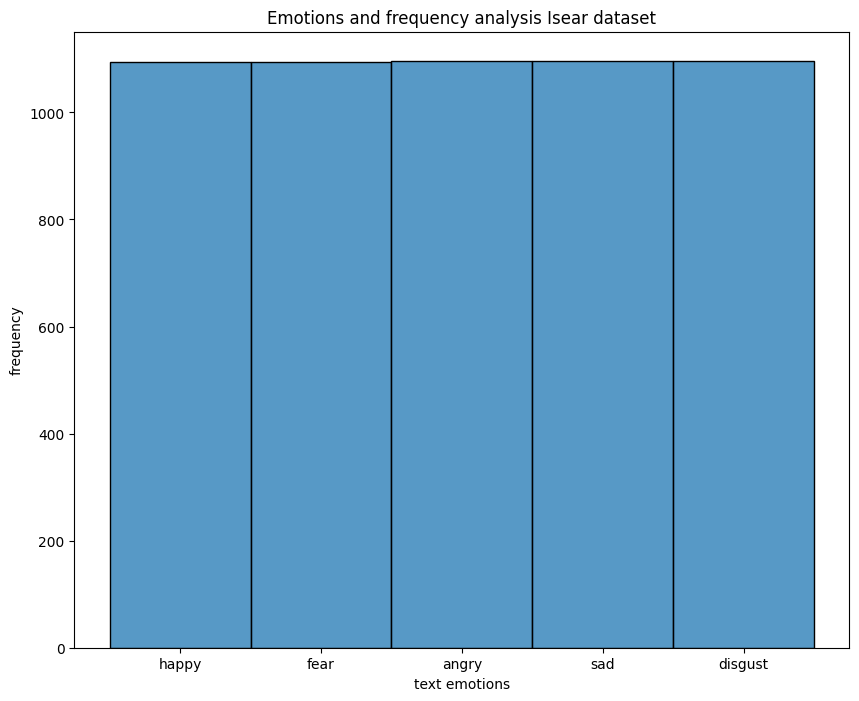

In [ ]:
plt.figure(figsize=(10,8)) #Graph to visualize th balanced data by having all the same amount of data
sns.histplot(isearDataset['label'])
plt.xlabel('text emotions')
plt.ylabel('frequency')
plt.title('Emotions and frequency analysis Isear dataset')
plt.show()

In [ ]:
isearDataset['label'].value_counts() #It can see that the data have the same amount of data in each label


label
angry      1096
sad        1096
disgust    1096
fear       1095
happy      1094
Name: count, dtype: int64

In [73]:
isearDataset['label'].unique()


array(['happy', 'fear', 'angry', 'sad', 'disgust'], dtype=object)

## Meld dataset

In [ ]:
dfMeld=pd.read_csv('meld_train.csv') #The meld dataset is read

label = dfMeld['Emotion'] #Only the emotion column (labels) is obtained
text = dfMeld['Utterance'] #Only the Utterance column (text) is obtained

data = { #The dataframe is created
    'texto' : text.tolist(),
    'label' : label.tolist()
}

dfMeld= pd.DataFrame(data)

In [ ]:
dfMeld = dfMeld.replace(to_replace=['joy', 'sadness', 'anger'], value=['happy', 'sad', 'angry']) #Rename labels joy, anger and sadness to happy, angry y sad
dfMeld

,texto,label
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


In [ ]:
def eliminarAcentos(texto):
    texto = texto.replace('[]', "'") #Remove []
    texto = texto.replace('', "'") #Eliminate errors
    return texto
dfMeld['texto'] = dfMeld['texto'].apply(eliminarAcentos) #Apply function
dfMeld

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


## Add missing Surprise and Neutral emotions from Meld dataset to ISEAR

- The two missing classes, Surprise and Neutral, which are representative in an educational context, are added. These are added with 1096 samples, which is the same amount of data as in ISEAR, maintaining the balance and equilibrium between classes.

In [ ]:
dfMeldsurprise = dfMeld[dfMeld['label']=='surprise'].sample(1096, random_state=42) #1096 sentences of the surprise class are randomly obtained.
dfMeldneutral = dfMeld[dfMeld['label']=='neutral'].sample(1096, random_state=42) #1096 sentences of the neutral class are randomly obtained.

In [13]:
dfMeldsurprise.reset_index(inplace=True)
dfMeldsurprise

,index,texto,label
0,874,What the hell is this?!,surprise
1,7741,"Nothing, I'm just practicing blowing you off b...",surprise
2,2506,"Really? My God, he's really cute.",surprise
3,956,No?,surprise
4,8731,Really?,surprise
...,...,...,...
1091,3274,It worked!,surprise
1092,6083,I do?,surprise
1093,9148,What one? You wanted him to invite you to the ...,surprise
1094,8416,No-no!,surprise


In [14]:
dfMeldneutral.reset_index(inplace=True)
dfMeldneutral

,index,texto,label
0,2573,"Now, have you told anyone else?",neutral
1,3677,No.,neutral
2,6939,"No thanks, I've already seen one.",neutral
3,7866,"No, answer his.",neutral
4,7931,"Y'know, twin stuff is always a real big seller.",neutral
...,...,...,...
1091,58,Ameri-can.,neutral
1092,6934,"Hey, so did everything go all right with the a...",neutral
1093,1569,"No,",neutral
1094,9323,Hey.,neutral


## Create dataset 7 emotions

now the dataset has 7 emotions : angry, sad, disgust, neutral, surprise, fear and happy

In [ ]:
dftodo = pd.concat([isearDataset, dfMeldneutral, dfMeldsurprise], axis=0, ignore_index=True) #The ISEAR dataset is concatenated and the two missing emotions are added
dftodo.reset_index(drop=True, inplace=True)
dftodo.drop('index', axis=1, inplace=True)
dftodo


,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7664,It worked!,surprise
7665,I do?,surprise
7666,What one? You wanted him to invite you to the ...,surprise
7667,No-no!,surprise


In [16]:
dftodo.describe()


,texto,label
count,7669,7669
unique,7300,7
top,[ No response.],angry
freq,42,1096


In [17]:
dftodo.groupby('label').describe()

texto                             
         count unique              top freq
label                                      
angry     1096   1089  [ No response.]    8
disgust   1096   1083  [ No response.]   13
fear      1095   1084  [ No response.]    5
happy     1094   1080  [ No response.]    4
neutral   1096   1018            Okay.   11
sad       1096   1058  [ No response.]   12
surprise  1096    911            What?   38

In [76]:
print(dftodo['label'].unique())


['happy' 'fear' 'angry' 'sad' 'disgust' 'neutral' 'surprise']


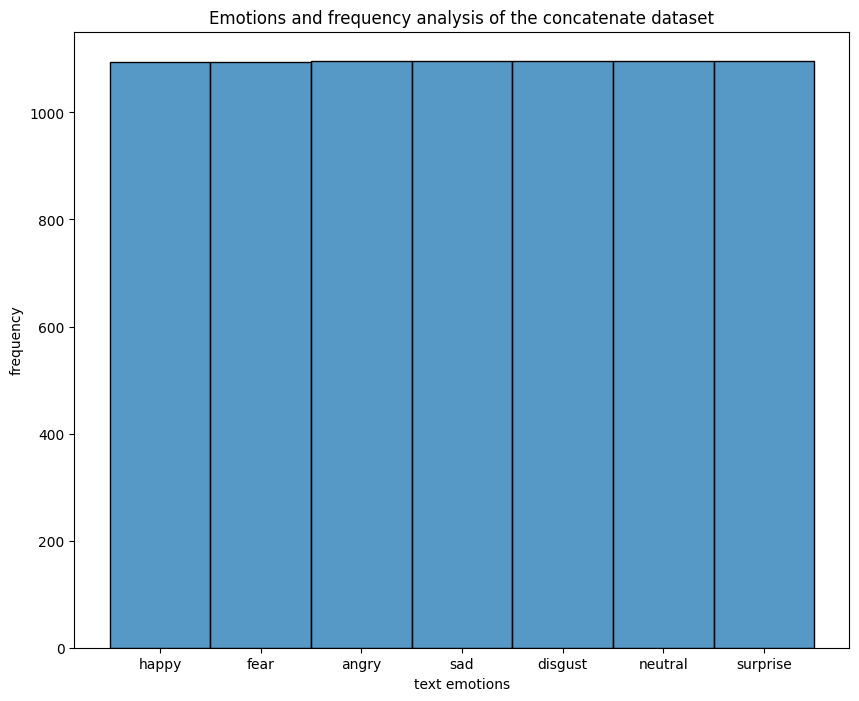

In [ ]:
plt.figure(figsize=(10,8)) #Now presents the 7 balanced classes
sns.histplot(dftodo['label'])
plt.xlabel('text emotions')
plt.ylabel('frequency')
plt.title('Emotions and frequency analysis of the concatenate dataset')
plt.show()

In [78]:
nullvalues = dftodo.isnull().sum()
print('Null values:', nullvalues)

Null values: texto    0
label    0
dtype: int64


In [18]:
dftodo['label'].value_counts()

label
angry       1096
sad         1096
disgust     1096
neutral     1096
surprise    1096
fear        1095
happy       1094
Name: count, dtype: int64

## Clean emotions text

In [ ]:
import re

"""
This function cleans the data by removing numbers, @, #, emoticons, extra spaces, data errors, and any other unwanted elements
"""

def clean_emotion_text(texto): #Function for data clearing
    if isinstance(texto, list): #If it is a list, it takes the first value
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #If it starts and ends with [] it eliminates them
        texto = texto[1:-1]

    texto = texto.lower() #Convert text to lowercase

    texto = texto.replace('á', '') #Eliminate errors
    texto = texto.replace('\n', '') #Eliminates erroneous spaces
    texto = texto.replace('[]', "'") #Eliminate []
    texto = texto.replace('', "'") #Eliminate more errors

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto) #Remove any text starting with @
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) #Remove Urls that with "https://
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto) #Remove any character that is not a letter
    texto = re.sub(r"#", ' ', texto) #Remove the # symbol
    texto = re.sub(r"\s(?=\')", "", texto) # Removes spaces that occur right before an apostrophe (')
    texto = texto.replace("' ", "'") #Removes any space after an apostrophe and directly connects the next word
    texto = re.sub(r" +", ' ', texto) # Replaces multiple consecutive spaces with a single space


    return texto

# Llamado a la función de limpieza
texto_clean = [clean_emotion_text(text) for text in tqdm(dftodo['texto'])] #Apply the function to the text

100%|██████████| 7669/7669 [00:00<00:00, 62310.63it/s]


In [20]:
texto_clean

['during the period of falling in love each time that we met and especially when we had not met for a long time.',
 'when i was involved in a traffic accident.',
 'when i was driving home after several days of hard work there was a motorist ahead of me who was driving at km hour and refused despite his low speeed to let me overtake.',
 'when i lost the person who meant the most to me. ',
 "the time i knocked a deer down the sight of the animal's injuries and helplessness. the realization that the animal was so badly hurt that it had to be put down and when the animal screamed at the moment of death.",
 'when i got a letter offering me the summer job that i had applied for. ',
 'when i was going home alone one night in paris and a man came up behind me and asked me if i was not afraid to be out alone so late at night.',
 'when i was talking to him at a party for the first time in a long while and a friend came and interrupted us and he left.',
 "when my friends did not ask me to go to a

## Transformation from classes to numerics

In [ ]:
labels = dftodo['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels) #Labels are transformed into One Hot Encoder

data_labels = labelEncoder

In [18]:
# get the class names
class_names = le.classes_

# get the numerics values assigned to each classes
class_values = le.transform(class_names)

# show the class names and their numerics values
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: neutral, Valor: 4
Clase: sad, Valor: 5
Clase: surprise, Valor: 6


## Division of the training set, testing and validation

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(texto_clean, data_labels, random_state=42, stratify=data_labels, test_size=0.1) #The data is divided into 10% for testing, using stratify to maintain distribution
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train, test_size=0.2222) #The data is divided into 20% of total for validation, using stratify to maintain distribution

In [ ]:
#SET SEED
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## Data augmentation for text

In [ ]:
from textattack.augmentation import EasyDataAugmenter
from tqdm import tqdm
import random
import numpy as np

"""
A function is created that allows applying data augmentation, where synonym replacement, text generation,
random exhange of word positions and random elimination are applied.
"""

# create augmenter
augmenter = EasyDataAugmenter()

# Function to apply the text augmentation
def augment_text(text, label):
    set_seed(42)
    augmented_texts = augmenter.augment(text)
    augmented_data = [(augmented_text, label) for augmented_text in augmented_texts]
    return augmented_data

# Convert zip result to list
data_with_labels = list(zip(x_train, y_train))

# Apply text aumentation to each text in texto_clean
augmented_data_list = [augment_text(text, label) for text, label in tqdm(data_with_labels, total=len(data_with_labels))]

# Flatten the list of list
augmented_data_flat = [item for sublist in augmented_data_list for item in sublist]

# Extract the generated phrases and labels
x_train_augmented = [augmented_text for augmented_text, label in augmented_data_flat]
y_train_augmented = [label for augmented_text, label in augmented_data_flat]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 5368/5368 [14:18<00:00,  6.25it/s]  


In [26]:
#Save Augmented data
"""
import pandas as pd

df_augmented = pd.DataFrame({'Texto': x_train_augmented, 'Label': y_train_augmented})

df_augmented.to_csv('datos_aumentados_with7emotions.csv', index=False)"""

In [21]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

## Glove and Word2Vec Embeddings

In [22]:
# Defining pre-processing parameters
max_len = 300
vocab_size = 300

In [ ]:
tokenizer = Tokenizer() # The tokenizer is created
tokenizer.fit_on_texts(x_train_augmented) #The text is transformed by applyinh the tokenizer

In [24]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

9944

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(x_train_augmented) # Converts the augmented training text data (x_train_augmented) into sequences of integers
X_val_seq = tokenizer.texts_to_sequences(x_val) # Converts the augmented validation text data (x_val) into sequences of integers
X_test_seq = tokenizer.texts_to_sequences(x_test) # Converts the augmented testing text data (x_test) into sequences of integers

In [ ]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post') # Pads the training sequences (X_train_seq) to ensure all sequences have the same length, defined by `max_len`
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post') # Pads the validation sequences (X_val_seq) to ensure all sequences have the same length, defined by `max_len`
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post') # Pads the testing sequences (X_test_seq) to ensure all sequences have the same length, defined by `max_len`

### Glove

In [ ]:

unique, counts = np.unique(y_train_augmented, return_counts=True)
print(dict(zip(unique, counts)))


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  

# Load the Glove model file
glove_file = 'glove.6B.300d.txt'
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs #Stores the word and its embedding vector in the dictionary embedding_index


# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # If an embedding vector exists for the word, it is assigned to the corresponding row in the embedding matrix.

{0: 3068, 1: 3068, 2: 3068, 3: 3064, 4: 2867, 5: 3067, 6: 2697}


In [28]:
y_train_augmented = np.array(y_train_augmented)


In [29]:
print(f'y_train_augmented shape: {y_train_augmented.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')


y_train_augmented shape: (20899,)
y_val shape: (1534,)
y_test shape: (767,)


In [ ]:
#Text is transformed to oneHotEncoder
y_train_one_hot = to_categorical(y_train_augmented, num_classes=7)
y_val_one_hot = to_categorical(y_val, num_classes=7)
y_test_one_hot = to_categorical(y_test, num_classes=7)

In [ ]:
input_layer = tf.keras.layers.Input(shape=(max_len,))

embd = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False)(input_layer) #Embedding layer is created, using the pre-trained embedding model Glove
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(embd) #Bi gram
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(embd) #Tri gram
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(embd) #Four gram
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout) #output layer
modelGlove2 = tf.keras.models.Model(inputs=input_layer, outputs=dense_output)

modelGlove2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation

print(modelGlove2.summary())




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     2983500     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 300, 128)     76928       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 300, 128)     115328      ['embedding[0][0]']              
                                                                                              

In [ ]:
# Training the model
historyGlove2 = modelGlove2.fit(X_train_padded, y_train_one_hot, epochs=20, batch_size=128, validation_data=(X_val_padded,y_val_one_hot), shuffle=True)

print(modelGlove2.evaluate(X_test_padded,y_test_one_hot))

Epoch 1/20
164/164 [==============================] - 12s 25ms/step - loss: 1.9667 - accuracy: 0.2175 - recall: 0.0155 - val_loss: 1.6103 - val_accuracy: 0.4348 - val_recall: 0.0130
Epoch 2/20
164/164 [==============================] - 4s 23ms/step - loss: 1.6433 - accuracy: 0.3310 - recall: 0.0503 - val_loss: 1.4061 - val_accuracy: 0.4837 - val_recall: 0.0476
Epoch 3/20
164/164 [==============================] - 4s 23ms/step - loss: 1.4576 - accuracy: 0.4073 - recall: 0.1257 - val_loss: 1.2667 - val_accuracy: 0.5183 - val_recall: 0.1369
Epoch 4/20
164/164 [==============================] - 4s 23ms/step - loss: 1.3200 - accuracy: 0.4695 - recall: 0.2164 - val_loss: 1.1521 - val_accuracy: 0.5704 - val_recall: 0.2634
Epoch 5/20
164/164 [==============================] - 4s 23ms/step - loss: 1.1915 - accuracy: 0.5272 - recall: 0.3031 - val_loss: 1.0449 - val_accuracy: 0.6141 - val_recall: 0.3794
Epoch 6/20
164/164 [==============================] - 4s 23ms/step - loss: 1.0878 - accuracy: 

In [ ]:
y_true = np.argmax(y_test_one_hot, axis=-1)
y_pred = modelGlove2.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=-1)

#The classification report is generated with various metrics.
report = classification_report(y_true, y_pred) # Evaluating the model
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(matrix)


24/24 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.58      0.56      0.57       110
           1       0.70      0.62      0.66       109
           2       0.77      0.83      0.80       109
           3       0.74      0.80      0.77       109
           4       0.68      0.67      0.68       110
           5       0.68      0.66      0.67       110
           6       0.68      0.69      0.69       110

    accuracy                           0.69       767
   macro avg       0.69      0.69      0.69       767
weighted avg       0.69      0.69      0.69       767

[[62 18  5  8  1 14  2]
 [19 68 10  3  2  5  2]
 [ 6  1 91  4  0  7  0]
 [ 2  5  5 87  1  9  0]
 [ 0  1  2  2 74  0 31]
 [16  4  4 12  1 73  0]
 [ 1  0  1  2 30  0 76]]


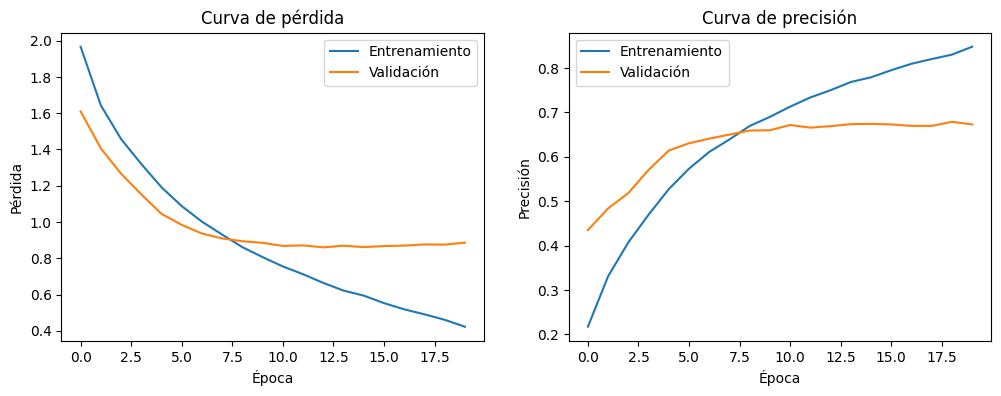

In [35]:
import matplotlib.pyplot as plt


train_loss = historyGlove2.history['loss']
val_loss = historyGlove2.history['val_loss']
train_accuracy = historyGlove2.history['accuracy']
val_accuracy = historyGlove2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Word2Vec

In [ ]:
#Text is transformed to oneHotEncoder
y_train_one_hot = to_categorical(y_train_augmented, num_classes=7)
y_val_one_hot = to_categorical(y_val, num_classes=7)
y_test_one_hot = to_categorical(y_test, num_classes=7)

In [ ]:
from gensim.models import KeyedVectors

unique, counts = np.unique(y_train_augmented, return_counts=True)
print(dict(zip(unique, counts)))
# Computes and prints the distribution of classes in the training labels (y_train_augmented).


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 


# Load Word2vec model file
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Create embedding matrix
embedding_matrix_word2vec = np.zeros((vocab_size, 300)) # Initializes an embedding matrix with shape (vocab_size, 300)
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix_word2vec[i] = word2vec[word]
        # If a word in the vocabulary exists in the Word2Vec model, its vector representation is copied
        # to the corresponding row in the embedding matrix.

{0: 3068, 1: 3068, 2: 3068, 3: 3064, 4: 2867, 5: 3067, 6: 2697}


In [ ]:
input_layer = tf.keras.layers.Input(shape=(max_len,))

embd = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix_word2vec], trainable=False)(input_layer) #Embedding layer is created, using the pre-trained embedding model Word2Vec
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(embd) #Bigram
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(embd) #TriGram
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(embd) #FourGram
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout) #Output layer
modelWord2vec2 = tf.keras.models.Model(inputs=input_layer, outputs=dense_output)

modelWord2vec2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation

print(modelWord2vec2.summary())




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 300, 300)     2983500     ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 300, 128)     76928       ['embedding_1[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 300, 128)     115328      ['embedding_1[0][0]']            
                                                                                            

In [ ]:
historyWord2vec2 = modelWord2vec2.fit(X_train_padded, y_train_one_hot, epochs=20, batch_size=128, validation_data=(X_val_padded,y_val_one_hot), shuffle=True)
#Training the model
print(modelWord2vec2.evaluate(X_test_padded,y_test_one_hot))

Epoch 1/20
164/164 [==============================] - 5s 25ms/step - loss: 1.8634 - accuracy: 0.2236 - recall_1: 2.8710e-04 - val_loss: 1.6215 - val_accuracy: 0.4785 - val_recall_1: 0.0000e+00
Epoch 2/20
164/164 [==============================] - 4s 23ms/step - loss: 1.5648 - accuracy: 0.3642 - recall_1: 0.0350 - val_loss: 1.3197 - val_accuracy: 0.5522 - val_recall_1: 0.0587
Epoch 3/20
164/164 [==============================] - 4s 23ms/step - loss: 1.3409 - accuracy: 0.4579 - recall_1: 0.1453 - val_loss: 1.1617 - val_accuracy: 0.5606 - val_recall_1: 0.2262
Epoch 4/20
164/164 [==============================] - 4s 23ms/step - loss: 1.1782 - accuracy: 0.5347 - recall_1: 0.2768 - val_loss: 1.0324 - val_accuracy: 0.6186 - val_recall_1: 0.3820
Epoch 5/20
164/164 [==============================] - 4s 23ms/step - loss: 1.0485 - accuracy: 0.5866 - recall_1: 0.3845 - val_loss: 0.9516 - val_accuracy: 0.6525 - val_recall_1: 0.4765
Epoch 6/20
164/164 [==============================] - 4s 23ms/step 

In [ ]:
y_test_one_hot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [43]:
y_true = np.argmax(y_test_one_hot, axis=-1)
y_true

array([6, 5, 3, 4, 3, 1, 6, 3, 5, 1, 0, 6, 4, 4, 0, 6, 1, 4, 3, 0, 6, 1,
       4, 3, 6, 6, 1, 3, 3, 1, 5, 5, 5, 0, 0, 2, 4, 6, 4, 4, 0, 5, 5, 5,
       2, 0, 3, 3, 0, 5, 1, 3, 6, 3, 3, 1, 4, 2, 2, 0, 6, 1, 3, 3, 1, 2,
       5, 4, 1, 4, 1, 6, 0, 5, 6, 3, 2, 1, 1, 1, 3, 6, 6, 5, 2, 2, 1, 6,
       1, 6, 5, 5, 4, 1, 0, 4, 5, 1, 1, 6, 0, 3, 0, 3, 5, 6, 0, 2, 0, 2,
       1, 1, 3, 0, 5, 6, 4, 5, 1, 0, 2, 0, 2, 1, 5, 0, 2, 4, 4, 0, 4, 3,
       4, 5, 4, 2, 4, 2, 1, 3, 0, 4, 6, 0, 2, 4, 1, 6, 6, 0, 4, 4, 5, 2,
       5, 2, 1, 5, 0, 1, 5, 3, 2, 2, 3, 3, 4, 5, 6, 0, 3, 1, 6, 4, 5, 6,
       0, 6, 3, 2, 4, 6, 0, 0, 2, 3, 5, 6, 0, 6, 4, 2, 1, 2, 3, 1, 6, 1,
       4, 4, 3, 2, 2, 5, 1, 1, 2, 1, 3, 1, 2, 6, 0, 1, 2, 6, 3, 5, 0, 4,
       2, 5, 2, 0, 1, 0, 4, 2, 0, 6, 2, 1, 5, 0, 2, 3, 4, 0, 5, 0, 4, 1,
       5, 2, 5, 4, 5, 2, 2, 5, 4, 6, 5, 0, 4, 6, 5, 2, 5, 6, 3, 2, 3, 6,
       0, 1, 5, 6, 2, 5, 6, 0, 6, 6, 4, 3, 3, 6, 6, 3, 0, 3, 6, 6, 2, 1,
       2, 6, 2, 6, 1, 4, 5, 2, 4, 2, 4, 0, 4, 1, 2,

In [41]:
y_pred = modelWord2vec2.predict(X_test_padded)
y_pred

24/24 [==============================] - 0s 3ms/step


array([[1.4565015e-06, 1.3032085e-06, 1.8943335e-06, ..., 1.2496846e-02,
        9.4071675e-06, 9.8747617e-01],
       [8.3430475e-01, 1.5453903e-01, 7.6720575e-03, ..., 3.8034856e-04,
        2.7237989e-03, 2.0095594e-04],
       [5.7744822e-03, 2.4082702e-02, 4.6093490e-02, ..., 2.8392650e-02,
        9.4826654e-02, 3.9341897e-02],
       ...,
       [2.5986822e-03, 4.2251917e-04, 9.8772907e-01, ..., 2.6200756e-03,
        4.9356013e-03, 1.3086331e-03],
       [4.7954051e-03, 1.4313662e-03, 3.7577387e-03, ..., 3.6072917e-04,
        5.2110724e-02, 1.4303393e-04],
       [1.2715758e-01, 8.4534071e-02, 3.7541904e-02, ..., 1.9754084e-02,
        4.9681041e-01, 4.4569233e-03]], dtype=float32)

In [ ]:
y_true = np.argmax(y_test_one_hot, axis=-1)
y_pred = modelWord2vec2.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=-1)

#Evaluating model
report = classification_report(y_true, y_pred) #The classification report is generated with various metrics.
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(matrix)

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       110
           1       0.68      0.65      0.67       109
           2       0.75      0.78      0.77       109
           3       0.77      0.84      0.80       109
           4       0.75      0.73      0.74       110
           5       0.70      0.68      0.69       110
           6       0.74      0.74      0.74       110

    accuracy                           0.72       767
   macro avg       0.72      0.72      0.72       767
weighted avg       0.72      0.72      0.72       767

[[68 17  6  6  2 11  0]
 [17 71  8  6  1  5  1]
 [ 4  6 85  3  0 11  0]
 [ 2  5  6 92  0  4  0]
 [ 0  0  0  2 80  1 27]
 [15  5  6  8  1 75  0]
 [ 1  0  2  3 23  0 81]]


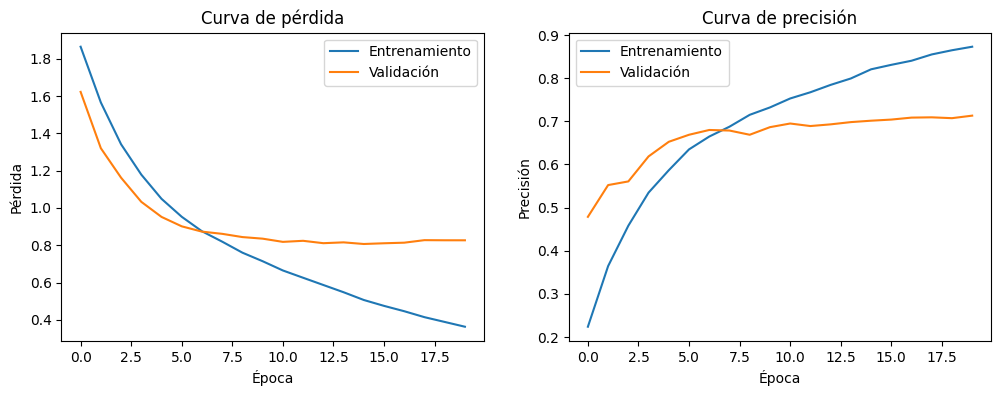

In [44]:
import matplotlib.pyplot as plt


train_loss = historyWord2vec2.history['loss']
val_loss = historyWord2vec2.history['val_loss']
train_accuracy = historyWord2vec2.history['accuracy']
val_accuracy = historyWord2vec2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Definition Bert and Roberta and others

- To use the pre-trained BERT models or derivations, the model and the corresponding tokenizer must be imported.

In [ ]:
from transformers import BertTokenizer, TFBertModel,RobertaTokenizer,TFRobertaModel, TFDistilBertModel, AutoTokenizer, TFXLNetModel,TFAlbertModel,TFDebertaModel, TFElectraModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased') #Import the BERT tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')  #BERT's model is imported

tokenizer_roberta = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base") #Import the RoBERTa tokenizer
roberta_model = TFRobertaModel.from_pretrained("FacebookAI/roberta-base")  #RoBERTa's model is imported

tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased") #Import the distilBERT tokenizer
model_distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased") #distilBERT's model is imported

tokenizer_XLNet = AutoTokenizer.from_pretrained("xlnet/xlnet-base-cased")  #Import the XLNet tokenizer
model_XLNet = TFXLNetModel.from_pretrained("xlnet/xlnet-base-cased") #XLNet's model is imported


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
from transformers import BertTokenizer, TFBertModel,RobertaTokenizer,TFRobertaModel, TFDistilBertModel, AutoTokenizer, TFXLNetModel,TFAlbertModel,TFDebertaModel, TFElectraModel

tokenizer_Albert = AutoTokenizer.from_pretrained("albert/albert-base-v2") #Import the alBERT tokenizer
model_Albert = TFAlbertModel.from_pretrained("albert/albert-base-v2") #alBERT's model is imported

tokenizer_deberta = AutoTokenizer.from_pretrained("microsoft/deberta-base") #Import the deBERTa tokenizer
model_deberta= TFDebertaModel.from_pretrained("microsoft/deberta-base") #deBERTa's model is imported

tokenizer_electra = AutoTokenizer.from_pretrained("google/electra-small-discriminator") #Import the ELECTRA tokenizer
model_Electra = TFElectraModel.from_pretrained("google/electra-small-discriminator") #ELECTRA's model is imported

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.
All model checkpoint layers were used when initializing T

## Tokenizer words

### Bert

In [ ]:
def tokenizer_bert_fn(texts, labels): #Function for tokenization by Bert Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_bert(text, #Tokenized
                                padding="max_length", #Padding is applied with a length of 300
                                truncation=True, # Truncate sequences longer than the maximum length
                                max_length=300, #Max length
                                return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train, attention_mask_train, labels_train = tokenizer_bert_fn(x_train_augmented, y_train_augmented)
input_ids_test, attention_mask_test, labels_test = tokenizer_bert_fn(x_test, y_test)
input_ids_val, attention_mask_val, labels_val = tokenizer_bert_fn(x_val, y_val)

input_ids_train = np.squeeze(input_ids_train, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train = np.squeeze(attention_mask_train, axis=1) # Remove the unnecessary dimension introduced

input_ids_test = np.squeeze(input_ids_test, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test = np.squeeze(attention_mask_test, axis=1) # Remove the unnecessary dimension introduced

input_ids_val = np.squeeze(input_ids_val, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val = np.squeeze(attention_mask_val, axis=1) # Remove the unnecessary dimension introduced

### Roberta

In [ ]:
def tokenizer_roberta_fn(texts, labels): #Function for tokenization by RoBERTa Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=7)  #Transforms labels to OneHotEncoder

    for text in texts: #for each text
        inputs = tokenizer_roberta(text,  #Tokenized
                                padding="max_length", #Padding is applied with a length of 300
                                truncation=True, # Truncate sequences longer than the maximum length
                                max_length=300, #max length
                                return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta, attention_mask_train_roberta, labels_train_roberta = tokenizer_roberta_fn(x_train_augmented, y_train_augmented)
input_ids_test_roberta, attention_mask_test_roberta, labels_test_roberta = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta, attention_mask_val_roberta, labels_val_roberta = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta = np.squeeze(input_ids_train_roberta, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train_roberta = np.squeeze(attention_mask_train_roberta, axis=1) # Remove the unnecessary dimension introduced

input_ids_test_roberta = np.squeeze(input_ids_test_roberta, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test_roberta = np.squeeze(attention_mask_test_roberta, axis=1) # Remove the unnecessary dimension introduced

input_ids_val_roberta = np.squeeze(input_ids_val_roberta, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val_roberta = np.squeeze(attention_mask_val_roberta, axis=1) # Remove the unnecessary dimension introduced

### Diltibert

In [ ]:
def tokenizer_diltibert_fn(texts, labels): #Function for tokenization by DiltiBERT Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=7)  #Transforms labels to OneHotEncoder

    for text in texts: #for each text
        inputs = tokenizer_distilbert(text, #Tokenized
                                      padding="max_length", #Padding is applied with a length of 300
                                      truncation=True, # Truncate sequences longer than the maximum length
                                      max_length=300, #max length
                                      return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved
    
    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_diltibert, attention_mask_train_diltibert, labels_train_diltibert = tokenizer_diltibert_fn(x_train_augmented, y_train_augmented)
input_ids_test_diltibert, attention_mask_test_diltibert, labels_test_diltibert = tokenizer_diltibert_fn(x_test, y_test)
input_ids_val_diltibert, attention_mask_val_diltibert, labels_val_diltibert = tokenizer_diltibert_fn(x_val, y_val)

input_ids_train_diltibert = np.squeeze(input_ids_train_diltibert, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train_diltibert = np.squeeze(attention_mask_train_diltibert, axis=1) # Remove the unnecessary dimension introduced

input_ids_test_diltibert = np.squeeze(input_ids_test_diltibert, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test_diltibert = np.squeeze(attention_mask_test_diltibert, axis=1) # Remove the unnecessary dimension introduced

input_ids_val_diltibert= np.squeeze(input_ids_val_diltibert, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val_diltibert = np.squeeze(attention_mask_val_diltibert, axis=1) # Remove the unnecessary dimension introduced

### XLNet

In [ ]:
def tokenizer_xlnet_fn(texts, labels): #Function for tokenization by XLNet Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=7)  #Transforms labels to OneHotEncoder

    for text in texts: #for each text
        inputs = tokenizer_XLNet(text, #Tokenized
                                      padding="max_length", #Padding is applied with a length of 300
                                      truncation=True, # Truncate sequences longer than the maximum length
                                      max_length=300, #max length
                                      return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved
    
    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_XLNet, attention_mask_train_XLNet, labels_train_XLNet = tokenizer_xlnet_fn(x_train_augmented, y_train_augmented)
input_ids_test_XLNet, attention_mask_test_XLNet, labels_test_XLNet = tokenizer_xlnet_fn(x_test, y_test)
input_ids_val_XLNet, attention_mask_val_XLNet, labels_val_XLNet = tokenizer_xlnet_fn(x_val, y_val)

input_ids_train_XLNet = np.squeeze(input_ids_train_XLNet, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train_XLNet = np.squeeze(attention_mask_train_XLNet, axis=1) # Remove the unnecessary dimension introduced

input_ids_test_XLNet = np.squeeze(input_ids_test_XLNet, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test_XLNet = np.squeeze(attention_mask_test_XLNet, axis=1) # Remove the unnecessary dimension introduced

input_ids_val_XLNet= np.squeeze(input_ids_val_XLNet, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val_XLNet = np.squeeze(attention_mask_val_XLNet, axis=1) # Remove the unnecessary dimension introduced

## Model 1 Roberta + NGram CNN - 7 Emotions - 79.92%

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output) #Enter the output to Trigram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output) #Enter the output to FourGram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout) #Output layer
modelTestRoberta7Emotions = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

modelTestRoberta7Emotions.layers[2].trainable=False #Pre-trained layers set to False

modelTestRoberta7Emotions.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
modelTestRoberta7Emotions.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_5[0][0]',                
 el)                            thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

#--------------------------------------------------------------------------------
historyRoberta7Emotions = modelTestRoberta7Emotions.fit( #Training the model
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 2.1656 - accuracy: 0.2293 - recall_2: 0.0721
Epoch 1: val_accuracy improved from -inf to 0.47914, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch\BERT_CNN_model_best_01_val_0.4791.h5
164/164 [==============================] - 415s 2s/step - loss: 2.1656 - accuracy: 0.2293 - recall_2: 0.0721 - val_loss: 1.5634 - val_accuracy: 0.4791 - val_recall_2: 6.5189e-04
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 1.5330 - accuracy: 0.3517 - recall_2: 0.1166
Epoch 2: val_accuracy improved from 0.47914 to 0.58866, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/128batch\BERT_CNN_model_best_02_val_0.5887.h5
164/164 [==============================] - 433s 3s/step - loss: 1.5330 - accuracy: 0.3517 - recall_2: 0.1166 - val_loss: 1.3591 - val_accuracy: 0

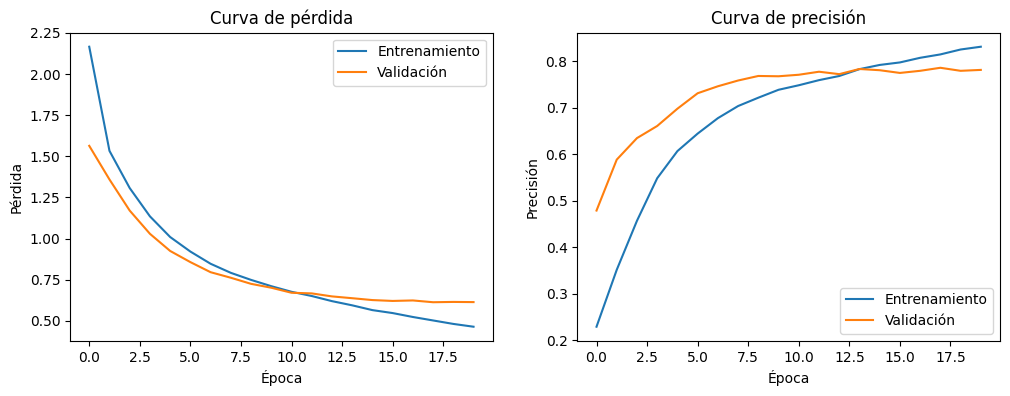

In [40]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions.history['loss']
val_loss = historyRoberta7Emotions.history['val_loss']
train_accuracy = historyRoberta7Emotions.history['accuracy']
val_accuracy = historyRoberta7Emotions.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Evaluate on test set

In [ ]:
def custom_objects_fn_roberta():
    return {'TFRobertaModel': TFRobertaModel}

#Validation model
model_load3 = load_model(r'model\BERTHugginfFace\OptimizationBestModel\7Emotions\Roberta\128batch\BERT_CNN_model_best_14_val_0.7836.h5', custom_objects=custom_objects_fn_roberta())
print(model_load3.summary())
evaluate = model_load3.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)
print(evaluate)

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_5[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [59]:
evaluate_1 = model_load3.evaluate([input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta)
print("Evaluación train: ",evaluate_1)

654/654 [==============================] - 269s 411ms/step - loss: 0.4903 - accuracy: 0.8550 - recall_2: 0.7399
Evaluación train:  [0.4902797341346741, 0.8549691438674927, 0.7399396896362305]


In [ ]:
y_true = np.argmax(labels_test_roberta, axis=-1)
y_pred = model_load3.predict([input_ids_test_roberta, attention_mask_test_roberta])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true, y_pred) #The classification report is generated with various metrics.
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(matrix)


24/24 [==============================] - 13s 406ms/step
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       110
           1       0.81      0.68      0.74       109
           2       0.87      0.80      0.83       109
           3       0.86      0.94      0.90       109
           4       0.88      0.76      0.82       110
           5       0.77      0.75      0.76       110
           6       0.82      0.90      0.86       110

    accuracy                           0.80       767
   macro avg       0.81      0.80      0.80       767
weighted avg       0.81      0.80      0.80       767

[[ 85  13   3   1   0   8   0]
 [ 23  74   2   2   2   6   0]
 [  9   1  87   6   0   6   0]
 [  1   1   2 102   0   3   0]
 [  1   0   2   0  84   1  22]
 [ 15   2   4   7   0  82   0]
 [  1   0   0   0  10   0  99]]


Text(95.72222222222221, 0.5, 'True')

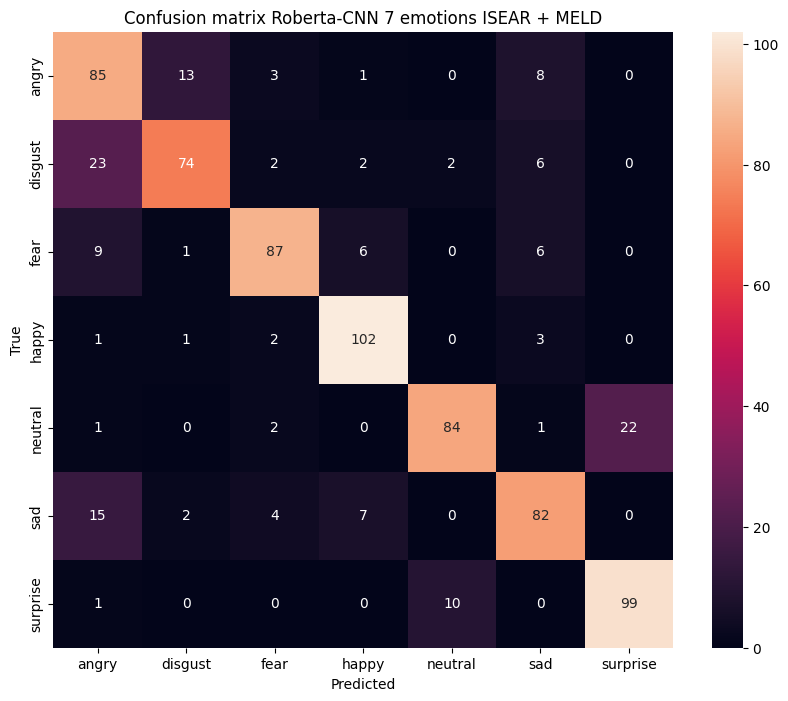

In [55]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix Roberta-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
predictions_perplexity = model_load3.predict([input_ids_test_roberta, attention_mask_test_roberta])

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
loss_perplexity = loss_fn(labels_test_roberta, predictions_perplexity)

#Obtaining the Perplexity metric
perplexity = tf.exp(tf.reduce_mean(loss_perplexity))

print("Perplexity: ", perplexity.numpy())


24/24 [==============================] - 141s 3s/step
Perplexity:  4.350032


## Model 2 Bert + NGram CNN - 7 Emotions - 80.18%

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output) #Enter the output to TriGram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output) #Enter the output to FourGram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout) #Output layer
model247Emotions = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

model247Emotions.layers[2].trainable=False #Pre-trained layers set to False

model247Emotions.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
model247Emotions.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/7Emotions/BERT/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/7Emotions/BERT/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/7Emotions/BERT/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/7Emotions/BERT/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

#--------------------------------------------------------------------------------
history247Emotions = model247Emotions.fit( #Training the model
    [input_ids_train, attention_mask_train], labels_train,
    validation_data=([input_ids_val, attention_mask_val], labels_val),
    epochs=15,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
164/164 [==============================] - ETA: 0s - loss: 1.8690 - accuracy: 0.3066 - recall_3: 0.1247
Epoch 1: val_accuracy improved from -inf to 0.63364, saving model to model/BERTHugginfFace/7Emotions/BERT/128batch\BERT_CNN_model_best_01_val_0.6336.h5
164/164 [==============================] - 346s 2s/step - loss: 1.8690 - accuracy: 0.3066 - recall_3: 0.1247 - val_loss: 1.1315 - val_accuracy: 0.6336 - val_recall_3: 0.2053
Epoch 2/15
164/164 [==============================] - ETA: 0s - loss: 1.2374 - accuracy: 0.5064 - recall_3: 0.2969
Epoch 2: val_accuracy improved from 0.63364 to 0.67731, saving model to model/BERTHugginfFace/7Emotions/BERT/128batch\BERT_CNN_model_best_02_val_0.6773.h5
164/164 [==============================] - 330s 2s/step - loss: 1.2374 - accuracy: 0.5064 - recall_3: 0.2969 - val_loss: 0.8723 - val_accuracy: 0.6773 - val_recall_3: 0.4622
Epoch 3/15
164/164 [=====

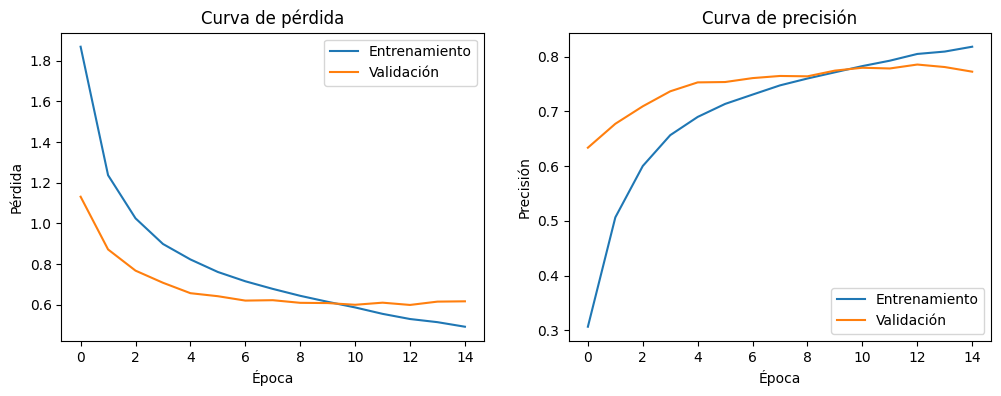

In [43]:
import matplotlib.pyplot as plt


train_loss = history247Emotions.history['loss']
val_loss = history247Emotions.history['val_loss']
train_accuracy = history247Emotions.history['accuracy']
val_accuracy = history247Emotions.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Evaluate on test set

In [ ]:
def custom_objects_fn():
    return {'TFBertModel': TFBertModel}

#Validation model
model_load4 = load_model(r'C:\Users\bryan\OneDrive\Escritorio\Tesis\Codigo tesis\Texto\code 6\model\BERTHugginfFace\7Emotions\BERT\128batch\BERT_CNN_model_best_13_val_0.7855.h5', custom_objects=custom_objects_fn())
print(model_load4.summary())
evaluate2 = model_load4.evaluate([input_ids_test, attention_mask_test], labels_test)
print("Evaluación test: "evaluate2)

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [58]:
evaluate2_1 = model_load4.evaluate([input_ids_train, attention_mask_train], labels_train)
print("Evaluación train: ",evaluate2_1)

  3/654 [..............................] - ETA: 4:33 - loss: 0.2604 - accuracy: 0.8854 - recall_3: 0.8438

654/654 [==============================] - 313s 478ms/step - loss: 0.3458 - accuracy: 0.8807 - recall_3: 0.8385
Evaluación train:  [0.3457919955253601, 0.8807119727134705, 0.83846116065979]


In [ ]:
y_true2 = np.argmax(labels_test, axis=-1)
y_pred2 = model_load4.predict([input_ids_test, attention_mask_test])
y_pred2 = np.argmax(y_pred2, axis=-1)

report2 = classification_report(y_true2, y_pred2) #The classification report is generated with various metrics.
print(report2)

matrix2 = confusion_matrix(y_true2, y_pred2)
print(matrix2)

24/24 [==============================] - 13s 409ms/step
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       110
           1       0.78      0.67      0.72       109
           2       0.89      0.85      0.87       109
           3       0.86      0.89      0.87       109
           4       0.83      0.85      0.84       110
           5       0.74      0.74      0.74       110
           6       0.84      0.89      0.87       110

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.80      0.80      0.80       767

[[80 14  2  4  1  9  0]
 [19 73  5  3  4  5  0]
 [ 3  1 93  3  0  8  1]
 [ 2  1  2 97  1  6  0]
 [ 0  0  0  0 93  0 17]
 [15  4  3  6  1 81  0]
 [ 0  0  0  0 12  0 98]]


Text(95.72222222222221, 0.5, 'True')

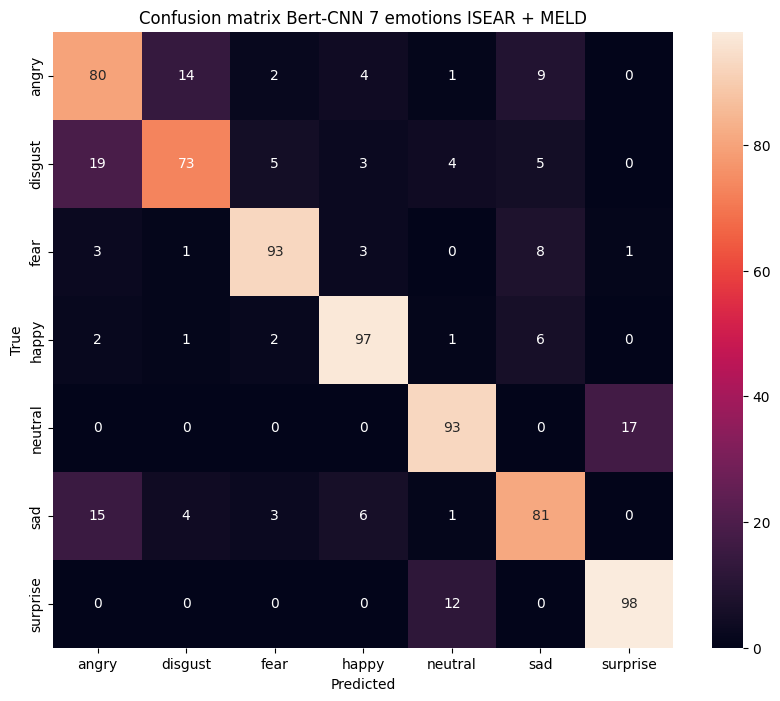

In [56]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix2, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix Bert-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

## Model 3 Roberta + NGram CNN + Dropout - 7 Emotions - 79.79%

In [28]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output)
x_1 = tf.keras.layers.Dropout(0.2)(x_1)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output)
x_2 = tf.keras.layers.Dropout(0.2)(x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output)
x_3 = tf.keras.layers.Dropout(0.2)(x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelTestRoberta7Emotions2 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestRoberta7Emotions2.layers[2].trainable=False

modelTestRoberta7Emotions2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestRoberta7Emotions2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [29]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
historyRoberta7Emotions2 = modelTestRoberta7Emotions2.fit(
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
327/327 [==============================] - ETA: 0s - loss: 2.0565 - accuracy: 0.2560 - recall: 0.0879
Epoch 1: val_accuracy improved from -inf to 0.53911, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch\BERT_CNN_model_best_01_val_0.5391.h5
327/327 [==============================] - 406s 1s/step - loss: 2.0565 - accuracy: 0.2560 - recall: 0.0879 - val_loss: 1.5599 - val_accuracy: 0.5391 - val_recall: 6.5189e-04
Epoch 2/20
327/327 [==============================] - ETA: 0s - loss: 1.3864 - accuracy: 0.4244 - recall: 0.1876
Epoch 2: val_accuracy improved from 0.53911 to 0.63494, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch\BERT_CNN_model_best_02_val_0.6349.h5
327/327 [==============================] - 340s 1s/step - loss: 1.3864 - accuracy: 0.4244 - recall: 0.1876 - val_loss: 1.2672 - val_accuracy: 0.6349 - val_recall: 0.0847
Epoch 3/20
327/327 [==============================] - ETA

In [24]:
def custom_objects_fn_roberta():
    return {'TFRobertaModel': TFRobertaModel}

model_load5 = load_model(r'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_Dropout/128batch\BERT_CNN_model_best_16_val_0.7875.h5', custom_objects=custom_objects_fn_roberta())
evaluate = model_load5.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)
print(evaluate)

24/24 [==============================] - 16s 412ms/step - loss: 0.5740 - accuracy: 0.7979 - recall: 0.7066
[0.5740094780921936, 0.7979139685630798, 0.7066493034362793]


In [25]:
y_true = np.argmax(labels_test_roberta, axis=-1)
y_pred = model_load5.predict([input_ids_test_roberta, attention_mask_test_roberta])
y_pred = np.argmax(y_pred, axis=-1)

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(matrix)

24/24 [==============================] - 13s 408ms/step
              precision    recall  f1-score   support

           0       0.67      0.75      0.70       110
           1       0.77      0.70      0.73       109
           2       0.86      0.80      0.83       109
           3       0.85      0.92      0.88       109
           4       0.88      0.75      0.81       110
           5       0.77      0.79      0.78       110
           6       0.82      0.88      0.85       110

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.80      0.80      0.80       767

[[ 82  17   2   0   0   9   0]
 [ 18  76   5   3   2   5   0]
 [  5   3  87   7   0   7   0]
 [  1   2   1 100   0   5   0]
 [  1   0   3   1  83   0  22]
 [ 14   1   3   5   0  87   0]
 [  2   0   0   2   9   0  97]]


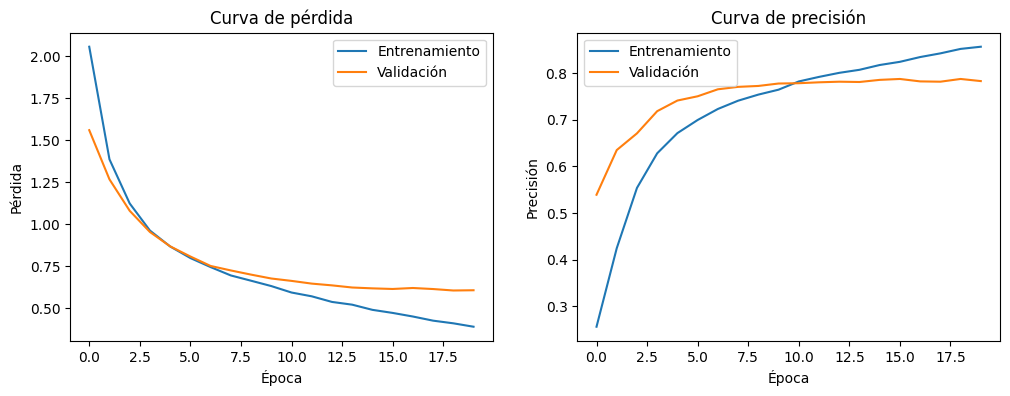

In [30]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions2.history['loss']
val_loss = historyRoberta7Emotions2.history['val_loss']
train_accuracy = historyRoberta7Emotions2.history['accuracy']
val_accuracy = historyRoberta7Emotions2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Model 4 Roberta + NGram CNN - 7 Emotions - Double cleaning - BEST 80.70%

In [24]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [ ]:
import re
import spacy
from nltk.corpus import words
nltk.download('words') # Download the NLTK word corpus for English words



nlp = spacy.load("en_core_web_sm") #Spacy model english text
valid_words = set(words.words())  

def correct_ii_errors(text): # Function to correct errors where 'ii' appears in words unnecessarily
    words = text.split() # Split the text into individual words
    corrected_words = []
    for word in words:
        if 'ii' in word.lower() and word.lower() not in valid_words: # Check if 'ii' exists in the word and it's not a valid English word
            corrected_word = word.replace('ii', 'i') # Replace 'ii' with 'i'
            if corrected_word.lower() in valid_words:
                corrected_words.append(corrected_word) # If the corrected word is a valid English word, append it
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word) # Append words that don't need correction
    return ' '.join(corrected_words)

def clean_emotion_text(texto): #Function for data clearing
    if isinstance(texto, list):  #If it is a list, it takes the first value
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'):  #If it starts and ends with [] it eliminates them
        texto = texto[1:-1]

    texto = texto.lower() #Convert text to lowercase

    texto = texto.replace('á', '') #Eliminate errors
    texto = texto.replace('\n', '') #Eliminates erroneous spaces
    texto = texto.replace('[]', "'") #Eliminate []
    texto = texto.replace('', "'") #Eliminate more errors

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto) #Remove any text starting with @
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) #Remove Urls that with "https://
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto) #Remove any character that is not a letter
    texto = re.sub(r"(?<!\S)\?(?!\S)", '', texto) # Remove isolated question marks.
    texto = re.sub(r"(?<!\S)\.(?!\S)", '', texto) 
    texto = re.sub(r"#", ' ', texto) #Remove the # symbol
    texto = re.sub(r"\s(?=\')", "", texto)  # Remove spaces before apostrophes
    texto = texto.replace("' ", "'") # Remove spaces after apostrophes
    texto = re.sub(r" +", ' ', texto)  # Replace multiple spaces with a single space.

    corrected_text = correct_ii_errors(texto)  # Apply the 'ii' error correction function

    return corrected_text


x_train_augmentedwith = [clean_emotion_text(text) for text in tqdm(x_train_augmented)] #Apply the function to the text

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 20899/20899 [00:00<00:00, 31911.47it/s]


In [ ]:
def tokenizer_roberta_fn(texts, labels): #Function for tokenization by RoBERTa Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=7) #Transforms labels to OneHotEncoder

    for text in texts:
        inputs = tokenizer_roberta(text,  #Tokenized
                                padding="max_length",  #Padding is applied with a length of 300
                                truncation=True, # Truncate sequences longer than the maximum length
                                max_length=300, #Max length
                                return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta, attention_mask_train_roberta, labels_train_roberta = tokenizer_roberta_fn(x_train_augmentedwith, y_train_augmented)
input_ids_test_roberta, attention_mask_test_roberta, labels_test_roberta = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta, attention_mask_val_roberta, labels_val_roberta = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta = np.squeeze(input_ids_train_roberta, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train_roberta = np.squeeze(attention_mask_train_roberta, axis=1) # Remove the unnecessary dimension introduced

input_ids_test_roberta = np.squeeze(input_ids_test_roberta, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test_roberta = np.squeeze(attention_mask_test_roberta, axis=1) # Remove the unnecessary dimension introduced

input_ids_val_roberta = np.squeeze(input_ids_val_roberta, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val_roberta = np.squeeze(attention_mask_val_roberta, axis=1) # Remove the unnecessary dimension introduced

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output) #Enter the output to TriGram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output) #Enter the output to FourGram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout) #Output model
modelTestRoberta7Emotions2 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

modelTestRoberta7Emotions2.layers[2].trainable=False #Pre-trained layers set to False

modelTestRoberta7Emotions2.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
modelTestRoberta7Emotions2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch', exist_ok=True) 



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

#--------------------------------------------------------------------------------
historyRoberta7Emotions2 = modelTestRoberta7Emotions2.fit( #Training model
    [input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta,
    validation_data=([input_ids_val_roberta, attention_mask_val_roberta], labels_val_roberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 2.1907 - accuracy: 0.2199 - recall: 0.0656
Epoch 1: val_accuracy improved from -inf to 0.44003, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch\BERT_CNN_model_best_01_val_0.4400.h5
164/164 [==============================] - 384s 2s/step - loss: 2.1907 - accuracy: 0.2199 - recall: 0.0656 - val_loss: 1.5795 - val_accuracy: 0.4400 - val_recall: 0.0000e+00
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 1.5323 - accuracy: 0.3552 - recall: 0.1172
Epoch 2: val_accuracy improved from 0.44003 to 0.56910, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta_clean2/128batch\BERT_CNN_model_best_02_val_0.5691.h5
164/164 [==============================] - 332s 2s/step - loss: 1.5323 - accuracy: 0.3552 - recall: 0.1172 - val_loss: 1.3539 - val_accuracy: 0.5691 - val_recall: 0.0274
Epoch 3/20
164/164 [==============================] - ETA: 

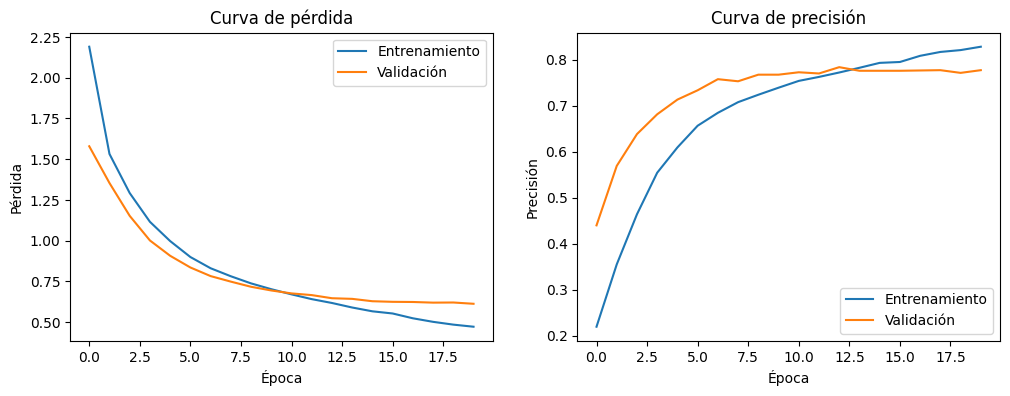

In [38]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions2.history['loss']
val_loss = historyRoberta7Emotions2.history['val_loss']
train_accuracy = historyRoberta7Emotions2.history['accuracy']
val_accuracy = historyRoberta7Emotions2.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [ ]:
def custom_objects_fn_roberta():
    return {'TFRobertaModel': TFRobertaModel}

#Validation model
model_load5 = load_model(r'model\BERTHugginfFace\OptimizationBestModel\7Emotions\Roberta_clean2\128batch\BERT_CNN_model_best_13_val_0.7836.h5', custom_objects_fn_roberta())
print(model_load5.summary())
evaluate3 = model_load5.evaluate([input_ids_test_roberta, attention_mask_test_roberta], labels_test_roberta)
print("Evaluación test: ",evaluate3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [39]:
evaluate4 = model_load5.evaluate([input_ids_train_roberta, attention_mask_train_roberta], labels_train_roberta)
print("Evaluación train: ",evaluate4)

654/654 [==============================] - 278s 424ms/step - loss: 0.5233 - accuracy: 0.8500 - recall: 0.7112
Evaluación train:  [0.5233400464057922, 0.8500406742095947, 0.7112302184104919]


In [ ]:
y_true3 = np.argmax(labels_test_roberta, axis=-1)
y_pred3 = model_load5.predict([input_ids_test_roberta, attention_mask_test_roberta])
y_pred3 = np.argmax(y_pred3, axis=-1)

report3 = classification_report(y_true3, y_pred3) #The classification report is generated with various metrics.
print(report3)

matrix3 = confusion_matrix(y_true3, y_pred3)
print(matrix3)

24/24 [==============================] - 13s 410ms/step
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       110
           1       0.79      0.69      0.74       109
           2       0.83      0.83      0.83       109
           3       0.84      0.92      0.88       109
           4       0.87      0.76      0.81       110
           5       0.79      0.76      0.78       110
           6       0.82      0.90      0.86       110

    accuracy                           0.81       767
   macro avg       0.81      0.81      0.81       767
weighted avg       0.81      0.81      0.81       767

[[ 87  15   1   1   0   6   0]
 [ 18  75   6   3   2   5   0]
 [  3   1  90   7   0   8   0]
 [  2   1   3 100   0   3   0]
 [  0   0   2   2  84   0  22]
 [ 11   3   6   6   0  84   0]
 [  0   0   0   0  11   0  99]]


Text(95.72222222222221, 0.5, 'True')

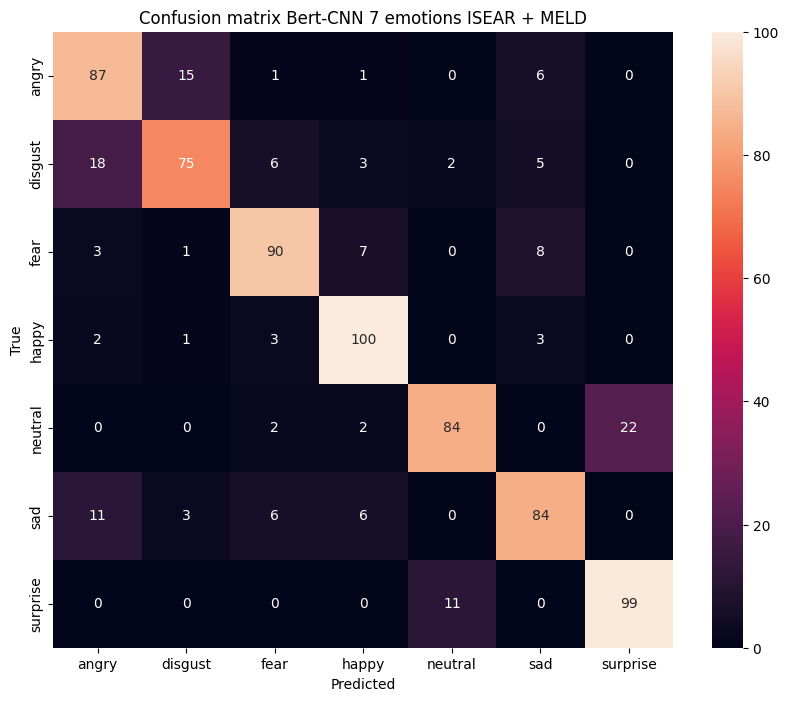

In [36]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix3, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix Bert-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

Text(95.72222222222221, 0.5, 'True')

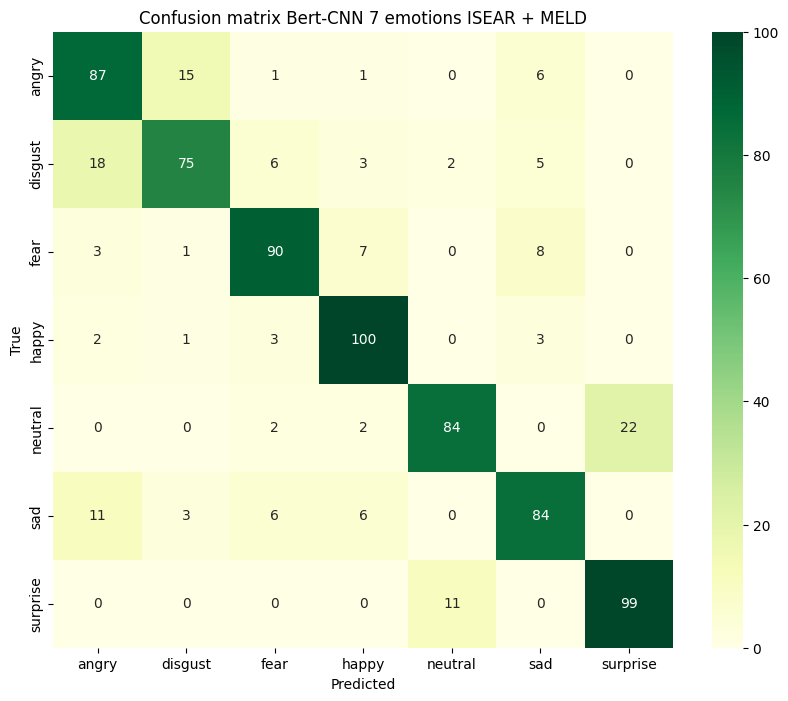

In [28]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix3, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='YlGn')
plt.title('Confusion matrix Bert-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
predictions_perplexity2 = model_load5.predict([input_ids_test_roberta, attention_mask_test_roberta])

loss_fn2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
loss_perplexity2 = loss_fn2(labels_test_roberta, predictions_perplexity2)

#Obtaining the Perplexity metric
perplexity2 = tf.exp(tf.reduce_mean(loss_perplexity2))

print("Perplexity: ", perplexity2.numpy())

24/24 [==============================] - 10s 414ms/step
Perplexity:  4.402052


## Model 5 DilBert + NGram CNN - 7 Emotions - Double cleaning - 79.79%

In [60]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [ ]:
import re
import spacy
from nltk.corpus import words
nltk.download('words') # Download the NLTK word corpus for English words



nlp = spacy.load("en_core_web_sm") #Spacy model english text
valid_words = set(words.words())  

def correct_ii_errors(text): # Function to correct errors where 'ii' appears in words unnecessarily
    words = text.split() # Split the text into individual words
    corrected_words = []
    for word in words:
        if 'ii' in word.lower() and word.lower() not in valid_words: # Check if 'ii' exists in the word and it's not a valid English word
            corrected_word = word.replace('ii', 'i') # Replace 'ii' with 'i'
            if corrected_word.lower() in valid_words:
                corrected_words.append(corrected_word) # If the corrected word is a valid English word, append it
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word) # Append words that don't need correction
    return ' '.join(corrected_words)

def clean_emotion_text(texto): #Function for data clearing
    if isinstance(texto, list): #If it is a list, it takes the first value
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'):  #If it starts and ends with [] it eliminates them
        texto = texto[1:-1]

    texto = texto.lower() #Convert text to lowercase

    texto = texto.replace('á', '') #Eliminate errors
    texto = texto.replace('\n', '')  #Eliminates erroneous spaces
    texto = texto.replace('[]', "'") #Eliminate []
    texto = texto.replace('', "'") #Eliminate more errors

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto) #Remove any text starting with @
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) #Remove Urls that with "https://
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto) #Remove any character that is not a letter
    texto = re.sub(r"(?<!\S)\?(?!\S)", '', texto) # Remove isolated question marks.
    texto = re.sub(r"(?<!\S)\.(?!\S)", '', texto)
    texto = re.sub(r"#", ' ', texto) #Remove the # symbol
    texto = re.sub(r"\s(?=\')", "", texto)  # Remove spaces before apostrophes
    texto = texto.replace("' ", "'") # Remove spaces after apostrophes
    texto = re.sub(r" +", ' ', texto) # Replace multiple spaces with a single space.

    corrected_text = correct_ii_errors(texto)  # Apply the 'ii' error correction function 

    return corrected_text


x_train_augmentedwith = [clean_emotion_text(text) for text in tqdm(x_train_augmented)] #Apply the function to the text

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 20899/20899 [00:00<00:00, 28490.02it/s]


In [ ]:
def tokenizer_diltibert_fn(texts, labels): #Function for tokenization by diltiBERT Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=7) #Transforms labels to OneHotEncoder

    for text in texts:
        inputs = tokenizer_distilbert(text, #Tokenized
                                      padding="max_length", #Padding is applied with a length of 300
                                      truncation=True, # Truncate sequences longer than the maximum length
                                      max_length=300, #Max length
                                      return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved
    
    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_diltibert, attention_mask_train_diltibert, labels_train_diltibert = tokenizer_diltibert_fn(x_train_augmentedwith, y_train_augmented)
input_ids_test_diltibert, attention_mask_test_diltibert, labels_test_diltibert = tokenizer_diltibert_fn(x_test, y_test)
input_ids_val_diltibert, attention_mask_val_diltibert, labels_val_diltibert = tokenizer_diltibert_fn(x_val, y_val)

input_ids_train_diltibert = np.squeeze(input_ids_train_diltibert, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train_diltibert = np.squeeze(attention_mask_train_diltibert, axis=1) # Remove the unnecessary dimension introduced

input_ids_test_diltibert = np.squeeze(input_ids_test_diltibert, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test_diltibert = np.squeeze(attention_mask_test_diltibert, axis=1) # Remove the unnecessary dimension introduced

input_ids_val_diltibert= np.squeeze(input_ids_val_diltibert, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val_diltibert = np.squeeze(attention_mask_val_diltibert, axis=1) # Remove the unnecessary dimension introduced

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
diltibert_output = model_distilbert([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(diltibert_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(diltibert_output) #Enter the output to TriGram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(diltibert_output) #Enter the output to FourGram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout) #Output model
modelTestDiltibert7Emotions2Clear = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

modelTestDiltibert7Emotions2Clear.layers[2].trainable=False #Pre-trained layers set to False

modelTestDiltibert7Emotions2Clear.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
modelTestDiltibert7Emotions2Clear.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 300, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Diltibert_clean2/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Diltibert_clean2/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Diltibert_clean2/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Diltibert_clean2/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve 

#--------------------------------------------------------------------------------
HistoryDiltibert7Emotions2Clear = modelTestDiltibert7Emotions2Clear.fit( #Training the model
    [input_ids_train_diltibert, attention_mask_train_diltibert], labels_train_diltibert,
    validation_data=([input_ids_val_diltibert, attention_mask_val_diltibert], labels_val_diltibert),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 1.6983 - accuracy: 0.3481 - recall: 0.1193
Epoch 1: val_accuracy improved from -inf to 0.65645, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Diltibert_clean2/128batch\BERT_CNN_model_best_01_val_0.6565.h5
164/164 [==============================] - 188s 1s/step - loss: 1.6983 - accuracy: 0.3481 - recall: 0.1193 - val_loss: 1.0265 - val_accuracy: 0.6565 - val_recall: 0.2901
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 1.1146 - accuracy: 0.5692 - recall: 0.3659
Epoch 2: val_accuracy improved from 0.65645 to 0.70795, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Diltibert_clean2/128batch\BERT_CNN_model_best_02_val_0.7080.h5
164/164 [==============================] - 164s 997ms/step - loss: 1.1146 - accuracy: 0.5692 - recall: 0.3659 - val_loss: 0.8016 - val_accuracy: 0.7080 - val_recall: 0.5580
Epoch 3/20
164/164 [==============================] - ET

In [34]:
modelTestDiltibert7Emotions2Clear.evaluate([input_ids_test_diltibert,attention_mask_test_diltibert],labels_test_diltibert)

24/24 [==============================] - 6s 211ms/step - loss: 0.5392 - accuracy: 0.7979 - recall: 0.7471


[0.5391681790351868, 0.7979139685630798, 0.7470664978027344]

In [ ]:
def custom_objects_fn_distilbert():
    return {'TFDistilBertModel': TFDistilBertModel}

#Validation model 
model_load6 = load_model(r'model\BERTHugginfFace\OptimizationBestModel\7Emotions\Diltibert_clean2\128batch\BERT_CNN_model_best_12_val_0.7920.h5', custom_objects_fn_distilbert())
print(model_load6.summary())
evaluate4 = model_load6.evaluate([input_ids_test_diltibert, attention_mask_test_diltibert], labels_test_diltibert)
print("Evaluación test: ",evaluate4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_2[0][0]']                
                                one, 300, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
y_true3 = np.argmax(labels_test_diltibert, axis=-1)
y_pred3 = model_load6.predict([input_ids_test_diltibert, attention_mask_test_diltibert])
y_pred3 = np.argmax(y_pred3, axis=-1)

report3 = classification_report(y_true3, y_pred3) #The classification report is generated with various metrics.
print(report3)

matrix3 = confusion_matrix(y_true3, y_pred3)
print(matrix3)

24/24 [==============================] - 7s 206ms/step
              precision    recall  f1-score   support

           0       0.70      0.71      0.71       110
           1       0.74      0.64      0.69       109
           2       0.82      0.86      0.84       109
           3       0.85      0.89      0.87       109
           4       0.84      0.85      0.85       110
           5       0.78      0.77      0.78       110
           6       0.85      0.85      0.85       110

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.80      0.80      0.80       767

[[78 18  4  4  0  6  0]
 [17 70 10  3  2  6  1]
 [ 5  1 94  2  0  7  0]
 [ 1  2  4 97  0  5  0]
 [ 0  0  0  0 94  0 16]
 [10  4  3  8  0 85  0]
 [ 0  0  0  0 16  0 94]]


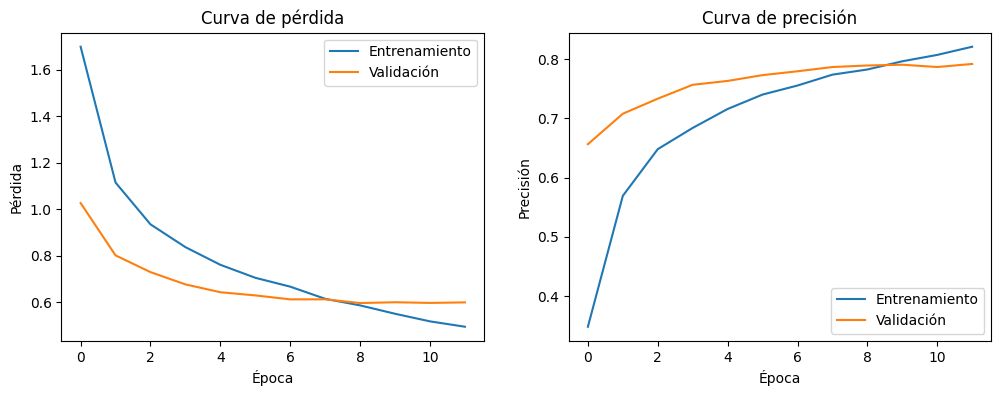

In [33]:
import matplotlib.pyplot as plt


train_loss = HistoryDiltibert7Emotions2Clear.history['loss']
val_loss = HistoryDiltibert7Emotions2Clear.history['val_loss']
train_accuracy = HistoryDiltibert7Emotions2Clear.history['accuracy']
val_accuracy = HistoryDiltibert7Emotions2Clear.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Model 6 XlNet + NGram CNN - 7 Emotions - Double cleaning - 72.88%

In [51]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [52]:
import re
import spacy
from nltk.corpus import words
nltk.download('words')



nlp = spacy.load("en_core_web_sm") #Spacy model english text
valid_words = set(words.words())  

def correct_ii_errors(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if 'ii' in word.lower() and word.lower() not in valid_words:
            corrected_word = word.replace('ii', 'i')
            if corrected_word.lower() in valid_words:
                corrected_words.append(corrected_word)
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

def clean_emotion_text(texto):
    if isinstance(texto, list): 
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): 
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"(?<!\S)\?(?!\S)", '', texto)
    texto = re.sub(r"(?<!\S)\.(?!\S)", '', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) 
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    corrected_text = correct_ii_errors(texto)  

    return corrected_text


x_train_augmentedwith = [clean_emotion_text(text) for text in tqdm(x_train_augmented)]

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 20899/20899 [00:00<00:00, 32139.11it/s]


In [55]:
def tokenizer_xlnet_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_XLNet(text,
                                      padding="max_length",
                                      truncation=True,
                                      max_length=300,
                                      return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])
    
    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_XLNet, attention_mask_train_XLNet, labels_train_XLNet = tokenizer_xlnet_fn(x_train_augmentedwith, y_train_augmented)
input_ids_test_XLNet, attention_mask_test_XLNet, labels_test_XLNet = tokenizer_xlnet_fn(x_test, y_test)
input_ids_val_XLNet, attention_mask_val_XLNet, labels_val_XLNet = tokenizer_xlnet_fn(x_val, y_val)

input_ids_train_XLNet = np.squeeze(input_ids_train_XLNet, axis=1)
attention_mask_train_XLNet = np.squeeze(attention_mask_train_XLNet, axis=1)

input_ids_test_XLNet = np.squeeze(input_ids_test_XLNet, axis=1)
attention_mask_test_XLNet = np.squeeze(attention_mask_test_XLNet, axis=1)

input_ids_val_XLNet= np.squeeze(input_ids_val_XLNet, axis=1)
attention_mask_val_XLNet = np.squeeze(attention_mask_val_XLNet, axis=1)

In [39]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
xlnet_output = model_XLNet([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(xlnet_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(xlnet_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(xlnet_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelTestXLNet7Emotions2Clear = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestXLNet7Emotions2Clear.layers[2].trainable=False

modelTestXLNet7Emotions2Clear.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestXLNet7Emotions2Clear.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tfxl_net_model (TFXLNetModel)  TFXLNetModelOutput(  116718336   ['input_7[0][0]',                
                                last_hidden_state=(               'input_8[0][0]']                
                                None, 300, 768),                                                  
                                 mems=((300, None,                                          

In [34]:
input_ids_train_XLNet.shape

(20899, 300)

In [40]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/XLNet_clean2/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/XLNet_clean2/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/XLNet_clean2/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/XLNet_clean2/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
HistoryXLNet7Emotions2Clear = modelTestXLNet7Emotions2Clear.fit(
    [input_ids_train_XLNet, attention_mask_train_XLNet], labels_train_XLNet,
    validation_data=([input_ids_val_XLNet, attention_mask_val_XLNet], labels_val_XLNet),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=32, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
654/654 [==============================] - ETA: 0s - loss: 5.8048 - accuracy: 0.1989 - recall_3: 0.1581
Epoch 1: val_accuracy improved from -inf to 0.33116, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/XLNet_clean2/128batch\BERT_CNN_model_best_01_val_0.3312.h5
654/654 [==============================] - 613s 919ms/step - loss: 5.8048 - accuracy: 0.1989 - recall_3: 0.1581 - val_loss: 1.7097 - val_accuracy: 0.3312 - val_recall_3: 0.0000e+00
Epoch 2/20
654/654 [==============================] - ETA: 0s - loss: 1.9670 - accuracy: 0.2600 - recall_3: 0.1047
Epoch 2: val_accuracy improved from 0.33116 to 0.40417, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/XLNet_clean2/128batch\BERT_CNN_model_best_02_val_0.4042.h5
654/654 [==============================] - 595s 910ms/step - loss: 1.9670 - accuracy: 0.2600 - recall_3: 0.1047 - val_loss: 1.6437 -

In [42]:
modelTestXLNet7Emotions2Clear.evaluate([input_ids_test_XLNet,attention_mask_test_XLNet],labels_test_XLNet)

24/24 [==============================] - 18s 742ms/step - loss: 0.7136 - accuracy: 0.7288 - recall_3: 0.6089


[0.7135916352272034, 0.7288135886192322, 0.6088657379150391]

In [58]:
def custom_objects_fn_XLNet():
    return {'TFXLNetModel': TFXLNetModel}

modelTestXLNet7Emotions2Clear_load = load_model(r'model/BERTHugginfFace/OptimizationBestModel/7Emotions/XLNet_clean2/128batch\BERT_CNN_model_best_20_val_0.7223.h5', custom_objects_fn_XLNet())
print(modelTestXLNet7Emotions2Clear_load.summary())
evaluateXLNet = modelTestXLNet7Emotions2Clear_load.evaluate([input_ids_test_XLNet, attention_mask_test_XLNet], labels_test_XLNet)
print("Evaluación test: ",evaluateXLNet)

c:\Users\bryan\anaconda3\envs\GPU_IEMOCAP\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tfxl_net_model_1 (TFXLNetModel  TFXLNetModelOutput(  116718336  ['input_7[0][0]',                
 )                              last_hidden_state=(               'input_8[0][0]']                
                                None, 300, 768),                                                  
                                 mems=((300, None,                                          

In [59]:
y_true3 = np.argmax(labels_test_XLNet, axis=-1)
y_pred3 = modelTestXLNet7Emotions2Clear_load.predict([input_ids_test_XLNet, attention_mask_test_XLNet])
y_pred3 = np.argmax(y_pred3, axis=-1)

report3 = classification_report(y_true3, y_pred3)
print(report3)

matrix3 = confusion_matrix(y_true3, y_pred3)
print(matrix3)

24/24 [==============================] - 20s 741ms/step
              precision    recall  f1-score   support

           0       0.67      0.51      0.58       110
           1       0.59      0.67      0.63       109
           2       0.81      0.76      0.79       109
           3       0.76      0.83      0.80       109
           4       0.86      0.68      0.76       110
           5       0.66      0.75      0.70       110
           6       0.77      0.90      0.83       110

    accuracy                           0.73       767
   macro avg       0.73      0.73      0.73       767
weighted avg       0.73      0.73      0.73       767

[[56 25 10  9  0 10  0]
 [16 73  4  3  1 11  1]
 [ 2 10 83  4  1  9  0]
 [ 2  5  1 91  0 10  0]
 [ 0  3  1  2 75  1 28]
 [ 8  7  3 10  0 82  0]
 [ 0  0  0  0 10  1 99]]


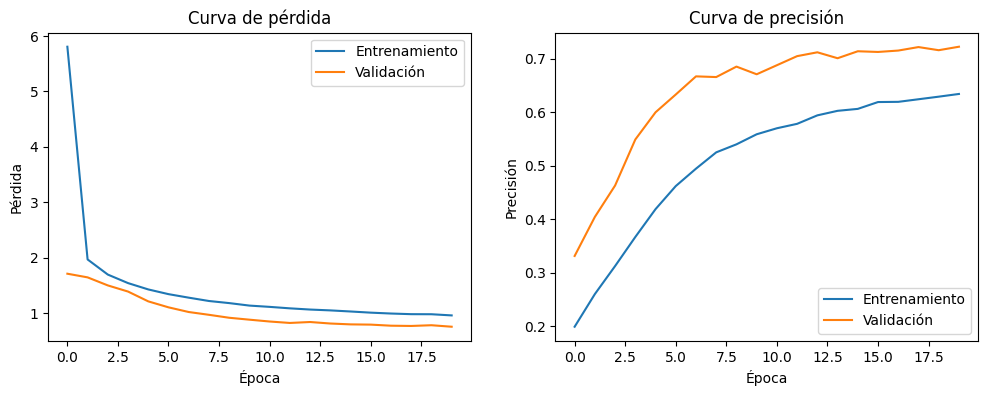

In [41]:
import matplotlib.pyplot as plt


train_loss = HistoryXLNet7Emotions2Clear.history['loss']
val_loss = HistoryXLNet7Emotions2Clear.history['val_loss']
train_accuracy = HistoryXLNet7Emotions2Clear.history['accuracy']
val_accuracy = HistoryXLNet7Emotions2Clear.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Model 7 ALBERT + NGram CNN - 7 Emotions - Double cleaning - 72.75%

In [46]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [47]:
import re
import spacy
from nltk.corpus import words
nltk.download('words')



nlp = spacy.load("en_core_web_sm") #Spacy model english text
valid_words = set(words.words())  

def correct_ii_errors(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if 'ii' in word.lower() and word.lower() not in valid_words:
            corrected_word = word.replace('ii', 'i')
            if corrected_word.lower() in valid_words:
                corrected_words.append(corrected_word)
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

def clean_emotion_text(texto):
    if isinstance(texto, list): 
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): 
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"(?<!\S)\?(?!\S)", '', texto)
    texto = re.sub(r"(?<!\S)\.(?!\S)", '', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) 
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    corrected_text = correct_ii_errors(texto)  

    return corrected_text


x_train_augmentedwith = [clean_emotion_text(text) for text in tqdm(x_train_augmented)]

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 20899/20899 [00:00<00:00, 31246.92it/s]


In [48]:
def tokenizer_albert_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_Albert(text,
                                      padding="max_length",
                                      truncation=True,
                                      max_length=300,
                                      return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])
    input_ids = np.squeeze(input_ids, axis=1)
    attention_masks = np.squeeze(attention_masks, axis=1)
    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_Albert, attention_mask_train_Albert, labels_train_Albert = tokenizer_albert_fn(x_train_augmentedwith, y_train_augmented)
input_ids_test_Albert, attention_mask_test_Albert, labels_test_Albert = tokenizer_albert_fn(x_test, y_test)
input_ids_val_Albert, attention_mask_val_Albert, labels_val_Albert = tokenizer_albert_fn(x_val, y_val)

In [46]:
input_ids_train_Albert, input_ids_train_Albert.shape

(array([[  2,  72,  58, ...,   0,   0,   0],
        [  2,  72,  58, ...,   0,   0,   0],
        [  2,  72,  58, ...,   0,   0,   0],
        ...,
        [  2,  76,  31, ...,   0,   0,   0],
        [  2,  31, 441, ...,   0,   0,   0],
        [  2,  76,  31, ...,   0,   0,   0]]),
 (20899, 300))

In [47]:
attention_mask_train_Albert, attention_mask_train_Albert.shape

(array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 (20899, 300))

In [50]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
albert_output = model_Albert([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(albert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(albert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(albert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelTestAlbert7Emotions2Clear = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestAlbert7Emotions2Clear.layers[2].trainable=False

modelTestAlbert7Emotions2Clear.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestAlbert7Emotions2Clear.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_albert_model_1 (TFAlbertMod  TFBaseModelOutputWi  11683584   ['input_11[0][0]',               
 el)                            thPooling(last_hidd               'input_12[0][0]']               
                                en_state=(None, 300                                               
                                , 768),                                                     

In [51]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/ALBERT_clean2/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/ALBERT_clean2/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/ALBERT_clean2/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/ALBERT_clean2/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
HistoryAlbert7Emotions2Clear = modelTestAlbert7Emotions2Clear.fit(
    [input_ids_train_Albert, attention_mask_train_Albert], labels_train_Albert,
    validation_data=([input_ids_val_Albert, attention_mask_val_Albert], labels_val_Albert),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 2.6945 - accuracy: 0.2640 - recall_2: 0.1755
Epoch 1: val_accuracy improved from -inf to 0.54433, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/ALBERT_clean2/128batch\BERT_CNN_model_best_01_val_0.5443.h5
164/164 [==============================] - 331s 2s/step - loss: 2.6945 - accuracy: 0.2640 - recall_2: 0.1755 - val_loss: 1.3153 - val_accuracy: 0.5443 - val_recall_2: 0.1167
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 1.4700 - accuracy: 0.4125 - recall_2: 0.2389
Epoch 2: val_accuracy improved from 0.54433 to 0.61213, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/ALBERT_clean2/128batch\BERT_CNN_model_best_02_val_0.6121.h5
164/164 [==============================] - 306s 2s/step - loss: 1.4700 - accuracy: 0.4125 - recall_2: 0.2389 - val_loss: 1.1086 - val_acc

In [49]:
def custom_objects_fn_albert():
    return {'TFAlbertModel': TFAlbertModel}

modelTestAlbert7Emotions2Clear_load = load_model(r'model/BERTHugginfFace/OptimizationBestModel/7Emotions/ALBERT_clean2/128batch\BERT_CNN_model_best_07_val_0.7288.h5', custom_objects_fn_albert())
print(modelTestAlbert7Emotions2Clear_load.summary())
evaluateAlbert = modelTestAlbert7Emotions2Clear_load.evaluate([input_ids_test_Albert, attention_mask_test_Albert], labels_test_Albert)
print("Evaluación test: ",evaluateAlbert)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_albert_model_1 (TFAlbertMod  TFBaseModelOutputWi  11683584   ['input_11[0][0]',               
 el)                            thPooling(last_hidd               'input_12[0][0]']               
                                en_state=(None, 300                                               
                                , 768),                                                     

In [50]:
y_true3 = np.argmax(labels_test_Albert, axis=-1)
y_pred3 = modelTestAlbert7Emotions2Clear_load.predict([input_ids_test_Albert, attention_mask_test_Albert])
y_pred3 = np.argmax(y_pred3, axis=-1)

report3 = classification_report(y_true3, y_pred3)
print(report3)

matrix3 = confusion_matrix(y_true3, y_pred3)
print(matrix3)

24/24 [==============================] - 14s 445ms/step
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       110
           1       0.63      0.55      0.59       109
           2       0.79      0.77      0.78       109
           3       0.79      0.87      0.83       109
           4       0.75      0.81      0.78       110
           5       0.76      0.65      0.70       110
           6       0.82      0.79      0.81       110

    accuracy                           0.73       767
   macro avg       0.73      0.73      0.73       767
weighted avg       0.73      0.73      0.73       767

[[72 20  4  3  2  9  0]
 [26 60 10  4  4  4  1]
 [ 9  7 84  4  0  5  0]
 [ 6  1  2 95  0  5  0]
 [ 0  0  1  2 89  0 18]
 [13  7  5 13  1 71  0]
 [ 0  0  0  0 23  0 87]]


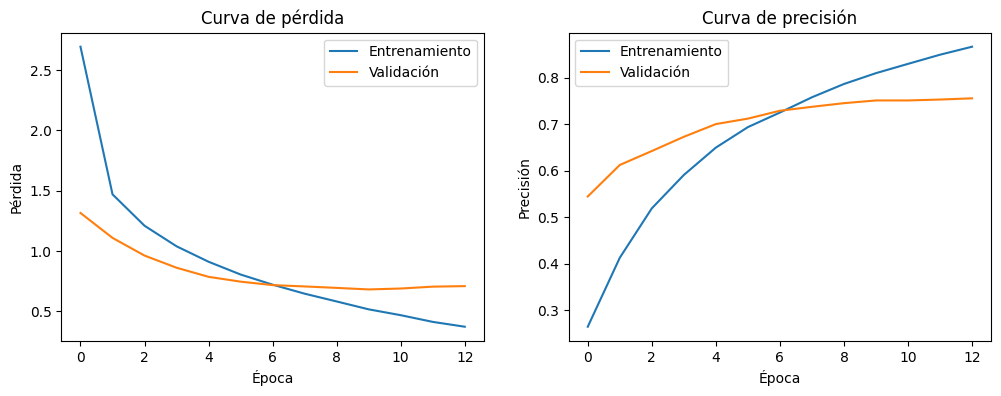

In [52]:
import matplotlib.pyplot as plt


train_loss = HistoryAlbert7Emotions2Clear.history['loss']
val_loss = HistoryAlbert7Emotions2Clear.history['val_loss']
train_accuracy = HistoryAlbert7Emotions2Clear.history['accuracy']
val_accuracy = HistoryAlbert7Emotions2Clear.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Model 8 DeBERTa + NGram CNN - 7 Emotions - Double cleaning - 80.18%

In [23]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [ ]:
import re
import spacy
from nltk.corpus import words
nltk.download('words') # Download the NLTK word corpus for English words



nlp = spacy.load("en_core_web_sm") #Spacy model english text
valid_words = set(words.words())  

def correct_ii_errors(text): # Function to correct errors where 'ii' appears in words unnecessarily
    words = text.split() # Split the text into individual words
    corrected_words = []
    for word in words:
        if 'ii' in word.lower() and word.lower() not in valid_words: # Check if 'ii' exists in the word and it's not a valid English word
            corrected_word = word.replace('ii', 'i') # Replace 'ii' with 'i'
            if corrected_word.lower() in valid_words:
                corrected_words.append(corrected_word) # If the corrected word is a valid English word, append it
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word) # Append words that don't need correction
    return ' '.join(corrected_words)

def clean_emotion_text(texto): #Function for data clearing
    if isinstance(texto, list):  #If it is a list, it takes the first value
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'):  #If it starts and ends with [] it eliminates them
        texto = texto[1:-1]

    texto = texto.lower() #Convert text to lowercase

    texto = texto.replace('á', '') #Eliminate errors
    texto = texto.replace('\n', '') #Eliminates erroneous spaces
    texto = texto.replace('[]', "'") #Eliminate []
    texto = texto.replace('', "'") #Eliminate more errors

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto) #Remove any text starting with @
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) #Remove Urls that with "https://
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto) #Remove any character that is not a letter
    texto = re.sub(r"(?<!\S)\?(?!\S)", '', texto) # Remove isolated question marks
    texto = re.sub(r"(?<!\S)\.(?!\S)", '', texto)
    texto = re.sub(r"#", ' ', texto) #Remove the # symbol
    texto = re.sub(r"\s(?=\')", "", texto)  # Remove spaces before apostrophes
    texto = texto.replace("' ", "'") # Remove spaces after apostrophes
    texto = re.sub(r" +", ' ', texto) # Replace multiple spaces with a single space.

    corrected_text = correct_ii_errors(texto)  # Apply the 'ii' error correction function 

    return corrected_text


x_train_augmentedwith = [clean_emotion_text(text) for text in tqdm(x_train_augmented)] #Apply the function to the text

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 20899/20899 [00:00<00:00, 42867.88it/s]


In [ ]:
def tokenizer_deberta_fn(texts, labels): #Function for tokenization by DeBERTa Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=7) #Transforms labels to OneHotEncoder

    for text in texts:
        inputs = tokenizer_deberta(text, #Tokenized
                                      padding="max_length", #Padding is applied with a length of 300
                                      truncation=True, # Truncate sequences longer than the maximum length
                                      max_length=300, #Max length
                                      return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved
    input_ids = np.squeeze(input_ids, axis=1) # Remove the unnecessary dimension introduced
    attention_masks = np.squeeze(attention_masks, axis=1) # Remove the unnecessary dimension introduced
    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_Deberta, attention_mask_train_Deberta, labels_train_Deberta = tokenizer_deberta_fn(x_train_augmentedwith, y_train_augmented)
input_ids_test_Deberta, attention_mask_test_Deberta, labels_test_Deberta = tokenizer_deberta_fn(x_test, y_test)
input_ids_val_Deberta, attention_mask_val_Deberta, labels_val_Deberta = tokenizer_deberta_fn(x_val, y_val)

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
deberta_output = model_deberta([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(deberta_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(deberta_output) #Enter the output to TriGram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(deberta_output) #Enter the output to FourGram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout) #Output layer
modelTestDeberta7Emotions2Clear = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

modelTestDeberta7Emotions2Clear.layers[2].trainable=False

modelTestDeberta7Emotions2Clear.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
modelTestDeberta7Emotions2Clear.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_deberta_model (TFDebertaMod  TFBaseModelOutput(l  138601728  ['input_13[0][0]',               
 el)                            ast_hidden_state=(N               'input_14[0][0]']               
                                one, 300, 768),                                                   
                                 hidden_states=None                                         

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Deberta_clean2/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Deberta_clean2/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Deberta_clean2/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Deberta_clean2/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve

#--------------------------------------------------------------------------------
HistoryDeberta7Emotions2Clear = modelTestDeberta7Emotions2Clear.fit( #Training model
    [input_ids_train_Deberta, attention_mask_train_Deberta], labels_train_Deberta,
    validation_data=([input_ids_val_Deberta, attention_mask_val_Deberta], labels_val_Deberta),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=64, shuffle=True
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
327/327 [==============================] - ETA: 0s - loss: 2.1820 - accuracy: 0.2916 - recall_6: 0.1459
Epoch 1: val_accuracy improved from -inf to 0.61864, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Deberta_clean2/128batch\BERT_CNN_model_best_01_val_0.6186.h5
327/327 [==============================] - 1125s 3s/step - loss: 2.1820 - accuracy: 0.2916 - recall_6: 0.1459 - val_loss: 1.1312 - val_accu

In [71]:
modelTestDeberta7Emotions2Clear.save('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Deberta_clean2/128batch/DEBERTA_CNN_model_best_11_val_0.8148.h5')

In [ ]:
def custom_objects_fn_deberta():
    return {'TFDebertaModel': TFDebertaModel}

#Validation model
model_deberta_load = load_model(r'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Deberta_clean2/128batch\BERT_CNN_model_best_06_val_0.7862.h5', custom_objects=custom_objects_fn_deberta())
y_true3 = np.argmax(labels_test_Deberta, axis=-1)
y_pred3 = model_deberta_load.predict([input_ids_test_Deberta, attention_mask_test_Deberta])
y_pred3 = np.argmax(y_pred3, axis=-1)

report3 = classification_report(y_true3, y_pred3) #The classification report is generated with various metrics.
print(report3)

matrix3 = confusion_matrix(y_true3, y_pred3)
print(matrix3)

24/24 [==============================] - 24s 559ms/step
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       110
           1       0.74      0.72      0.73       109
           2       0.87      0.83      0.85       109
           3       0.85      0.89      0.87       109
           4       0.84      0.83      0.83       110
           5       0.77      0.76      0.77       110
           6       0.84      0.86      0.85       110

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.80      0.80      0.80       767

[[79 17  3  3  0  8  0]
 [17 78  3  4  2  5  0]
 [ 5  2 91  5  0  6  0]
 [ 1  2  3 97  0  6  0]
 [ 0  1  0  0 91  0 18]
 [10  6  5  5  0 84  0]
 [ 0  0  0  0 15  0 95]]


Text(95.72222222222221, 0.5, 'True')

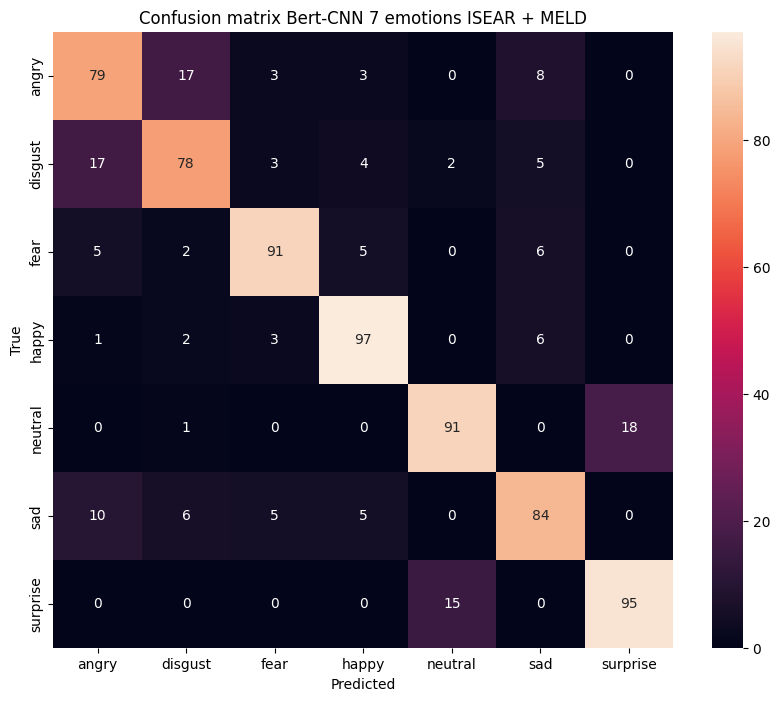

In [27]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix3, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion matrix Bert-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

Text(95.72222222222221, 0.5, 'True')

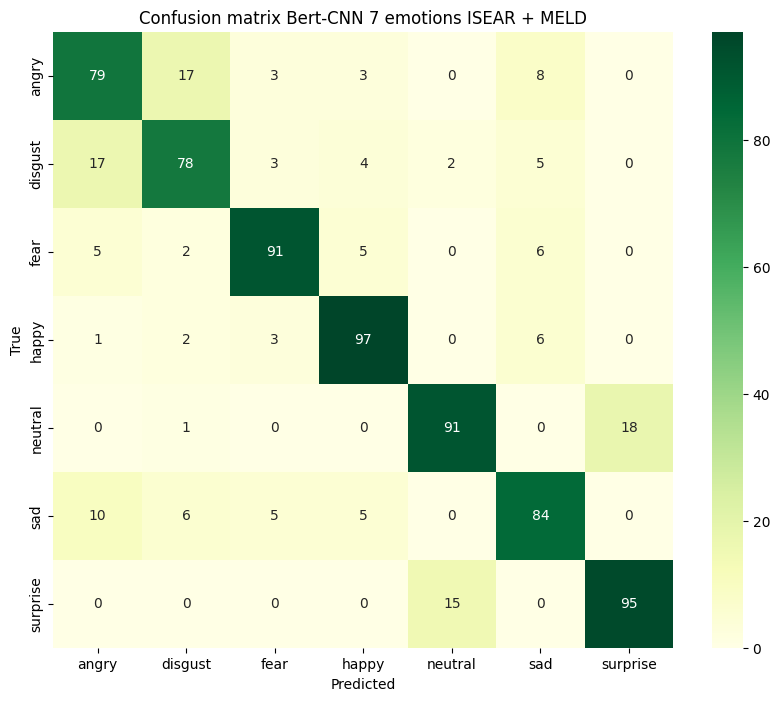

In [28]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10,8))
sns.heatmap(matrix3, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='YlGn')
plt.title('Confusion matrix Bert-CNN 7 emotions ISEAR + MELD')
plt.xlabel('Predicted')
plt.ylabel('True')

In [29]:
model_deberta_load.evaluate([input_ids_test_Deberta, attention_mask_test_Deberta],labels_test_Deberta)

24/24 [==============================] - 18s 555ms/step - loss: 0.5382 - accuracy: 0.8018 - recall_6: 0.7392


[0.5382092595100403, 0.8018252849578857, 0.7392438054084778]

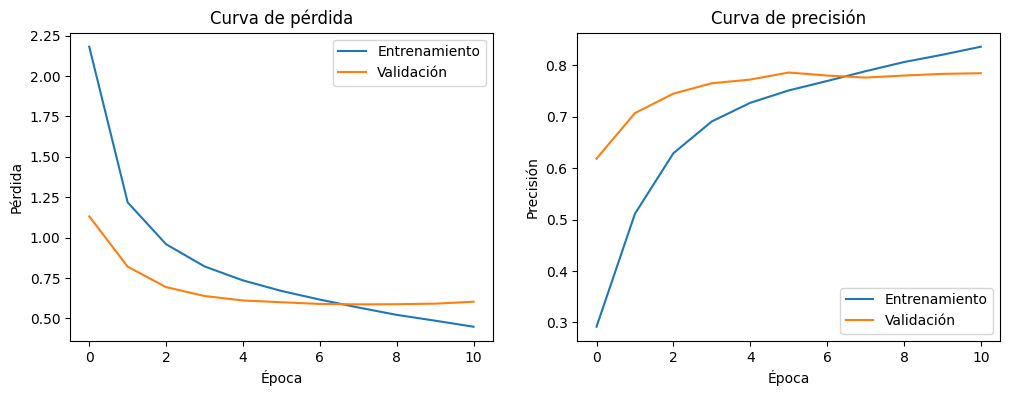

In [67]:
import matplotlib.pyplot as plt


train_loss = HistoryDeberta7Emotions2Clear.history['loss']
val_loss = HistoryDeberta7Emotions2Clear.history['val_loss']
train_accuracy = HistoryDeberta7Emotions2Clear.history['accuracy']
val_accuracy = HistoryDeberta7Emotions2Clear.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## Model 9 ELECTRA + NGram CNN - 7 Emotions - Double cleaning - 67.66%

In [31]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [32]:
import re
import spacy
from nltk.corpus import words
nltk.download('words')



nlp = spacy.load("en_core_web_sm") #Spacy model english text
valid_words = set(words.words())  

def correct_ii_errors(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if 'ii' in word.lower() and word.lower() not in valid_words:
            corrected_word = word.replace('ii', 'i')
            if corrected_word.lower() in valid_words:
                corrected_words.append(corrected_word)
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

def clean_emotion_text(texto):
    if isinstance(texto, list): 
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): 
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"(?<!\S)\?(?!\S)", '', texto)
    texto = re.sub(r"(?<!\S)\.(?!\S)", '', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) 
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    corrected_text = correct_ii_errors(texto)  

    return corrected_text


x_train_augmentedwith = [clean_emotion_text(text) for text in tqdm(x_train_augmented)]

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 20899/20899 [00:00<00:00, 26368.97it/s]


In [33]:
def tokenizer_electra_fn(texts, labels):
    input_ids = []
    attention_masks = []
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_electra(text,
                                      padding="max_length",
                                      truncation=True,
                                      max_length=300,
                                      return_tensors='tf')
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])
    input_ids = np.squeeze(input_ids, axis=1)
    attention_masks = np.squeeze(attention_masks, axis=1)
    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_Electra, attention_mask_train_Electra, labels_train_Electra = tokenizer_electra_fn(x_train_augmentedwith, y_train_augmented)
input_ids_test_Electra, attention_mask_test_Electra, labels_test_Electra = tokenizer_electra_fn(x_test, y_test)
input_ids_val_Electra, attention_mask_val_Electra, labels_val_Electra = tokenizer_electra_fn(x_val, y_val)

In [38]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
electra_output = model_Electra([input_ids_layer, attention_mask_layer])[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(electra_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(electra_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(electra_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
modelTestElectra7Emotions2Clear = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

modelTestElectra7Emotions2Clear.layers[2].trainable=False

modelTestElectra7Emotions2Clear.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
modelTestElectra7Emotions2Clear.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_electra_model (TFElectraMod  TFBaseModelOutputWi  13483008   ['input_7[0][0]',                
 el)                            thPastAndCrossAtten               'input_8[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, 300, 25                                         

In [39]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Electra_clean2/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Electra_clean2/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Electra_clean2/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Electra_clean2/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#--------------------------------------------------------------------------------
HistoryElectraEmotions2Clear = modelTestElectra7Emotions2Clear.fit(
    [input_ids_train_Electra, attention_mask_train_Electra], labels_train_Electra,
    validation_data=([input_ids_val_Electra, attention_mask_val_Electra], labels_val_Electra),
    epochs=30,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/30
164/164 [==============================] - ETA: 0s - loss: 2.5950 - accuracy: 0.1748 - recall_3: 0.0667
Epoch 1: val_accuracy improved from -inf to 0.26662, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Electra_clean2/128batch\BERT_CNN_model_best_01_val_0.2666.h5
164/164 [==============================] - 101s 529ms/step - loss: 2.5950 - accuracy: 0.1748 - recall_3: 0.0667 - val_loss: 1.7284 - val_accuracy: 0.2666 - val_recall_3: 0.0000e+00
Epoch 2/30
164/164 [==============================] - ETA: 0s - loss: 1.8573 - accuracy: 0.2399 - recall_3: 0.0432
Epoch 2: val_accuracy improved from 0.26662 to 0.32855, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Electra_clean2/128batch\BERT_CNN_model_best_02_val_0.3286.h5
164/164 [==============================] - 84s 509ms/step - loss: 1.8573 - accuracy: 0.2399 - recall_3: 0.0432 - val_loss: 1.560

In [42]:
modelTestElectra7Emotions2Clear.evaluate([input_ids_test_Electra, attention_mask_test_Electra],labels_test_Electra)


24/24 [==============================] - 3s 118ms/step - loss: 0.8188 - accuracy: 0.6767 - recall_3: 0.5567


[0.818799614906311, 0.6766623258590698, 0.5567144751548767]

In [44]:
y_true3 = np.argmax(labels_test_Electra, axis=-1)
y_pred3 = modelTestElectra7Emotions2Clear.predict([input_ids_test_Electra, attention_mask_test_Electra])
y_pred3 = np.argmax(y_pred3, axis=-1)

report3 = classification_report(y_true3, y_pred3)
print(report3)

matrix3 = confusion_matrix(y_true3, y_pred3)
print(matrix3)

24/24 [==============================] - 7s 117ms/step
              precision    recall  f1-score   support

           0       0.52      0.53      0.52       110
           1       0.60      0.50      0.54       109
           2       0.76      0.64      0.70       109
           3       0.69      0.77      0.73       109
           4       0.81      0.78      0.80       110
           5       0.57      0.65      0.61       110
           6       0.81      0.86      0.83       110

    accuracy                           0.68       767
   macro avg       0.68      0.68      0.68       767
weighted avg       0.68      0.68      0.68       767

[[58 23  6  6  1 16  0]
 [23 54 12  6  3 11  0]
 [10  8 70  8  1 12  0]
 [ 4  2  3 84  0 16  0]
 [ 0  0  0  1 86  0 23]
 [17  3  1 17  0 72  0]
 [ 0  0  0  0 15  0 95]]


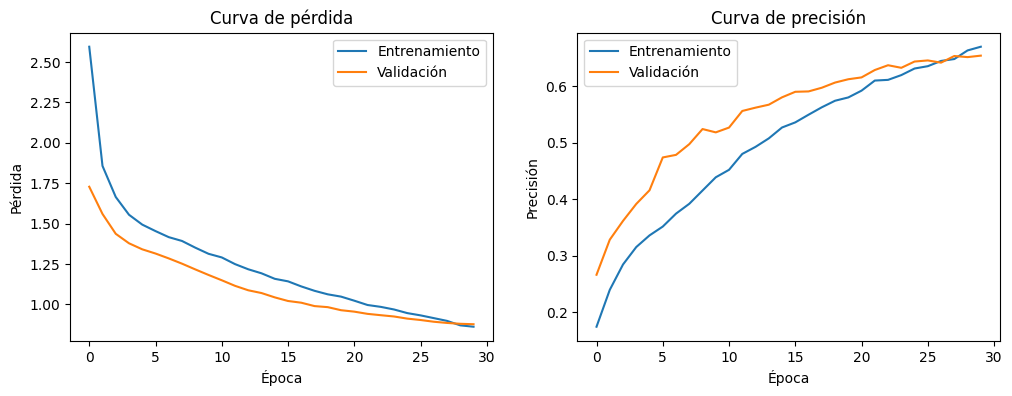

In [43]:
import matplotlib.pyplot as plt


train_loss = HistoryElectraEmotions2Clear.history['loss']
val_loss = HistoryElectraEmotions2Clear.history['val_loss']
train_accuracy = HistoryElectraEmotions2Clear.history['accuracy']
val_accuracy = HistoryElectraEmotions2Clear.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## With 7 emotions with Lemmatization

In [ ]:
import re
import spacy

nlp = spacy.load("en_core_web_sm") #Spacy model english text

def clean_emotion_text(texto): #Function for data clearing
    if isinstance(texto, list): #If it is a list, it takes the first value
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #If it starts and ends with [] it eliminates them
        texto = texto[1:-1]

    texto = texto.lower() #Convert text to lowercase

    texto = texto.replace('á', '') #Eliminate errors
    texto = texto.replace('\n', '') #Eliminates erroneous spaces
    texto = texto.replace('[]', "'") #Eliminate []
    texto = texto.replace('', "'") #Eliminate more errors

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto) #Remove any text starting with @
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) #Remove Urls that with "https://
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto) #Remove any character that is not a letter
    texto = re.sub(r"#", ' ', texto) #Remove the # symbol
    texto = re.sub(r"\s(?=\')", "", texto) # Remove spaces before apostrophes
    texto = texto.replace("' ", "'") # Remove spaces after apostrophes
    texto = re.sub(r" +", ' ', texto) # Replace multiple spaces with a single space.

    doc = nlp(texto) #Convert text in tokens
    lemmas = [token.lemma_ if token.pos_ != 'PROPN' else token.text for token in doc]  # Lemmatization is applied, except for proper names
    # Combine the processed tokens back into a single string, forming the lemmatized version of the text.
    lematized_text = ' '.join(lemmas)

    lematized_text = re.sub(r"\s(?=\')", "", lematized_text) #Remove the spaces between apostrophes
    lematized_text = re.sub(r"\s(?=\.)", "", lematized_text) #Remove the spaces that join the .
    lematized_text = re.sub(r"\s(?=\!)", "", lematized_text) #Remove the spaces that join the !
    lematized_text = re.sub(r"\s(?=\?)", "", lematized_text) #Remove the spaces that join the ?
    lematized_text = re.sub(r"\b\s+(n't\b)", r"\1", lematized_text)

    return lematized_text

# Calling the cleanup function
texto_clean_with_lemmazited = [clean_emotion_text(text) for text in tqdm(dftodo['texto'])]

100%|██████████| 7669/7669 [00:50<00:00, 150.95it/s]


In [ ]:
labels = dftodo['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels) #Labels are transformed into One Hot Encoder

data_labels = labelEncoder

In [28]:
# get the class names
class_names = le.classes_

# get the numerics values assigned to each classes
class_values = le.transform(class_names)

# show the class names and their numerics values
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: neutral, Valor: 4
Clase: sad, Valor: 5
Clase: surprise, Valor: 6


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(texto_clean_with_lemmazited, data_labels, random_state=42, stratify=data_labels, test_size=0.1) #The data is divided into 10% for testing, using stratify to maintain distribution
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train, test_size=0.2222) #The data is divided into 20% for validation, using stratify to maintain distribution

In [ ]:
#SET SEED

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [21]:
from textattack.augmentation import EasyDataAugmenter
from tqdm import tqdm
import random
import numpy as np


# create augmenter
augmenter = EasyDataAugmenter()

# Function to apply the text augmentation
def augment_text(text, label):
    set_seed(42)
    augmented_texts = augmenter.augment(text)
    augmented_data = [(augmented_text, label) for augmented_text in augmented_texts]
    return augmented_data

# Convert zip result to list
data_with_labels = list(zip(x_train, y_train))

# Apply text aumentation to each text in texto_clean
augmented_data_list = [augment_text(text, label) for text, label in tqdm(data_with_labels, total=len(data_with_labels))]

# Flatten the list of list
augmented_data_flat = [item for sublist in augmented_data_list for item in sublist]

# Extract the generated phrases and labels
x_train_augmented_lemmazited = [augmented_text for augmented_text, label in augmented_data_flat]
y_train_augmented_lemmazited = [label for augmented_text, label in augmented_data_flat]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 5368/5368 [17:18<00:00,  5.17it/s]  


In [22]:
"""#Save Augmented data

import pandas as pd

df_augmented = pd.DataFrame({'Texto': x_train_augmented_lemmazited, 'Label': y_train_augmented_lemmazited})

df_augmented.to_csv('datos_aumentados_lemmatized_with7emotions.csv', index=False)"""

In [31]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_lemmatized_with7emotions.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [ ]:
from transformers import BertTokenizer, TFBertModel,RobertaTokenizer,TFRobertaModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased') #Import the BERT tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased') #BERT's model is imported

tokenizer_roberta = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base") #RoBERTa's model is imported
roberta_model = TFRobertaModel.from_pretrained("FacebookAI/roberta-base") #RoBERTa's model is imported

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def tokenizer_roberta_fn(texts, labels): #Function for tokenization by RoBERTa Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_roberta(text,  #Tokenized
                                padding="max_length",  #Padding is applied with a length of 300
                                truncation=True, # Truncate sequences longer than the maximum length
                                max_length=300, 
                                return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta_lemmatitized, attention_mask_train_roberta_lemmatitized, labels_train_roberta_lemmatitized, = tokenizer_roberta_fn(x_train_augmented, y_train_augmented)
input_ids_test_roberta_lemmatitized, attention_mask_test_roberta_lemmatitized, labels_test_roberta_lemmatitized, = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta_lemmatitized, attention_mask_val_roberta_lemmatitized, labels_val_roberta_lemmatitized, = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta_lemmatitized = np.squeeze(input_ids_train_roberta_lemmatitized, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train_roberta_lemmatitized = np.squeeze(attention_mask_train_roberta_lemmatitized, axis=1) # Remove the unnecessary dimension introduced

input_ids_test_roberta_lemmatitized = np.squeeze(input_ids_test_roberta_lemmatitized, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test_roberta_lemmatitized = np.squeeze(attention_mask_test_roberta_lemmatitized, axis=1) # Remove the unnecessary dimension introduced

input_ids_val_roberta_lemmatitized = np.squeeze(input_ids_val_roberta_lemmatitized, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val_roberta_lemmatitized = np.squeeze(attention_mask_val_roberta_lemmatitized, axis=1) # Remove the unnecessary dimension introduced

In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output) #Enter the output to TriGram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output) #Enter the output to FourGram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout) #Output model
modelTestRoberta7Emotions_lemmatized = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

modelTestRoberta7Emotions_lemmatized.layers[2].trainable=False #Pre-trained layers set to False

modelTestRoberta7Emotions_lemmatized.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
modelTestRoberta7Emotions_lemmatized.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_7[0][0]',                
 el)                            thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve


#--------------------------------------------------------------------------------
historyRoberta7Emotions_lemmatized = modelTestRoberta7Emotions_lemmatized.fit( #Training model
    [input_ids_train_roberta_lemmatitized, attention_mask_train_roberta_lemmatitized], labels_train_roberta_lemmatitized,
    validation_data=([input_ids_val_roberta_lemmatitized, attention_mask_val_roberta_lemmatitized], labels_val_roberta_lemmatitized),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 2.2185 - accuracy: 0.2086 - recall_3: 0.0579
Epoch 1: val_accuracy improved from -inf to 0.46219, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch\BERT_CNN_model_best_01_val_0.4622.h5
164/164 [==============================] - 372s 2s/step - loss: 2.2185 - accuracy: 0.2086 - recall_3: 0.0579 - val_loss: 1.6549 - val_accuracy: 0.4622 - val_recall_3: 0.0000e+00
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 1.5857 - accuracy: 0.3400 - recall_3: 0.1010
Epoch 2: val_accuracy improved from 0.46219 to 0.54759, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized/128batch\BERT_CNN_model_best_02_val_0.5476.h5
164/164 [==============================] - 360s 2s/step - loss: 1.5857 - accuracy: 0.3400 - recall_3: 0.1010 - val_loss: 1.

In [44]:
modelTestRoberta7Emotions_lemmatized.evaluate([input_ids_test_roberta_lemmatitized,attention_mask_test_roberta_lemmatitized],labels_test_roberta_lemmatitized)

24/24 [==============================] - 10s 413ms/step - loss: 0.6220 - accuracy: 0.7927 - recall_3: 0.6636


[0.6220112442970276, 0.7926988005638123, 0.6636245250701904]

In [ ]:
def custom_objects_fn_roberta():
    return {"TFRobertaModel":TFRobertaModel}

#Evaluation model
model_load_lemmatitized = tf.keras.models.load_model(r"model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized\BERT_CNN_model_best_18_val_0.7810.h5", custom_objects=custom_objects_fn_roberta())
model_load_lemmatitized.evaluate([input_ids_test_roberta_lemmatitized, attention_mask_test_roberta_lemmatitized],labels_test_roberta_lemmatitized)

24/24 [==============================] - 14s 415ms/step - loss: 0.6330 - accuracy: 0.7940 - recall_3: 0.6428


[0.6329745650291443, 0.7940025925636292, 0.6427640318870544]

In [ ]:
y_true3 = np.argmax(labels_test_roberta_lemmatitized, axis=-1)
y_pred3 = model_load_lemmatitized.predict([input_ids_test_roberta_lemmatitized, attention_mask_test_roberta_lemmatitized])
y_pred3 = np.argmax(y_pred3, axis=-1)

report3 = classification_report(y_true3, y_pred3) #The classification report is generated with various metrics.
print(report3)

matrix3 = confusion_matrix(y_true3, y_pred3)
print(matrix3)

24/24 [==============================] - 13s 411ms/step
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       110
           1       0.72      0.68      0.70       109
           2       0.83      0.84      0.84       109
           3       0.86      0.88      0.87       109
           4       0.86      0.80      0.83       110
           5       0.75      0.76      0.76       110
           6       0.85      0.88      0.87       110

    accuracy                           0.79       767
   macro avg       0.79      0.79      0.79       767
weighted avg       0.79      0.79      0.79       767

[[78 20  2  0  0 10  0]
 [16 74  8  3  3  5  0]
 [ 3  3 92  4  0  7  0]
 [ 4  1  2 96  0  6  0]
 [ 0  0  2  3 88  0 17]
 [12  5  5  4  0 84  0]
 [ 1  0  0  1 11  0 97]]


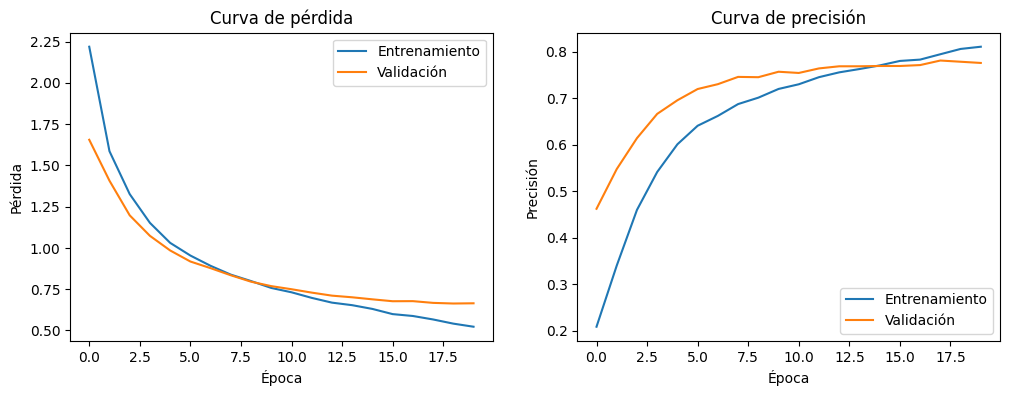

In [45]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions_lemmatized.history['loss']
val_loss = historyRoberta7Emotions_lemmatized.history['val_loss']
train_accuracy = historyRoberta7Emotions_lemmatized.history['accuracy']
val_accuracy = historyRoberta7Emotions_lemmatized.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

# With 7 emotions 3 dataset concatenated with limit 1312 data

In [ ]:
isear = pd.read_excel('ISEAR.xlsx') #Import ISEAR dataset 


print(isear.head())


      ID  CITY  COUN  SUBJ  SEX  AGE  RELI  PRAC  FOCC  MOCC  ...  SELF  RELA  \
0  11001     1     1     1    1   33     1     2     6     1  ...     3     3   
1  11001     1     1     1    1   33     1     2     6     1  ...     2     2   
2  11001     1     1     1    1   33     1     2     6     1  ...     2     1   
3  11001     1     1     1    1   33     1     2     6     1  ...     1     1   
4  11001     1     1     1    1   33     1     2     6     1  ...     0     2   

   VERBAL  NEUTRO   Field1  Field3  Field2   MYKEY  \
0       2       0      joy       4       3  110011   
1       0       0     fear       3       2  110012   
2       0       0    anger       1       3  110013   
3       0       2  sadness       4       4  110014   
4       0       0  disgust       4       4  110015   

                                                 SIT  STATE  
0  During the period of falling in love, each tim...      1  
1         When I was involved in a traffic accident.      1  
2 

In [ ]:
isearDataset = isear.iloc[:, [40,36]] #only column 40 (text) and 36 (label) are selected.
isearDataset = isearDataset.rename(columns={'Field1': 'label', 'SIT': 'texto'}) #Rename columns from Field 1 to label and from Sit to text
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness
7663,I was at home and I heard a loud sound of spit...,disgust
7664,I did not do the homework that the teacher had...,shame


In [ ]:
def eliminarAcentos(texto):
    texto = texto.replace('á', '') #Eliminate errors in english text (á)
    texto = texto.replace('\n', '') #Remove spaces
    return texto
isearDataset['texto'] = isearDataset['texto'].apply(eliminarAcentos) #Apply function

In [ ]:
"""
Here the labels shame, guilt and guit are eliminated as they are not representative for the recognition of emotions in education.
"""


isearDataset = isearDataset.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad']) #Rename labels joy, anger and sadness to happy, angry y sad
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'shame'].index) #Eliminate labels not to be used
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guilt'].index) #Eliminate labels not to be used
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guit'].index) #Eliminate labels not to be used
isearDataset = isearDataset.reset_index(drop=True)
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
5472,I received a letter from a distant friend.,happy
5473,My parents were out and I was the eldest at ho...,fear
5474,Two years back someone invited me to be the tu...,angry
5475,I had taken the responsibility to do something...,sad


In [ ]:
dfMeld=pd.read_csv('meld_train.csv') #The meld dataset is read

label = dfMeld['Emotion'] #Only the emotion column (labels) is obtained
text = dfMeld['Utterance'] #Only the Utterance column (text) is obtained

data = { #The dataframe is created
    'texto' : text.tolist(),
    'label' : label.tolist()
}

dfMeld= pd.DataFrame(data)

In [ ]:
dfMeld['label'].value_counts()# The number of samples on each label is analyzed

label
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64

In [ ]:
dfMeld = dfMeld.replace(to_replace=['joy', 'sadness', 'anger'], value=['happy', 'sad', 'angry']) #Rename labels joy, anger and sadness to happy, angry y sad
dfMeld

def eliminarAcentos(texto):
    texto = texto.replace('[]', "'") #Remove []
    texto = texto.replace('', "'") #Eliminate errors
    return texto
dfMeld['texto'] = dfMeld['texto'].apply(eliminarAcentos) #Apply function
dfMeld


,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


In [ ]:
iemocapDataset = pd.read_csv('df_filters.csv') #The Iemocap is read
iemocapDataset

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [47]:
iemocapDataset['Emoción'].unique()

array(['neutral', 'angry', 'sad', 'happy', 'surprise', 'fear', 'disgust'],
      dtype=object)

In [ ]:
iemocapDataset = iemocapDataset.rename(columns={'Emoción': 'label', 'Texto':'texto'}) # Rename the columns Emoción to labels and Texto to texto
iemocapDataset

,texto,label
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [ ]:
dfMeld['label'].value_counts() # The number of samples on each label is analyzed

label
neutral     4710
happy       1743
surprise    1205
angry       1109
sad          683
disgust      271
fear         268
Name: count, dtype: int64

In [ ]:
isearDataset['label'].value_counts() # The number of samples on each label is analyzed

label
angry      1096
sad        1096
disgust    1096
fear       1095
happy      1094
Name: count, dtype: int64

In [ ]:
iemocapDataset['label'].value_counts() # The number of samples on each label is analyzed

label
neutral     1707
angry       1103
sad         1083
happy        595
surprise     107
fear          40
disgust        2
Name: count, dtype: int64

In [ ]:
IemocapCantidad = iemocapDataset[iemocapDataset['label']=='neutral'].sample(2, random_state=42) #The only two emotions that Iemocap presents in Neutral are analyzed
IemocapCantidad

,texto,label
1330,"If I laugh at everything, then I must laugh at...",neutral
3669,"Well, I have no camera here. I can't help you ...",neutral


In [16]:
len(isearDataset[isearDataset['label']=='neutral'])

0

In [ ]:
import pandas as pd

objetivo = { #Create a dictionary with target class count
    'neutral': 1310, 
    'angry': 1312,
    'sad': 1312,
    'happy': 1310,
    'surprise': 1311,
    'fear': 1311,
    'disgust': 1312
}

#Initialize an empty DataFrame to store the combined data
dftodo = pd.DataFrame(columns=['texto', 'label'])

"""
A function is created that analyzes the classes necessary to have the dataset and balances 
the data to approximately 1311 to have an equivalent distribution with the new samples to 
be added to the ISEAR dataset, since this dataset is balanced, maintaining its distribution. 
In this way, if it does not present those two new classes, MELD includes it, and if there are 
not enough samples, Iemocap will give you the missing ones.
"""

for clase in objetivo.keys(): #For each class in the objectivo dictionary
    number = objetivo[clase]
    actual = len(isearDataset[isearDataset['label'] == clase]) #Current count of samples for the class in the principal Isear dataset
    faltante = number - actual # Calculate how many samples are missing to meet the target
    meldCantidad = len(dfMeld[dfMeld['label'] == clase]) # Count of samples available in `dfMeld` for the class
    print("Faltante 1", faltante)
    print("clase:", clase)
    print("CantidadMeld", meldCantidad)

    if actual == 0 and faltante == number: #If that class does not exist in th Isear dataset
        if meldCantidad >= number: # If meld has the missing samples for that class
            meldCantidadEntrega = dfMeld[dfMeld['label'] == clase].sample(number, random_state=42) # Provide the missing samples numbers to the dataset
            dftodo = pd.concat([dftodo, meldCantidadEntrega], axis=0) #Enter it into the dataset
            faltante -= len(meldCantidadEntrega) # subtract from the missing what was added to the dataset
        else:
            meldCantidadEntrega = dfMeld[dfMeld['label'] == clase] #In case Meld does not have enough quantity
            dftodo = pd.concat([dftodo, meldCantidadEntrega], axis=0) # Add whatever you have
            faltante = len(dftodo[dftodo['label']==clase]) #Th missing is subtracted from the added 
            if faltante < number: # If more samples are missing to reach the target number
                faltante = number-faltante #It is subtracted to see what is missing
                IemocapCantidad = iemocapDataset[iemocapDataset['label']==clase].sample(faltante, random_state=42) # Iemocap samples are entered into that class
                dftodo = pd.concat([dftodo, IemocapCantidad], axis=0) #Enter it into the dataset
                faltante = len(dftodo[dftodo['label']==clase]) #subtract from the missing what was added to the dataset
            continue


    while faltante > 0: #In case the samples exist and data is missing
        if meldCantidad <= faltante: # If meld has enough quantity for missing 
            meldCantidadEntrega = dfMeld[dfMeld['label'] == clase].sample(meldCantidad, random_state=42) # Provide the missing samples numbers to the dataset
            isearDataset_necesario = isearDataset[isearDataset['label'] == clase]
            dftodo = pd.concat([dftodo, isearDataset_necesario, meldCantidadEntrega], axis=0) #Enter it into the dataset
            dftodo_largo = len(dftodo[dftodo['label'] == clase]) 
            print("FALTANTE MELD1", dftodo_largo)
            if dftodo_largo < number: #If the current amount is lower, try with the second Iemocap dataset
                actual2 = len(dftodo[dftodo['label'] == clase])
                faltante2 = number - actual2 # Calculate missing samples  
                IemocapCantidad = iemocapDataset[iemocapDataset['label'] == clase].sample(faltante2, random_state=42) # Iemocap samples are entered into that class
                dftodo = pd.concat([dftodo, IemocapCantidad], axis=0) #Enter it into the dataset
                faltante = number - len(dftodo[dftodo['label'] == clase])
                print("FALTANTE IEMOCAP", faltante)
                if faltante == 0:
                    print("Se terminó")
                    break
            else:
                if dftodo_largo == number: # If the target number has already been reached, the function exits
                    break
        else: #In case Meld has enough quantity, it will directly join all the Meld samples
            meldCantidadEntrega = dfMeld[dfMeld['label'] == clase].sample(faltante, random_state=42) #Iemocap samples are entered into that class
            isearDataset_necesario = isearDataset[isearDataset['label'] == clase]
            dftodo = pd.concat([dftodo, isearDataset_necesario, meldCantidadEntrega], axis=0) #The datasets are concatenated
            faltante = number - len(dftodo[dftodo['label'] == clase])
            print("actual MELD2", len(dftodo[dftodo['label'] == clase]))
            if faltante == 0: #If the target number has already been reached, the function exits.
                break


print(dftodo['label'].value_counts())



Faltante 1 1310
clase: neutral
CantidadMeld 4710
Faltante 1 216
clase: angry
CantidadMeld 1109
actual MELD2 1312
Faltante 1 216
clase: sad
CantidadMeld 683
actual MELD2 1312
Faltante 1 216
clase: happy
CantidadMeld 1743
actual MELD2 1310
Faltante 1 1311
clase: surprise
CantidadMeld 1205
Faltante 1 216
clase: fear
CantidadMeld 268
actual MELD2 1311
Faltante 1 216
clase: disgust
CantidadMeld 271
actual MELD2 1312
label
angry       1312
sad         1312
disgust     1312
surprise    1311
fear        1311
neutral     1310
happy       1310
Name: count, dtype: int64


In [ ]:
dftodo['label'].value_counts() #Se analiza que la distribución se mantenga del dataset ISEAR con las nuevos datos de Iemocap

label
angry       1312
sad         1312
disgust     1312
surprise    1311
fear        1311
neutral     1310
happy       1310
Name: count, dtype: int64

In [14]:
dftodo.reset_index(inplace=True,drop=True)
dftodo

,texto,label
0,"Now, have you told anyone else?",neutral
1,No.,neutral
2,"No thanks, I've already seen one.",neutral
3,"No, answer his.",neutral
4,"Y'know, twin stuff is always a real big seller.",neutral
...,...,...
9173,We've got the ground-up flesh of formerly cute...,disgust
9174,"But I stand by my review, I know food and that...",disgust
9175,Oh no.,disgust
9176,"What are you talking about?! Mindy, the guy is...",disgust


In [15]:
dftodo['label'].value_counts()

label
angry       1312
sad         1312
disgust     1312
surprise    1311
fear        1311
neutral     1310
happy       1310
Name: count, dtype: int64

In [ ]:
import re
import spacy

nlp = spacy.load("en_core_web_sm")  #Spacy model english text

def clean_emotion_text(texto): #Function for data clearing
    if isinstance(texto, list): #If it is a list, it takes the first value
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'):  #If it starts and ends with [] it eliminates them
        texto = texto[1:-1]

    texto = texto.lower() #Convert text to lowercase

    texto = texto.replace('á', '') #Eliminate errors
    texto = texto.replace('\n', '') #Eliminates erroneous spaces
    texto = texto.replace('[]', "'") #Eliminate []
    texto = texto.replace('', "'") #Eliminate more errors

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto) #Remove any text starting with @
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) #Remove Urls that with "https://
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto) #Remove any character that is not a letter
    texto = re.sub(r"#", ' ', texto) #Remove the # symbol
    texto = re.sub(r"\s(?=\')", "", texto)  # Remove spaces before apostrophes
    texto = texto.replace("' ", "'") # Remove spaces after apostrophes
    texto = re.sub(r" +", ' ', texto) # Replace multiple spaces with a single space

    return texto


texto_clean = [clean_emotion_text(text) for text in tqdm(dftodo['texto'])] #Apply the function to the text

100%|██████████| 9178/9178 [00:00<00:00, 58263.92it/s]


In [ ]:
labels = dftodo['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels) #Labels are transformed into One Hot Encoder

data_labels = labelEncoder

In [18]:
# get the class names
class_names = le.classes_

# get the numerics values assigned to each classes
class_values = le.transform(class_names)

# show the class names and their numerics values
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: neutral, Valor: 4
Clase: sad, Valor: 5
Clase: surprise, Valor: 6


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(texto_clean, data_labels, random_state=42, stratify=data_labels, test_size=0.1) #The data is divided into 10% for testing, using stratify to maintain distribution
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train, test_size=0.2222) #The data is divided into 20% for validation, using stratify to maintain distribution


In [22]:
from textattack.augmentation import EasyDataAugmenter
from tqdm import tqdm
import random
import numpy as np


# create augmenter
augmenter = EasyDataAugmenter()

# Function to apply the text augmentation
def augment_text(text, label):
    set_seed(42)
    augmented_texts = augmenter.augment(text)
    augmented_data = [(augmented_text, label) for augmented_text in augmented_texts]
    return augmented_data

# Convert zip result to list
data_with_labels = list(zip(x_train, y_train))

# Apply text aumentation to each text in texto_clean
augmented_data_list = [augment_text(text, label) for text, label in tqdm(data_with_labels, total=len(data_with_labels))]

# Flatten the list of list
augmented_data_flat = [item for sublist in augmented_data_list for item in sublist]

# Extract the generated phrases and labels
x_train_augmented = [augmented_text for augmented_text, label in augmented_data_flat]
y_train_augmented = [label for augmented_text, label in augmented_data_flat]


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 6424/6424 [15:03<00:00,  7.11it/s]  


In [ ]:
import re
import spacy
from nltk.corpus import words
nltk.download('words') # Download the NLTK word corpus for English words



nlp = spacy.load("en_core_web_sm") #Spacy model english text
valid_words = set(words.words())  

def correct_ii_errors(text): # Function to correct errors where 'ii' appears in words unnecessarily
    words = text.split() # Split the text into individual words
    corrected_words = []
    for word in words:
        if 'ii' in word.lower() and word.lower() not in valid_words: # Check if 'ii' exists in the word and it's not a valid English word
            corrected_word = word.replace('ii', 'i')  #Replace 'ii' with 'i'
            if corrected_word.lower() in valid_words:
                corrected_words.append(corrected_word) # If the corrected word is a valid English word, append it
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word) # Append words that don't need correction
    return ' '.join(corrected_words)

def clean_emotion_text(texto): #Function for data clearing
    if isinstance(texto, list):  #If it is a list, it takes the first value
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'):  #If it starts and ends with [] it eliminates them
        texto = texto[1:-1]

    texto = texto.lower() #Convert text to lowercase

    texto = texto.replace('á', '') #Eliminate errors
    texto = texto.replace('\n', '') #Eliminates erroneous spaces
    texto = texto.replace('[]', "'") #Eliminate []
    texto = texto.replace('', "'") #Eliminate more errors

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto) #Remove any text starting with @
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto) #Remove Urls that with "https://
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto) #Remove any character that is not a letter
    texto = re.sub(r"(?<!\S)\?(?!\S)", '', texto) # Remove isolated question marks.
    texto = re.sub(r"(?<!\S)\.(?!\S)", '', texto)
    texto = re.sub(r"#", ' ', texto) #Remove the # symbol
    texto = re.sub(r"\s(?=\')", "", texto)   # Remove spaces before apostrophes
    texto = texto.replace("' ", "'") # Remove spaces after apostrophes
    texto = re.sub(r" +", ' ', texto) # Replace multiple spaces with a single space.

    corrected_text = correct_ii_errors(texto)   # Apply the 'ii' error correction function

    return corrected_text

# Llamado a la función de limpieza
x_train_augmentedwith = [clean_emotion_text(text) for text in tqdm(x_train_augmented)] #Apply the function to the text

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
100%|██████████| 24905/24905 [00:00<00:00, 36265.78it/s]


In [24]:
#Save Augmented data

import pandas as pd

df_augmented = pd.DataFrame({'Texto': x_train_augmentedwith, 'Label': y_train_augmented})

df_augmented.to_csv('datos_aumentados_lemmatized_MoreDatawith7emotionsMoreData.csv', index=False)

In [20]:
import pandas as pd

# Load the csv file into a dataframe
df_recuperado = pd.read_csv('datos_aumentados_lemmatized_MoreDatawith7emotionsMoreData.csv')

# Get the augmented data and labels
x_train_augmented = df_recuperado['Texto'].tolist()
y_train_augmented = df_recuperado['Label'].tolist()

In [ ]:
from transformers import BertTokenizer, TFBertModel,RobertaTokenizer,TFRobertaModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased') #Import the BERT tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')  #BERT's model is imported

tokenizer_roberta = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")   #RoBERTa's model is imported
roberta_model = TFRobertaModel.from_pretrained("FacebookAI/roberta-base") #Import the RoBERTa tokenizer



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def tokenizer_roberta_fn(texts, labels): #Function for tokenization by RoBERTa Tokenizer
    input_ids = [] #The list of inputs_ids is created
    attention_masks = [] #The list of attention_masks is created
    label_array = tf.one_hot(labels, depth=7)

    for text in texts:
        inputs = tokenizer_roberta(text,  #Tokenized
                                padding="max_length",  #Padding is applied with a length of 300
                                truncation=True, # Truncate sequences longer than the maximum length
                                max_length=300, #Max length
                                return_tensors='tf') #That works for tensorflow
        input_ids.append(inputs['input_ids']) #Input_ids is obtained and saved
        attention_masks.append(inputs['attention_mask']) #Attention masks are obtained and saved

    return np.array(input_ids), np.array(attention_masks), label_array

input_ids_train_roberta_lemmatitized_moreData, attention_mask_train_roberta_lemmatitized_moreData, labels_train_roberta_lemmatitized_moreData = tokenizer_roberta_fn(x_train_augmented, y_train_augmented)
input_ids_test_roberta_lemmatitized_moreData, attention_mask_test_roberta_lemmatitized_moreData, labels_test_roberta_lemmatitized_moreData, = tokenizer_roberta_fn(x_test, y_test)
input_ids_val_roberta_lemmatitized_moreData, attention_mask_val_roberta_lemmatitized_moreData, labels_val_roberta_lemmatitized_moreData, = tokenizer_roberta_fn(x_val, y_val)

input_ids_train_roberta_lemmatitized_moreData = np.squeeze(input_ids_train_roberta_lemmatitized_moreData, axis=1) # Remove the unnecessary dimension introduced
attention_mask_train_roberta_lemmatitized_moreData = np.squeeze(attention_mask_train_roberta_lemmatitized_moreData, axis=1) # Remove the unnecessary dimension introduced

input_ids_test_roberta_lemmatitized_moreData = np.squeeze(input_ids_test_roberta_lemmatitized_moreData, axis=1) # Remove the unnecessary dimension introduced
attention_mask_test_roberta_lemmatitized_moreData = np.squeeze(attention_mask_test_roberta_lemmatitized_moreData, axis=1) # Remove the unnecessary dimension introduced

input_ids_val_roberta_lemmatitized_moreData = np.squeeze(input_ids_val_roberta_lemmatitized_moreData, axis=1) # Remove the unnecessary dimension introduced
attention_mask_val_roberta_lemmatitized_moreData = np.squeeze(attention_mask_val_roberta_lemmatitized_moreData, axis=1) # Remove the unnecessary dimension introduced


In [ ]:
#Input_ids and attention_masks entries with a maximum length of 300 for the model.
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])[0] #The output of the model is obtained
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(roberta_output) #Enter the output to BiGram- Conv1D
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(roberta_output) #Enter the output to TriGram- Conv1D
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(roberta_output) #Enter the output to FourGram- Conv1D
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1) #The layers are concatenated
dropout = tf.keras.layers.Dropout(0.5)(merged) 
dense_layer = tf.keras.layers.Dense(512, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout) #Output model
modelTestRoberta7Emotions_lemmatized_MoreData = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output) #Creation model

modelTestRoberta7Emotions_lemmatized_MoreData.layers[2].trainable=False #Pre-trained layers set to False

modelTestRoberta7Emotions_lemmatized_MoreData.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall()]) #Compilation
modelTestRoberta7Emotions_lemmatized_MoreData.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [ ]:
import os
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from datetime import datetime

#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # to stop the model when it stops learning


#--------------------Checkpoint--------------------


os.makedirs('model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint( #To create a checkpoint when the model is improved
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1) #To create a graph that show the accuracy and loss curve


#--------------------------------------------------------------------------------
historyRoberta7Emotions_lemmatized_MoreData = modelTestRoberta7Emotions_lemmatized_MoreData.fit( #Training model
    [input_ids_train_roberta_lemmatitized_moreData, attention_mask_train_roberta_lemmatitized_moreData], labels_train_roberta_lemmatitized_moreData,
    validation_data=([input_ids_val_roberta_lemmatitized_moreData, attention_mask_val_roberta_lemmatitized_moreData], labels_val_roberta_lemmatitized_moreData),
    epochs=20,
    callbacks = [early_stopping,model_checkpoint,tensorboard_callback], batch_size=128, shuffle=True
)


#print(model23.evaluate([input_ids_test, attention_mask_test], labels_test))

Epoch 1/20
195/195 [==============================] - ETA: 0s - loss: 2.1977 - accuracy: 0.2120 - recall: 0.0485
Epoch 1: val_accuracy improved from -inf to 0.41285, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch\BERT_CNN_model_best_01_val_0.4129.h5
195/195 [==============================] - 422s 2s/step - loss: 2.1977 - accuracy: 0.2120 - recall: 0.0485 - val_loss: 1.7135 - val_accuracy: 0.4129 - val_recall: 0.0000e+00
Epoch 2/20
195/195 [==============================] - ETA: 0s - loss: 1.6712 - accuracy: 0.3306 - recall: 0.0608
Epoch 2: val_accuracy improved from 0.41285 to 0.53486, saving model to model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/lemmatized_MoreData/128batch\BERT_CNN_model_best_02_val_0.5349.h5
195/195 [==============================] - 405s 2s/step - loss: 1.6712 - accuracy: 0.3306 - recall: 0.0608 - val_loss: 1.5570 - val_accuracy: 0.5349 - val_recall: 0.0000e+00
Epoch 3/20
195/195 [=========

In [ ]:
def custom_objects_fn_roberta():
    return {"TFRobertaModel":TFRobertaModel}

#Evaluation model
model_load_MoreData = tf.keras.models.load_model(r"model/BERTHugginfFace/OptimizationBestModel/7Emotions/Roberta/moreData\BERT_CNN_model_best_19_val_0.6944.h5", custom_objects=custom_objects_fn_roberta())
model_load_MoreData.evaluate([input_ids_test_roberta_lemmatitized_moreData, attention_mask_test_roberta_lemmatitized_moreData],labels_test_roberta_lemmatitized_moreData)

29/29 [==============================] - 19s 419ms/step - loss: 0.8749 - accuracy: 0.7081 - recall: 0.5556


[0.8749175071716309, 0.7080609798431396, 0.5555555820465088]

In [ ]:
y_true3 = np.argmax(labels_test_roberta_lemmatitized_moreData, axis=-1)
y_pred3 = model_load_MoreData.predict([input_ids_test_roberta_lemmatitized_moreData, attention_mask_test_roberta_lemmatitized_moreData])
y_pred3 = np.argmax(y_pred3, axis=-1)

report3 = classification_report(y_true3, y_pred3) #The classification report is generated with various metrics.
print(report3)

matrix3 = confusion_matrix(y_true3, y_pred3)
print(matrix3)

29/29 [==============================] - 15s 410ms/step
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       132
           1       0.70      0.61      0.65       131
           2       0.79      0.79      0.79       131
           3       0.82      0.73      0.77       131
           4       0.69      0.65      0.67       131
           5       0.71      0.69      0.70       131
           6       0.64      0.85      0.73       131

    accuracy                           0.71       918
   macro avg       0.71      0.71      0.71       918
weighted avg       0.71      0.71      0.71       918

[[ 84  19   6   4   3   9   7]
 [ 16  80   7   1   6   9  12]
 [  7   0 103   3   3   8   7]
 [  3   0   6  96  10   5  11]
 [  6   5   1   3  85   5  26]
 [ 10   8   5   8   9  90   1]
 [  5   2   2   2   7   1 112]]


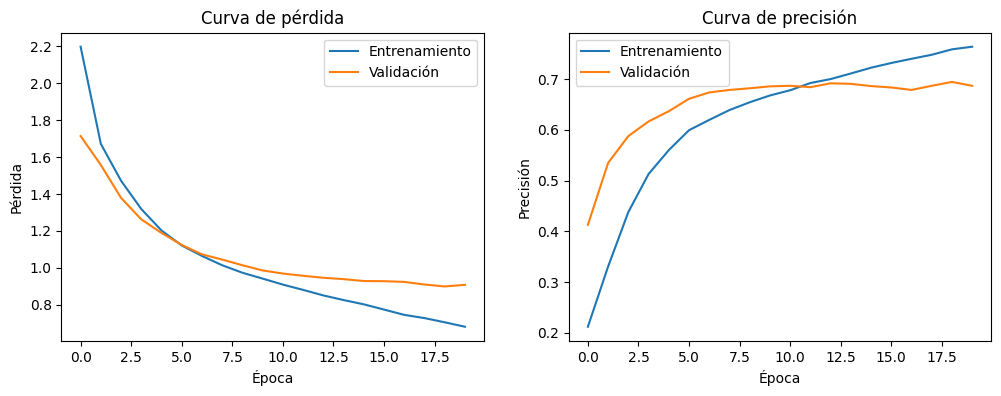

In [30]:
import matplotlib.pyplot as plt


train_loss = historyRoberta7Emotions_lemmatized_MoreData.history['loss']
val_loss = historyRoberta7Emotions_lemmatized_MoreData.history['val_loss']
train_accuracy = historyRoberta7Emotions_lemmatized_MoreData.history['accuracy']
val_accuracy = historyRoberta7Emotions_lemmatized_MoreData.history['val_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()